**WARNING**: Remember to run the `ExtractBoundaries` notebook present in this same folder before running all (or specifically the `Import Boundaries` cell), if you don't have them in your drive inside /LoveDA  

**WARNING2** Be sure to have `best_model_Resize.pth` or similar on the colab disk if you're running the pretrained model

In [91]:
SAVE_ON_DRIVE = True # Set to True if you want to save the datasets and trained models to your Google Drive
TYPE = 'Train'

# Dataset initialization


### Download Data

In [92]:
from google.colab import drive
import os
import shutil

drive.mount('/content/drive')

# Set paths for Validation and Test datasets
val_dataset_path = '/content/drive/MyDrive/LoveDA/Val'
test_dataset_path = '/content/drive/MyDrive/LoveDA/Test'


# Function to handle dataset download and extraction
def handle_dataset(dataset_name, zip_url, local_path, drive_path):
    if not os.path.exists(local_path):
        if os.path.exists(f"{drive_path}.zip"):
            print(f"{dataset_name} dataset available on own drive, unzipping...")
            !unzip -q {drive_path}.zip -d ./
        else:
            print(f"Downloading {dataset_name} dataset...")
            !wget -O {dataset_name}.zip "{zip_url}"
            if SAVE_ON_DRIVE:
                print(f"Saving {dataset_name} dataset on drive...")
                !cp {dataset_name}.zip {drive_path}.zip
                print(f"{dataset_name} dataset saved on drive")
            print(f"Unzipping {dataset_name} dataset...")
            !unzip -q {dataset_name}.zip -d ./
    else:
        print(f"{dataset_name} dataset already in local")

# Handle Validation dataset
#handle_dataset("Validation", "https://zenodo.org/records/5706578/files/Val.zip?download=1", "./Val", "/content/drive/MyDrive/LoveDA/Val")

# Handle Test dataset
#handle_dataset("Test", "https://zenodo.org/records/5706578/files/Test.zip?download=1", "./Test", "/content/drive/MyDrive/LoveDA/Test")

# Handle Train dataset
handle_dataset("Train", "https://zenodo.org/records/5706578/files/Train.zip?download=1", "./Train", "/content/drive/MyDrive/LoveDA/Train")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train dataset already in local


### Import Boundaries

In [93]:
# Paths
rural_boundaries_path = "./Train/Rural/boundaries_png"
rural_masks_path = './Train/Rural/masks_png'

urban_boundaries_path = "./Train/Urban/boundaries_png"
urban_masks_path = './Train/Urban/masks_png'
drive_rural_boundaries_path = '/content/drive/MyDrive/LoveDA/boundaries/Rural/boundaries_png'
drive_urban_boundaries_path = '/content/drive/MyDrive/LoveDA/boundaries/Urban/boundaries_png'

boundaries_paths = [rural_boundaries_path, urban_boundaries_path]

# Make dir inside ./Train/...
for boundaries_path in boundaries_paths:
    if (os.path.exists(boundaries_path) == False):
        print(f"Creating {boundaries_path}...")
        os.makedirs(boundaries_path)
    else:
        print(f"{boundaries_path} exists...")


# Check if files are already present
rural_file_count = len([name for name in os.listdir(rural_boundaries_path) if os.path.isfile(os.path.join(rural_boundaries_path, name))])
rural_mask_file_count = len([name for name in os.listdir(rural_masks_path) if os.path.isfile(os.path.join(rural_masks_path, name))])
urban_file_count = len([name for name in os.listdir(urban_boundaries_path) if os.path.isfile(os.path.join(urban_boundaries_path, name))])
urban_mask_file_count = len([name for name in os.listdir(urban_masks_path) if os.path.isfile(os.path.join(urban_masks_path, name))])

# if (rural_file_count != rural_mask_file_count):
#     print(f"Importing boundaries, as we have {rural_file_count} rural boundaries as of now...")
#     shutil.copytree(drive_rural_boundaries_path, rural_boundaries_path, dirs_exist_ok=True)
# else:
#     print(f"Rural boundaries already present, {rural_file_count} files...")

if (urban_file_count != urban_mask_file_count):
    print(f"Importing boundaries, as we have {urban_file_count} urban boundaries as of now...")
    shutil.copytree(drive_urban_boundaries_path, urban_boundaries_path, dirs_exist_ok=True)
else:
    print(f"Urban boundaries already present, {urban_file_count} files...")

./Train/Rural/boundaries_png exists...
./Train/Urban/boundaries_png exists...
Urban boundaries already present, 1156 files...


### Dataset Definition

In [94]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T
import random
import cv2


def pil_loader(path, color_type):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert(color_type)

class LoveDADataset(Dataset):
    def __init__(self, baseTransform, augTransforms, split = 'Urban', type = 'Train', useBoundaries=True, validation_ratio=0.2, seed=265637):
        # Validate type input
        if type not in ['Train', 'Validation', 'Total', 'ActualTest']:
            raise ValueError("Invalid type. Expected 'Train' or 'Validation' or 'Total' or 'ActualTest'.")
        self.directory = []
        if type == 'ActualTest':
            directory_path = os.path.join('./Test', split, 'images_png')
        else:
            directory_path = os.path.join('./Train', split, 'images_png')
        # Check if the directory exists
        if not os.path.exists(directory_path):
            raise FileNotFoundError(f"Directory not found: {directory_path}")
        # Get all image paths
        all_images = [os.path.join(directory_path, entry) for entry in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, entry))]
        # Shuffle images for random splitting
        random.seed(seed)
        random.shuffle(all_images)
        # Split into training and validation sets
        split_idx = int(len(all_images) * (1 - validation_ratio))
        if type == 'Train':
            self.directory = all_images[:split_idx]
        elif type == 'Validation':
            self.directory = all_images[split_idx:]
        elif type == 'Total':
            self.directory = all_images
        elif type == 'ActualTest':
            self.directory = all_images
        else:
            raise ValueError("Invalid type. Expected 'Train' or 'Validation' or 'Total' or 'ActualTest.")
        self.baseTransforms = baseTransform
        self.augTransforms = augTransforms
        self.useBoundaries = useBoundaries
        self.typeDataset = type
        # Print dataset size
        print(f"Dataset size: {len(self.directory)}")

    def __len__(self):
        return len(self.directory)

    def __getitem__(self, idx):
        image_path = self.directory[idx]
        image = pil_loader(image_path, 'RGB')
        mask_path = image_path.replace('images_png', 'masks_png')
        boundaries_path = image_path.replace('images_png', 'boundaries_png')

        mask = pil_loader(mask_path, 'L')

        if self.useBoundaries:
          boundaries = pil_loader(boundaries_path, 'L')
        else:
          boundaries = mask

        base_transformed = self.baseTransforms(image=np.array(image), mask=np.array(mask), boundaries=np.array(boundaries))
        base_image = base_transformed['image']
        base_mask = base_transformed['mask']
        base_boundaries = base_transformed['boundaries']

        base_image = T.Compose([T.ToTensor()])(base_image)
        base_mask = torch.from_numpy(base_mask).long()
        base_mask -= 1
        base_boundaries = torch.from_numpy(base_boundaries)

        if(self.typeDataset != 'Train'):
          return base_image, base_mask, image_path, base_boundaries


        if self.augTransforms == None:
          return [base_image], [base_mask], image_path, [base_boundaries]
        # Apply transformations
        augmented = self.augTransforms(image=np.array(image), mask=np.array(mask), boundaries=np.array(boundaries))
        augmented_image = T.Compose([T.ToTensor()])(augmented['image'])

        mask = augmented['mask']
        mask = torch.from_numpy(mask).long()
        mask = mask-1
        boundaries = augmented['boundaries']
        boundaries = torch.from_numpy(boundaries)

        image_list = [base_image, augmented_image]
        mask_list = [base_mask, mask]
        boundaries_list = [base_boundaries, boundaries]

        return image_list, mask_list, image_path, boundaries_list

### Dataset Utils

In [95]:
import matplotlib.patches as mpatches

from collections import OrderedDict
COLOR_MAP = OrderedDict(
    Background=(255, 255, 255),
    Building=(255, 0, 0),
    Road=(255, 255, 0),
    Water=(0, 0, 255),
    Barren=(159, 129, 183),
    Forest=(34, 139, 34),
    Agricultural=(255, 195, 128),
)

LABEL_MAP = OrderedDict(
    Background=0,
    Building=1,
    Road=2,
    Water=3,
    Barren=4,
    Forest=5,
    Agricultural=6,
)
inverted_label_map = OrderedDict((v, k) for k, v in LABEL_MAP.items())


def getLabelColor(label):
    # Default color for unclassified labels
    default_color = np.array([128, 128, 128])  # Gray

    # Check if label exists in inverted_label_map
    label_name = inverted_label_map.get(label, None)
    if label_name is None or label_name not in COLOR_MAP:
        return default_color  # Return default color for unclassified

    # Return the mapped color
    label_color = np.array(COLOR_MAP[label_name])
    return label_color


def getLegendHandles():
  handles = [mpatches.Patch(color=getLabelColor(i)/255, label=inverted_label_map[i]) for i in range(0, len(LABEL_MAP))]
  handles.append(mpatches.Patch(color=getLabelColor(-1)/255, label='Unclassified'))
  return handles

def new_colors_mask(mask):
  new_image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
  for i, row in enumerate(mask):
    for j, cell in enumerate(row):
      new_image[i][j] = getLabelColor(cell.item())
  return new_image



### Dataset Debug

In [96]:
# # Comment this cell to save GPU time

# import matplotlib.pyplot as plt
# import torch
# from torch.utils.data import DataLoader
# import matplotlib.patches as mpatches

# train_dataset = LoveDADataset(type='Train', seed=222)
# print(train_dataset.__len__())

# # Get item
# image, mask, path, bd = train_dataset.__getitem__(88)

# # Show path
# print(f"Image is at {path}")

# # Show image
# image = image.permute(1, 2, 0)
# image = image.numpy()
# plt.imshow(image)

# # Show mask
# new_image = new_colors_mask(mask)
# plt.imshow(image)
# plt.show()
# plt.legend(handles=getLegendHandles(), loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
# plt.imshow(new_image)
# plt.show()

# # Show boundaries
# # for row in bd:
# #     for col in row:
# #         if col != 0 and col != 1:
# #             print(col)
# bd = bd.numpy()
# plt.imshow(bd)


# Initialize model

### PIDNet Util Modules

In [97]:
# ------------------------------------------------------------------------------
# Written by Jiacong Xu (jiacong.xu@tamu.edu)
# ------------------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        if self.no_relu:
            return out
        else:
            return self.relu(out)

class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=True):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = BatchNorm2d(planes * self.expansion, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        if self.no_relu:
            return out
        else:
            return self.relu(out)

class segmenthead(nn.Module):

    def __init__(self, inplanes, interplanes, outplanes, scale_factor=None):
        super(segmenthead, self).__init__()
        self.bn1 = BatchNorm2d(inplanes, momentum=bn_mom)
        self.conv1 = nn.Conv2d(inplanes, interplanes, kernel_size=3, padding=1, bias=False)
        self.bn2 = BatchNorm2d(interplanes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(interplanes, outplanes, kernel_size=1, padding=0, bias=True)
        self.scale_factor = scale_factor

    def forward(self, x):

        x = self.conv1(self.relu(self.bn1(x)))
        out = self.conv2(self.relu(self.bn2(x)))

        if self.scale_factor is not None:
            height = x.shape[-2] * self.scale_factor
            width = x.shape[-1] * self.scale_factor
            out = F.interpolate(out,
                        size=[height, width],
                        mode='bilinear', align_corners=algc)

        return out

class DAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(DAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.process1 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process2 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process3 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process4 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )
        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )

    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        x_list = []

        x_list.append(self.scale0(x))
        x_list.append(self.process1((F.interpolate(self.scale1(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[0])))
        x_list.append((self.process2((F.interpolate(self.scale2(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[1]))))
        x_list.append(self.process3((F.interpolate(self.scale3(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[2])))
        x_list.append(self.process4((F.interpolate(self.scale4(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[3])))

        out = self.compression(torch.cat(x_list, 1)) + self.shortcut(x)
        return out

class PAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(PAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale_process = nn.Sequential(
                                    BatchNorm(branch_planes*4, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes*4, branch_planes*4, kernel_size=3, padding=1, groups=4, bias=False),
                                    )


        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )

        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )


    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        scale_list = []

        x_ = self.scale0(x)
        scale_list.append(F.interpolate(self.scale1(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale2(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale3(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale4(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)

        scale_out = self.scale_process(torch.cat(scale_list, 1))

        out = self.compression(torch.cat([x_,scale_out], 1)) + self.shortcut(x)
        return out


class PagFM(nn.Module):
    def __init__(self, in_channels, mid_channels, after_relu=False, with_channel=False, BatchNorm=nn.BatchNorm2d):
        super(PagFM, self).__init__()
        self.with_channel = with_channel
        self.after_relu = after_relu
        self.f_x = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        self.f_y = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        if with_channel:
            self.up = nn.Sequential(
                                    nn.Conv2d(mid_channels, in_channels,
                                              kernel_size=1, bias=False),
                                    BatchNorm(in_channels)
                                   )
        if after_relu:
            self.relu = nn.ReLU(inplace=True)

    def forward(self, x, y):
        input_size = x.size()
        if self.after_relu:
            y = self.relu(y)
            x = self.relu(x)

        y_q = self.f_y(y)
        y_q = F.interpolate(y_q, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x_k = self.f_x(x)

        if self.with_channel:
            sim_map = torch.sigmoid(self.up(x_k * y_q))
        else:
            sim_map = torch.sigmoid(torch.sum(x_k * y_q, dim=1).unsqueeze(1))

        y = F.interpolate(y, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x = (1-sim_map)*x + sim_map*y

        return x

class Light_Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Light_Bag, self).__init__()
        self.conv_p = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add


class DDFMv2(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(DDFMv2, self).__init__()
        self.conv_p = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add

class Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Bag, self).__init__()

        self.conv = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=3, padding=1, bias=False)
                                )


    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)
        return self.conv(edge_att*p + (1-edge_att)*i)



### PIDNet Definition

In [98]:
# ------------------------------------------------------------------------------
# Written by Jiacong Xu (jiacong.xu@tamu.edu)
# ------------------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import logging

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

INPUT_SIZE = (512, 512)

class PIDNet(nn.Module):

    def __init__(self, m=2, n=3, num_classes=19, planes=64, ppm_planes=96, head_planes=128, augment=True):
        super(PIDNet, self).__init__()
        self.augment = augment

        # I Branch
        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, planes, planes, m)
        self.layer2 = self._make_layer(BasicBlock, planes, planes * 2, m, stride=2)
        self.layer3 = self._make_layer(BasicBlock, planes * 2, planes * 4, n, stride=2)
        self.layer4 = self._make_layer(BasicBlock, planes * 4, planes * 8, n, stride=2)
        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 2, stride=2)

        # P Branch
        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )
        self.pag3 = PagFM(planes * 2, planes)
        self.pag4 = PagFM(planes * 2, planes)

        self.layer3_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer4_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer5_ = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # D Branch
        if m == 2:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes)
            self.layer4_d = self._make_layer(Bottleneck, planes, planes, 1)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = PAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Light_Bag(planes * 4, planes * 4)
        else:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.layer4_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes * 2, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes * 2, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = DAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Bag(planes * 4, planes * 4)

        self.layer5_d = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # Prediction Head
        if self.augment:
            self.seghead_p = segmenthead(planes * 2, head_planes, num_classes)
            self.seghead_d = segmenthead(planes * 2, planes, 1)

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)

    def _make_single_layer(self, block, inplanes, planes, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layer = block(inplanes, planes, stride, downsample, no_relu=True)

        return layer

    def forward(self, x):

        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8

        h, w = x.size(2), x.size(3)

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.relu(self.layer2(self.relu(x)))
        x_ = self.layer3_(x)
        x_d = self.layer3_d(x)

        x = self.relu(self.layer3(x))
        x_ = self.pag3(x_, self.compression3(x))
        x_d = x_d + F.interpolate(
                        self.diff3(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_p = x_

        x = self.relu(self.layer4(x))
        x_ = self.layer4_(self.relu(x_))
        x_d = self.layer4_d(self.relu(x_d))

        x_ = self.pag4(x_, self.compression4(x))
        x_d = x_d + F.interpolate(
                        self.diff4(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_d = x_d

        x_ = self.layer5_(self.relu(x_))
        x_d = self.layer5_d(self.relu(x_d))
        x = F.interpolate(
                        self.spp(self.layer5(x)),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)

        x_ = self.final_layer(self.dfm(x_, x, x_d))

        if self.augment:
            x_extra_p = self.seghead_p(temp_p)
            x_extra_d = self.seghead_d(temp_d)
            return [x_extra_p, x_, x_extra_d]
        else:
            return x_

def get_seg_model(cfg, imgnet_pretrained):

    if 's' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=32, ppm_planes=96, head_planes=128, augment=True)
    elif 'm' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=96, head_planes=128, augment=True)
    else:
        model = PIDNet(m=3, n=4, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=112, head_planes=256, augment=True)

    if imgnet_pretrained:
        pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']
        model_dict = model.state_dict()
        pretrained_state = {k: v for k, v in pretrained_state.items() if (k in model_dict and v.shape == model_dict[k].shape)}
        model_dict.update(pretrained_state)
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model.load_state_dict(model_dict, strict = False)
    else:
        pretrained_dict = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')
        if 'state_dict' in pretrained_dict:
            pretrained_dict = pretrained_dict['state_dict']
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
        msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict = False)

    return model

def get_pred_model(name, num_classes):

    if 's' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=32, ppm_planes=96, head_planes=128, augment=False)
    elif 'm' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=64, ppm_planes=96, head_planes=128, augment=False)
    else:
        model = PIDNet(m=3, n=4, num_classes=num_classes, planes=64, ppm_planes=112, head_planes=256, augment=False)

    return model

### Discriminator Model

In [99]:
# Remember to upsample the input x before running it through this, as the paper says
import torch
import torch.nn as nn
import torch.nn.init as init


class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.domain_classifier = nn.Sequential(
            nn.Conv2d(num_classes, 64, kernel_size=4, stride=2, padding=1),  # Conv1
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Conv2
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Conv3
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # Conv4
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=1),  # Conv5
        )

    def forward(self, x):
        return self.domain_classifier(x)

# Initialize the model with Kaiming initialization
def initialize_weights_kaiming(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
        if m.bias is not None:
            init.zeros_(m.bias)

### Load PIDNet Model

In [100]:
import gdown
import tarfile

if (os.path.exists("./PIDNet_S_ImageNet.pth.tar") == False):
  url = "https://drive.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-"
  output = "./"
  gdown.download(url, output, quiet=False)
# Then keep as tar, as it's already the correct format to feed the model

# Create a config object with required parameters
class Config:
    class MODEL:
        NAME = 'pidnet_s'  # or 'pidnet_m' or 'pidnet_l'
        PRETRAINED = 'PIDNet_S_ImageNet.pth.tar'
    class DATASET:
        NUM_CLASSES = len(LABEL_MAP)

cfg = Config()

model = get_seg_model(cfg, imgnet_pretrained=True)
# model = get_pred_model('s', len(LABEL_MAP))

disc_model = Discriminator(len(LABEL_MAP))
disc_model.apply(initialize_weights_kaiming)


<ipython-input-98-c45f6e9ccf7a>:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']


Discriminator(
  (domain_classifier): Sequential(
    (0): Conv2d(7, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

### Model Debugging

In [101]:
# import torch.nn.functional as F
# from torch.utils.data import DataLoader
# import matplotlib.pyplot as plt

# train_dataset = LoveDADataset(type='Train')
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)

# model = model.train()
# model = model.to('cuda')

# for img, mask, _ in train_loader:
#     print(f"iamge shape: {img.shape}")
#     print(f"mask shape: {mask.shape}")

#     img = img.to('cuda')
#     outputs = model(img)

#     # bilinear interpolation
#     h, w = mask.size(1), mask.size(2)
#     ph, pw = outputs[0].size(2), outputs[0].size(3)
#     if ph != h or pw != w:
#         for i in range(len(outputs)):
#             outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear',
#                                        align_corners=True)

#     for output in outputs:
#       print(output.shape)
#     break

# print("===================== Original Image =====================")
# plt.imshow(img[0].permute(1, 2, 0).cpu().numpy())
# plt.show()

# print("===================== Ground Truth =====================")
# plt.imshow(mask[0].cpu().numpy())
# plt.show()

# print("===================== Predicted Mask =====================")
# plt.imshow(torch.argmax(outputs[0][0], dim=0).cpu().numpy())
# plt.show()

# Training & Dataset creation

### Ablations and Macros

In [102]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

LR = 2.5e-4            # The initial Learning Rate -- I increased it using quadratic rule in relation with batch size
DISC_LR = 1e-4  #1e-4   # The initial Learning Rate for Discriminator
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default
POWER = 0.9          # POLYNOMIAL SCHEDULER: they use 0.9 as default it seems

NUM_EPOCHS = 20      # Total number of training epochs (iterations over dataset)
do_step_lr = False     # May choose not to update the LR
disc_do_step_lr = True

LOG_FREQUENCY = 5
NUM_CLASSES = len(LABEL_MAP)
BATCH_SIZE = 16

# LAMBDA_SEGs = [1]
LAMBDA_SEG = 0.1
LAMBDA_ADVs = [0.001] # [0.0002, 0.001] # TODO: try also the 0.001 when you have GPU hours
LAMBDA_DISC = 0.5 # 0.1

SAVE_AFTER_EPOCH = 15
TEST_ONLY_ON_BEST = False # Leave False unless you're really picky/in need of time

LOAD_BASE_MODEL = True
model_name = 'best_model_Resize.pth'

### Setup, Create Datasets and DataLoaders. With annexed transforms.

In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from albumentations import Compose, HorizontalFlip, RandomRotate90, RandomScale, RandomCrop, GaussNoise, Rotate, Resize, OneOf, Normalize, ColorJitter, GaussianBlur
from albumentations.pytorch import ToTensorV2

#How big should be the image that we feed to the model?
RESIZE = 512
# DEFINE TRANSFORMATIONS HERE
# To Tensor is not needed since its performed inside the getitem


AUGMENTATIONS = {
    'Resize': Compose([
            Resize(RESIZE, RESIZE),
    ], additional_targets={"boundaries": "mask"}),
    'Normalize': Compose([
            Normalize(mean=(123.675, 116.28, 103.53), std=(58.395, 57.12, 57.375), max_pixel_value=1.0, always_apply=True),
            Resize(RESIZE, RESIZE),
            ], additional_targets={"boundaries": "mask"}),
    'RandomCrop256': Compose([
            RandomCrop(256, 256),
            ], additional_targets={"boundaries": "mask"}),
    'RandomCrop512': Compose([
            RandomCrop(512, 512),
            ], additional_targets={"boundaries": "mask"}),
    'RandomCrop512+Normalization' : Compose([
            Normalize(mean=(123.675, 116.28, 103.53), std=(58.395, 57.12, 57.375), max_pixel_value=1.0, always_apply=True),
            RandomCrop(512, 512),
            ], additional_targets={"boundaries": "mask"}),
    'RandomCropOrResize': Compose([
            OneOf([
                RandomCrop(RESIZE, RESIZE, p=0.5),  # Random crop to resize
                Resize(RESIZE, RESIZE, p=0.5)
            ], p=1)
            ], additional_targets={"boundaries": "mask"}),
    'RandomCropXXX': Compose([
            OneOf([
                RandomCrop(256, 256),  # Random crop to resize
                RandomCrop(512, 512),
            ], p=1)
            ], additional_targets={"boundaries": "mask"}),
    'Jitter': Compose([
            ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
            Resize(RESIZE, RESIZE),
            ], additional_targets={"boundaries": "mask"}),
    'NormalizeOnRural': Compose([
            Normalize(mean=(73.532, 80.017, 74.593), std=(41.493, 35.653, 33.747), max_pixel_value=1.0, always_apply=True),
            Resize(RESIZE, RESIZE),
            ], additional_targets={"boundaries": "mask"}),
    'GaussianBlur': Compose([
            GaussianBlur(p=0.5),
            Resize(RESIZE, RESIZE),
            ], additional_targets={"boundaries": "mask"}),
}

CHOOSE_TRANSFORM = 'Resize'
AUGTRANSFORM = None
transforms = AUGMENTATIONS[CHOOSE_TRANSFORM]

## Dataset and Loader
# Training Sets and Loaders
source_dataset = LoveDADataset(baseTransform=AUGMENTATIONS[CHOOSE_TRANSFORM], augTransforms=AUGTRANSFORM, split='Urban', type='Train', validation_ratio=0.2)
source_loader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True, pin_memory=True)

target_dataset = LoveDADataset(baseTransform=AUGMENTATIONS[CHOOSE_TRANSFORM], augTransforms=AUGTRANSFORM, split='Rural', type='Train', validation_ratio=0.2, useBoundaries=False)
target_loader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True, pin_memory=True)

# Validation Sets and Loaders
source_validation_dataset = LoveDADataset(baseTransform=AUGMENTATIONS[CHOOSE_TRANSFORM], augTransforms=AUGTRANSFORM, split='Urban', type='Validation', validation_ratio=0.2, useBoundaries=False)
source_validation_loader = DataLoader(source_validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True, pin_memory=True)

target_validation_dataset = LoveDADataset(baseTransform=AUGMENTATIONS[CHOOSE_TRANSFORM], augTransforms=AUGTRANSFORM, split='Rural', type='Validation', validation_ratio=0.2, useBoundaries=False)
target_validation_loader = DataLoader(target_validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True, pin_memory=True)

## Model is defined some cells above, in LoadPidNetModel
drive_path = '/content/drive/MyDrive/LoveDA'

Dataset size: 924
Dataset size: 1092
Dataset size: 232
Dataset size: 274


### Losses Helpers

In [104]:
def weighted_bce(bd_pre, target):
    n, c, h, w = bd_pre.size()
    log_p = bd_pre.permute(0,2,3,1).contiguous().view(1, -1)
    target_t = target.view(1, -1)

    pos_index = (target_t == 1)
    neg_index = (target_t == 0)

    weight = torch.zeros_like(log_p)
    pos_num = pos_index.sum()
    neg_num = neg_index.sum()
    sum_num = pos_num + neg_num
    weight[pos_index] = neg_num * 1.0 / sum_num
    weight[neg_index] = pos_num * 1.0 / sum_num

    loss = F.binary_cross_entropy_with_logits(log_p, target_t, weight, reduction='mean')

    return loss

def boundary_loss(bd_pre, bd_gt):
    loss = 20.0 * weighted_bce(bd_pre, bd_gt)
    return loss

# TODO EXTRA add weights=class_weights to nn.CrossEntropyLoss()
# TODO EXTRA use OHCE instead of basic one
def cross_entropy(score, target):
    compute_ce_loss = nn.CrossEntropyLoss(ignore_index=-1)

    # See paper for weights. In order of loss index: (0.4, 20, 1, 1) # But on cfg they set everything to 0.5
    balance_weights = [0.4, 1]
    sb_weights = 1

    # print(f"DEBUG: inside cross_entropy: len(score) = {len(score)}")
    if len(balance_weights) == len(score):
        return sum([w * compute_ce_loss(x, target) for (w, x) in zip(balance_weights, score)])
    elif len(score) == 1:
        return sb_weights * compute_ce_loss(score[0], target)
    else:
        raise ValueError("lengths of prediction and target are not identical!")

sem_loss = cross_entropy
bd_loss = boundary_loss
bce_loss = torch.nn.BCEWithLogitsLoss()

### Optimizer and Scheduler Helpers

In [105]:
def lr_poly(base_lr, iter, max_iter, power):
    return base_lr * ((1 - float(iter) / max_iter) ** (power))


def adjust_learning_rate(optimizer, epoch, dont=False):
    if dont:
      return
    lr = lr_poly(LR, epoch, NUM_EPOCHS, POWER)
    optimizer.param_groups[0]['lr'] = lr
    if len(optimizer.param_groups) > 1:
        optimizer.param_groups[1]['lr'] = lr * 10


def adjust_learning_rate_D(optimizer, epoch, dont=False):
    if dont:
      return
    lr = lr_poly(DISC_LR, epoch, NUM_EPOCHS, POWER)
    optimizer.param_groups[0]['lr'] = lr
    if len(optimizer.param_groups) > 1:
        optimizer.param_groups[1]['lr'] = lr * 10

### Training Loop

DEVICE is cuda. Model name is best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth
Starting epoch 1/20, LR = 0.00025, DISC_LR = 0.0001
len of source_loader is 57, len of target_loader is 68. WARNING: make sure source is shorter than target, or modify code to fix early stopping


  0%|          | 0/57 [00:00<?, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.306875228881836 --- loss_adv at batch 0: 5.860328674316406 --- 

  2%|▏         | 1/57 [00:04<03:46,  4.04s/it]

loss_disc at batch 0: 7.17221736907959


  9%|▉         | 5/57 [00:13<02:21,  2.71s/it]


[losses are unscaled] loss_pidnet at batch 5: 2.7757396697998047 --- loss_adv at batch 5: 5.925637245178223 --- 

 11%|█         | 6/57 [00:14<01:51,  2.18s/it]

loss_disc at batch 5: 7.030141353607178


 18%|█▊        | 10/57 [00:21<01:17,  1.66s/it]


[losses are unscaled] loss_pidnet at batch 10: 3.09329891204834 --- loss_adv at batch 10: 5.646239757537842 --- 

 19%|█▉        | 11/57 [00:23<01:22,  1.79s/it]

loss_disc at batch 10: 7.410266876220703


 26%|██▋       | 15/57 [00:33<01:44,  2.50s/it]


[losses are unscaled] loss_pidnet at batch 15: 3.0813779830932617 --- loss_adv at batch 15: 6.060437202453613 --- 

 28%|██▊       | 16/57 [00:34<01:25,  2.09s/it]

loss_disc at batch 15: 7.455322742462158


 35%|███▌      | 20/57 [00:40<00:59,  1.62s/it]


[losses are unscaled] loss_pidnet at batch 20: 3.5017590522766113 --- loss_adv at batch 20: 5.89852237701416 --- 

 37%|███▋      | 21/57 [00:42<01:02,  1.75s/it]

loss_disc at batch 20: 7.251981258392334


 44%|████▍     | 25/57 [00:53<01:20,  2.53s/it]


[losses are unscaled] loss_pidnet at batch 25: 3.2357912063598633 --- loss_adv at batch 25: 5.68880033493042 --- 

 46%|████▌     | 26/57 [00:54<01:05,  2.11s/it]

loss_disc at batch 25: 6.99509859085083


 53%|█████▎    | 30/57 [01:00<00:44,  1.64s/it]


[losses are unscaled] loss_pidnet at batch 30: 3.175607681274414 --- loss_adv at batch 30: 5.6401166915893555 --- 

 54%|█████▍    | 31/57 [01:03<00:49,  1.92s/it]

loss_disc at batch 30: 7.632640838623047


 61%|██████▏   | 35/57 [01:12<00:51,  2.32s/it]


[losses are unscaled] loss_pidnet at batch 35: 3.0460317134857178 --- loss_adv at batch 35: 5.517393589019775 --- 

 63%|██████▎   | 36/57 [01:13<00:41,  1.97s/it]

loss_disc at batch 35: 6.997080326080322


 70%|███████   | 40/57 [01:19<00:26,  1.54s/it]


[losses are unscaled] loss_pidnet at batch 40: 3.509500026702881 --- loss_adv at batch 40: 5.876626968383789 --- 

 72%|███████▏  | 41/57 [01:22<00:30,  1.88s/it]

loss_disc at batch 40: 7.253664016723633


 79%|███████▉  | 45/57 [01:31<00:27,  2.29s/it]


[losses are unscaled] loss_pidnet at batch 45: 3.397918224334717 --- loss_adv at batch 45: 5.77086067199707 --- 

 81%|████████  | 46/57 [01:32<00:21,  1.95s/it]

loss_disc at batch 45: 7.258313179016113


 88%|████████▊ | 50/57 [01:39<00:11,  1.57s/it]


[losses are unscaled] loss_pidnet at batch 50: 4.303064346313477 --- loss_adv at batch 50: 5.447478294372559 --- 

 89%|████████▉ | 51/57 [01:41<00:11,  1.90s/it]

loss_disc at batch 50: 7.310801982879639


 96%|█████████▋| 55/57 [01:50<00:03,  1.99s/it]


[losses are unscaled] loss_pidnet at batch 55: 2.927757740020752 --- loss_adv at batch 55: 6.082029342651367 --- 

 98%|█████████▊| 56/57 [01:51<00:01,  1.81s/it]

loss_disc at batch 55: 7.471079349517822


100%|██████████| 57/57 [01:53<00:00,  1.99s/it]
0it [00:00, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.0299174785614014 --- loss_adv at batch 0: 0.0007197179365903139 --- 

1it [00:03,  3.37s/it]

loss_disc at batch 0: 42.488460540771484


5it [00:12,  2.72s/it]


[losses are unscaled] loss_pidnet at batch 5: 1.8714936971664429 --- loss_adv at batch 5: 0.0008448463049717247 --- 

6it [00:13,  2.00s/it]

loss_disc at batch 5: 39.310447692871094


10it [00:19,  1.48s/it]


[losses are unscaled] loss_pidnet at batch 10: 2.5245180130004883 --- loss_adv at batch 10: 0.0050069116987288 --- 

11it [00:21,  1.73s/it]

loss_disc at batch 10: 37.45957565307617


14it [00:25,  1.81s/it]


Epoch 1, Loss 588.0310287475586
BEST MODEL ON VALIDATION SET, SAVING
best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth model succesfully saved on drive. loss went down to 588.0310287475586
[EPOCH 01] Avg. Losses:
loss_complete        0.248501
loss_pidnet          0.206583
loss_adv             0.361017
loss_disc            0.454964
loss_pidnet_wtd      0.020658
loss_adv_wtd         0.000361
loss_disc_wtd        0.227482
Validation
[EPOCH 01] Avg. Losses:
loss_complete        1.245487
loss_pidnet          0.166663
loss_adv             0.000837
loss_disc            2.457639
loss_pidnet_wtd      0.016666
loss_adv_wtd         0.000001
loss_disc_wtd        1.228819


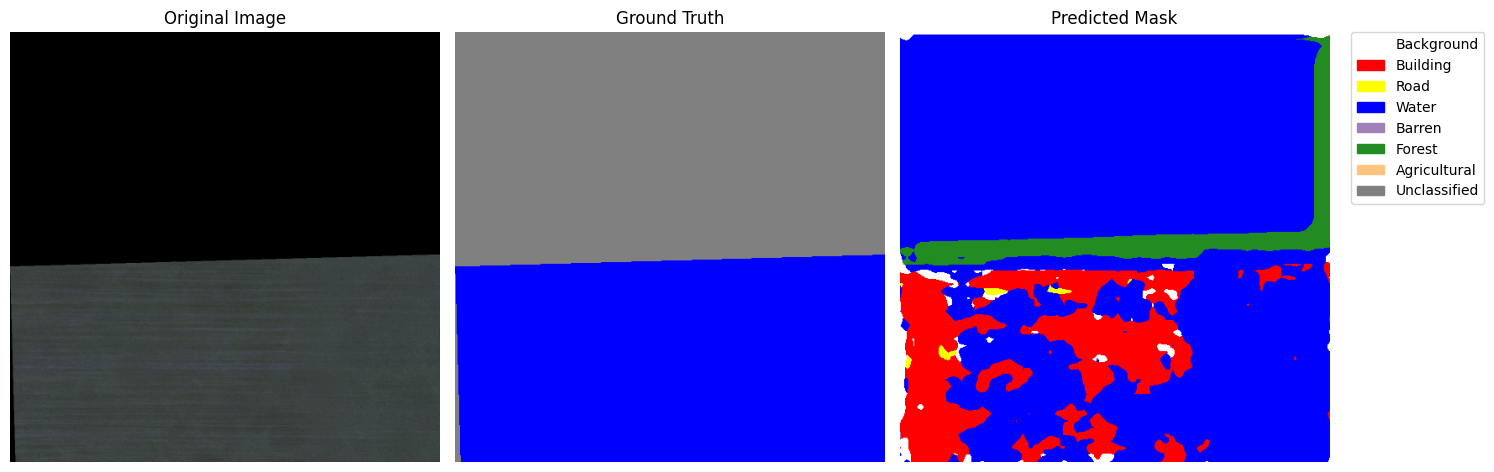

Starting epoch 2/20, LR = 0.00023872134540537494, DISC_LR = 0.0001
len of source_loader is 57, len of target_loader is 68. WARNING: make sure source is shorter than target, or modify code to fix early stopping


  0%|          | 0/57 [00:00<?, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.021498680114746 --- loss_adv at batch 0: 0.026107553392648697 --- 

  2%|▏         | 1/57 [00:03<03:35,  3.85s/it]

loss_disc at batch 0: 53.53765869140625


  9%|▉         | 5/57 [00:12<02:08,  2.48s/it]


[losses are unscaled] loss_pidnet at batch 5: 3.4582297801971436 --- loss_adv at batch 5: 0.005131694488227367 --- 

 11%|█         | 6/57 [00:13<01:44,  2.04s/it]

loss_disc at batch 5: 50.38002395629883


 18%|█▊        | 10/57 [00:21<01:26,  1.85s/it]


[losses are unscaled] loss_pidnet at batch 10: 3.488018751144409 --- loss_adv at batch 10: 0.019734716042876244 --- 

 19%|█▉        | 11/57 [00:23<01:27,  1.89s/it]

loss_disc at batch 10: 51.53917694091797


 26%|██▋       | 15/57 [00:32<01:36,  2.29s/it]


[losses are unscaled] loss_pidnet at batch 15: 2.920628786087036 --- loss_adv at batch 15: 0.00525360694155097 --- 

 28%|██▊       | 16/57 [00:33<01:22,  2.00s/it]

loss_disc at batch 15: 49.552085876464844


 35%|███▌      | 20/57 [00:40<01:03,  1.72s/it]


[losses are unscaled] loss_pidnet at batch 20: 3.9042177200317383 --- loss_adv at batch 20: 0.00879483763128519 --- 

 37%|███▋      | 21/57 [00:43<01:06,  1.83s/it]

loss_disc at batch 20: 50.080230712890625


 44%|████▍     | 25/57 [00:51<01:13,  2.30s/it]


[losses are unscaled] loss_pidnet at batch 25: 2.9732859134674072 --- loss_adv at batch 25: 0.04817444458603859 --- 

 46%|████▌     | 26/57 [00:52<01:01,  2.00s/it]

loss_disc at batch 25: 53.82334899902344


 53%|█████▎    | 30/57 [01:00<00:48,  1.80s/it]


[losses are unscaled] loss_pidnet at batch 30: 3.3191661834716797 --- loss_adv at batch 30: 0.0034978934563696384 --- 

 54%|█████▍    | 31/57 [01:02<00:49,  1.90s/it]

loss_disc at batch 30: 57.058902740478516


 61%|██████▏   | 35/57 [01:12<00:57,  2.61s/it]


[losses are unscaled] loss_pidnet at batch 35: 3.877373695373535 --- loss_adv at batch 35: 0.010285135358572006 --- 

 63%|██████▎   | 36/57 [01:13<00:45,  2.16s/it]

loss_disc at batch 35: 52.73740005493164


 70%|███████   | 40/57 [01:20<00:29,  1.74s/it]


[losses are unscaled] loss_pidnet at batch 40: 3.200477123260498 --- loss_adv at batch 40: 0.005631069652736187 --- 

 72%|███████▏  | 41/57 [01:21<00:25,  1.58s/it]

loss_disc at batch 40: 49.673519134521484


 79%|███████▉  | 45/57 [01:31<00:27,  2.27s/it]


[losses are unscaled] loss_pidnet at batch 45: 3.4257872104644775 --- loss_adv at batch 45: 0.007218618877232075 --- 

 81%|████████  | 46/57 [01:33<00:25,  2.35s/it]

loss_disc at batch 45: 48.285484313964844


 88%|████████▊ | 50/57 [01:40<00:12,  1.75s/it]


[losses are unscaled] loss_pidnet at batch 50: 3.008446216583252 --- loss_adv at batch 50: 0.004170018248260021 --- 

 89%|████████▉ | 51/57 [01:41<00:10,  1.71s/it]

loss_disc at batch 50: 48.524024963378906


 96%|█████████▋| 55/57 [01:51<00:04,  2.50s/it]


[losses are unscaled] loss_pidnet at batch 55: 2.9731085300445557 --- loss_adv at batch 55: 0.013958855532109737 --- 

 98%|█████████▊| 56/57 [01:53<00:02,  2.10s/it]

loss_disc at batch 55: 58.49028396606445


100%|██████████| 57/57 [01:54<00:00,  2.01s/it]
0it [00:00, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.1713428497314453 --- loss_adv at batch 0: 6.737233638763428 --- 

1it [00:03,  3.39s/it]

loss_disc at batch 0: 30.11433982849121


5it [00:11,  2.54s/it]


[losses are unscaled] loss_pidnet at batch 5: 1.9374704360961914 --- loss_adv at batch 5: 0.09861301630735397 --- 

6it [00:11,  1.85s/it]

loss_disc at batch 5: 28.863807678222656


10it [00:19,  1.64s/it]


[losses are unscaled] loss_pidnet at batch 10: 2.65692138671875 --- loss_adv at batch 10: 1.665496587753296 --- 

11it [00:22,  1.91s/it]

loss_disc at batch 10: 26.059772491455078


14it [00:25,  1.83s/it]


Epoch 2, Loss 465.196044921875
BEST MODEL ON VALIDATION SET, SAVING
best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth model succesfully saved on drive. loss went down to 465.196044921875
[EPOCH 02] Avg. Losses:
loss_complete        1.622639
loss_pidnet          0.204222
loss_adv             0.000947
loss_disc            3.204432
loss_pidnet_wtd      0.020422
loss_adv_wtd         0.000001
loss_disc_wtd        1.602216
Validation
[EPOCH 02] Avg. Losses:
loss_complete        0.875089
loss_pidnet          0.172303
loss_adv             0.189126
loss_disc            1.715339
loss_pidnet_wtd      0.017230
loss_adv_wtd         0.000189
loss_disc_wtd        0.857669


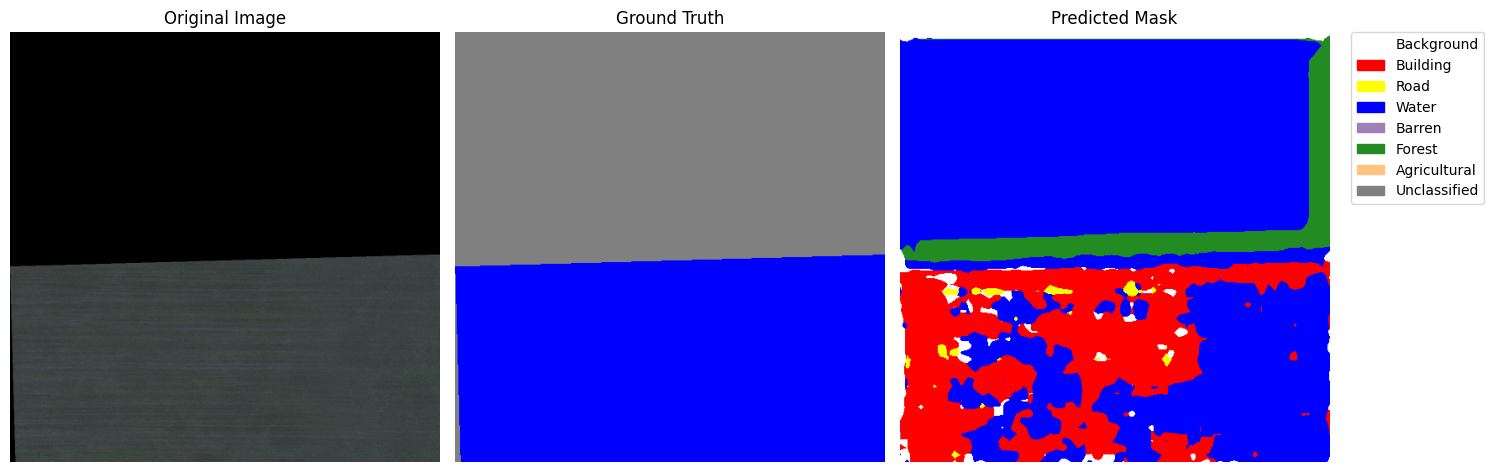

Starting epoch 3/20, LR = 0.00022738314402074057, DISC_LR = 0.0001
len of source_loader is 57, len of target_loader is 68. WARNING: make sure source is shorter than target, or modify code to fix early stopping


  0%|          | 0/57 [00:00<?, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 5.231846809387207 --- loss_adv at batch 0: 2.6203243732452393 --- 

  2%|▏         | 1/57 [00:04<04:01,  4.31s/it]

loss_disc at batch 0: 35.0544548034668


  9%|▉         | 5/57 [00:10<01:43,  1.99s/it]


[losses are unscaled] loss_pidnet at batch 5: 3.5132503509521484 --- loss_adv at batch 5: 2.6505489349365234 --- 

 11%|█         | 6/57 [00:12<01:28,  1.74s/it]

loss_disc at batch 5: 34.57111358642578


 18%|█▊        | 10/57 [00:22<01:42,  2.17s/it]


[losses are unscaled] loss_pidnet at batch 10: 3.9112730026245117 --- loss_adv at batch 10: 2.7430176734924316 --- 

 19%|█▉        | 11/57 [00:24<01:41,  2.22s/it]

loss_disc at batch 10: 32.657928466796875


 26%|██▋       | 15/57 [00:30<01:12,  1.72s/it]


[losses are unscaled] loss_pidnet at batch 15: 3.0319645404815674 --- loss_adv at batch 15: 4.4593658447265625 --- 

 28%|██▊       | 16/57 [00:31<01:04,  1.58s/it]

loss_disc at batch 15: 37.00777053833008


 35%|███▌      | 20/57 [00:41<01:16,  2.07s/it]


[losses are unscaled] loss_pidnet at batch 20: 2.932389259338379 --- loss_adv at batch 20: 2.635485887527466 --- 

 37%|███▋      | 21/57 [00:43<01:12,  2.02s/it]

loss_disc at batch 20: 34.13425827026367


 44%|████▍     | 25/57 [00:49<00:55,  1.72s/it]


[losses are unscaled] loss_pidnet at batch 25: 2.889578342437744 --- loss_adv at batch 25: 3.0099430084228516 --- 

 46%|████▌     | 26/57 [00:50<00:48,  1.56s/it]

loss_disc at batch 25: 36.75051498413086


 53%|█████▎    | 30/57 [01:00<00:56,  2.09s/it]


[losses are unscaled] loss_pidnet at batch 30: 2.824694871902466 --- loss_adv at batch 30: 2.902782678604126 --- 

 54%|█████▍    | 31/57 [01:02<00:53,  2.07s/it]

loss_disc at batch 30: 39.98982620239258


 61%|██████▏   | 35/57 [01:09<00:38,  1.76s/it]


[losses are unscaled] loss_pidnet at batch 35: 2.838442802429199 --- loss_adv at batch 35: 2.0608198642730713 --- 

 63%|██████▎   | 36/57 [01:10<00:33,  1.59s/it]

loss_disc at batch 35: 37.80292892456055


 70%|███████   | 40/57 [01:19<00:32,  1.94s/it]


[losses are unscaled] loss_pidnet at batch 40: 3.0803816318511963 --- loss_adv at batch 40: 3.5778298377990723 --- 

 72%|███████▏  | 41/57 [01:21<00:30,  1.88s/it]

loss_disc at batch 40: 35.738224029541016


 79%|███████▉  | 45/57 [01:28<00:21,  1.83s/it]


[losses are unscaled] loss_pidnet at batch 45: 3.4510273933410645 --- loss_adv at batch 45: 3.5823678970336914 --- 

 81%|████████  | 46/57 [01:29<00:18,  1.64s/it]

loss_disc at batch 45: 34.4275016784668


 88%|████████▊ | 50/57 [01:38<00:13,  1.92s/it]


[losses are unscaled] loss_pidnet at batch 50: 3.147695541381836 --- loss_adv at batch 50: 2.268669605255127 --- 

 89%|████████▉ | 51/57 [01:40<00:11,  1.87s/it]

loss_disc at batch 50: 34.94137954711914


 96%|█████████▋| 55/57 [01:46<00:03,  1.80s/it]


[losses are unscaled] loss_pidnet at batch 55: 3.3224411010742188 --- loss_adv at batch 55: 2.962399959564209 --- 

 98%|█████████▊| 56/57 [01:47<00:01,  1.62s/it]

loss_disc at batch 55: 35.41096878051758


100%|██████████| 57/57 [01:50<00:00,  1.94s/it]
0it [00:00, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 2.998659133911133 --- loss_adv at batch 0: 14.989179611206055 --- 

1it [00:03,  3.39s/it]

loss_disc at batch 0: 11.297860145568848


5it [00:08,  1.70s/it]


[losses are unscaled] loss_pidnet at batch 5: 1.8653162717819214 --- loss_adv at batch 5: 5.354391574859619 --- 

6it [00:09,  1.27s/it]

loss_disc at batch 5: 10.746095657348633


10it [00:17,  1.81s/it]


[losses are unscaled] loss_pidnet at batch 10: 2.4810359477996826 --- loss_adv at batch 10: 10.86270523071289 --- 

11it [00:20,  2.15s/it]

loss_disc at batch 10: 10.594009399414062


14it [00:24,  1.73s/it]


Epoch 3, Loss 351.63385009765625
BEST MODEL ON VALIDATION SET, SAVING
best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth model succesfully saved on drive. loss went down to 351.63385009765625
[EPOCH 03] Avg. Losses:
loss_complete        1.142071
loss_pidnet          0.206516
loss_adv             0.186883
loss_disc            2.242466
loss_pidnet_wtd      0.020652
loss_adv_wtd         0.000187
loss_disc_wtd        1.121233
Validation
[EPOCH 03] Avg. Losses:
loss_complete        0.352085
loss_pidnet          0.164037
loss_adv             0.735867
loss_disc            0.669890
loss_pidnet_wtd      0.016404
loss_adv_wtd         0.000736
loss_disc_wtd        0.334945


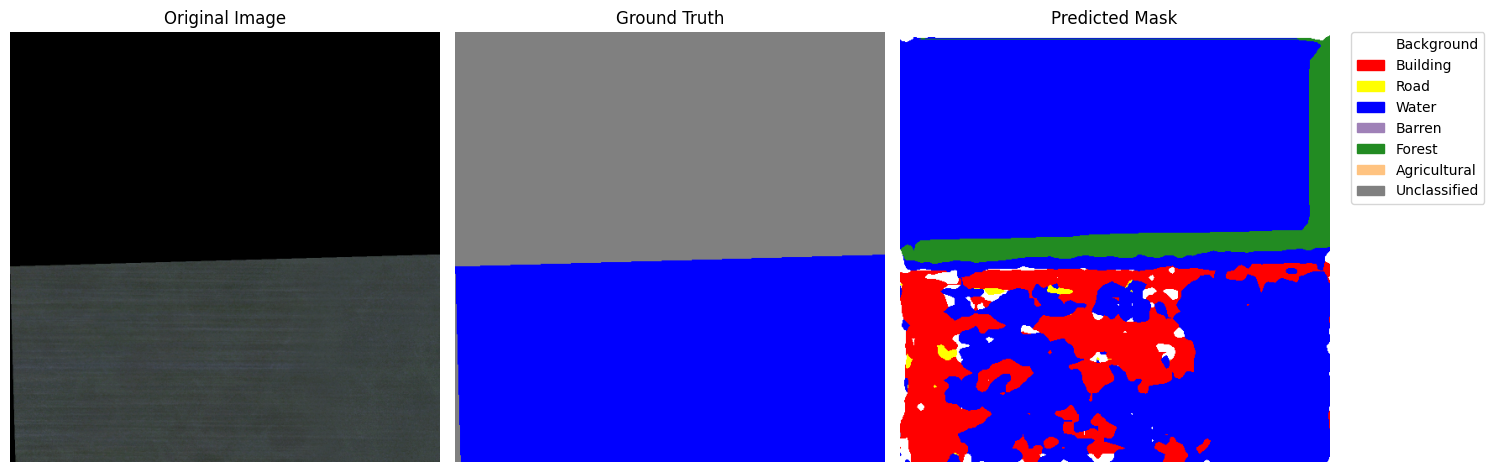

Starting epoch 4/20, LR = 0.00021598174307570477, DISC_LR = 0.0001
len of source_loader is 57, len of target_loader is 68. WARNING: make sure source is shorter than target, or modify code to fix early stopping


  0%|          | 0/57 [00:00<?, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.26008677482605 --- loss_adv at batch 0: 5.717617511749268 --- 

  2%|▏         | 1/57 [00:05<04:59,  5.35s/it]

loss_disc at batch 0: 14.388310432434082


  9%|▉         | 5/57 [00:13<02:04,  2.38s/it]


[losses are unscaled] loss_pidnet at batch 5: 4.16789436340332 --- loss_adv at batch 5: 6.05262565612793 --- 

 11%|█         | 6/57 [00:15<01:40,  1.97s/it]

loss_disc at batch 5: 16.2574405670166


 18%|█▊        | 10/57 [00:21<01:15,  1.60s/it]


[losses are unscaled] loss_pidnet at batch 10: 4.832330703735352 --- loss_adv at batch 10: 6.684443473815918 --- 

 19%|█▉        | 11/57 [00:24<01:35,  2.08s/it]

loss_disc at batch 10: 16.528587341308594


 26%|██▋       | 15/57 [00:32<01:24,  2.01s/it]


[losses are unscaled] loss_pidnet at batch 15: 3.0624194145202637 --- loss_adv at batch 15: 5.794966220855713 --- 

 28%|██▊       | 16/57 [00:33<01:12,  1.76s/it]

loss_disc at batch 15: 16.635860443115234


 35%|███▌      | 20/57 [00:40<00:59,  1.61s/it]


[losses are unscaled] loss_pidnet at batch 20: 2.905581474304199 --- loss_adv at batch 20: 5.947792053222656 --- 

 37%|███▋      | 21/57 [00:43<01:18,  2.17s/it]

loss_disc at batch 20: 16.81945037841797


 44%|████▍     | 25/57 [00:51<01:02,  1.96s/it]


[losses are unscaled] loss_pidnet at batch 25: 3.33909010887146 --- loss_adv at batch 25: 7.523856163024902 --- 

 46%|████▌     | 26/57 [00:53<00:53,  1.73s/it]

loss_disc at batch 25: 17.253087997436523


 53%|█████▎    | 30/57 [00:59<00:45,  1.68s/it]


[losses are unscaled] loss_pidnet at batch 30: 3.3275787830352783 --- loss_adv at batch 30: 6.140803337097168 --- 

 54%|█████▍    | 31/57 [01:02<00:50,  1.95s/it]

loss_disc at batch 30: 15.939291000366211


 61%|██████▏   | 35/57 [01:10<00:40,  1.84s/it]


[losses are unscaled] loss_pidnet at batch 35: 3.3138279914855957 --- loss_adv at batch 35: 5.8260393142700195 --- 

 63%|██████▎   | 36/57 [01:12<00:38,  1.85s/it]

loss_disc at batch 35: 17.13262176513672


 70%|███████   | 40/57 [01:18<00:28,  1.67s/it]


[losses are unscaled] loss_pidnet at batch 40: 3.2319397926330566 --- loss_adv at batch 40: 6.112273216247559 --- 

 72%|███████▏  | 41/57 [01:20<00:28,  1.76s/it]

loss_disc at batch 40: 18.100955963134766


 79%|███████▉  | 45/57 [01:28<00:21,  1.81s/it]


[losses are unscaled] loss_pidnet at batch 45: 3.583982229232788 --- loss_adv at batch 45: 6.664587020874023 --- 

 81%|████████  | 46/57 [01:30<00:19,  1.76s/it]

loss_disc at batch 45: 15.53721809387207


 88%|████████▊ | 50/57 [01:36<00:12,  1.78s/it]


[losses are unscaled] loss_pidnet at batch 50: 3.3759493827819824 --- loss_adv at batch 50: 6.070734024047852 --- 

 89%|████████▉ | 51/57 [01:38<00:10,  1.67s/it]

loss_disc at batch 50: 16.295129776000977


 96%|█████████▋| 55/57 [01:47<00:03,  1.87s/it]


[losses are unscaled] loss_pidnet at batch 55: 3.1826610565185547 --- loss_adv at batch 55: 5.474272727966309 --- 

 98%|█████████▊| 56/57 [01:49<00:01,  1.91s/it]

loss_disc at batch 55: 16.045717239379883


100%|██████████| 57/57 [01:50<00:00,  1.94s/it]
0it [00:00, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.02600359916687 --- loss_adv at batch 0: 32.04380798339844 --- 

1it [00:03,  3.71s/it]

loss_disc at batch 0: 21.419626235961914


5it [00:12,  2.60s/it]


[losses are unscaled] loss_pidnet at batch 5: 1.878514289855957 --- loss_adv at batch 5: 18.882740020751953 --- 

6it [00:13,  1.84s/it]

loss_disc at batch 5: 21.41881561279297


10it [00:18,  1.35s/it]


[losses are unscaled] loss_pidnet at batch 10: 2.456984043121338 --- loss_adv at batch 10: 24.210308074951172 --- 

11it [00:20,  1.64s/it]

loss_disc at batch 10: 21.41953468322754


14it [00:25,  1.79s/it]


Epoch 4, Loss 710.1504135131836
[EPOCH 04] Avg. Losses:
loss_complete        0.529092
loss_pidnet          0.208083
loss_adv             0.404724
loss_disc            1.015757
loss_pidnet_wtd      0.020808
loss_adv_wtd         0.000405
loss_disc_wtd        0.507879
Validation
[EPOCH 04] Avg. Losses:
loss_complete        0.687711
loss_pidnet          0.166958
loss_adv             1.664655
loss_disc            1.338701
loss_pidnet_wtd      0.016696
loss_adv_wtd         0.001665
loss_disc_wtd        0.669350


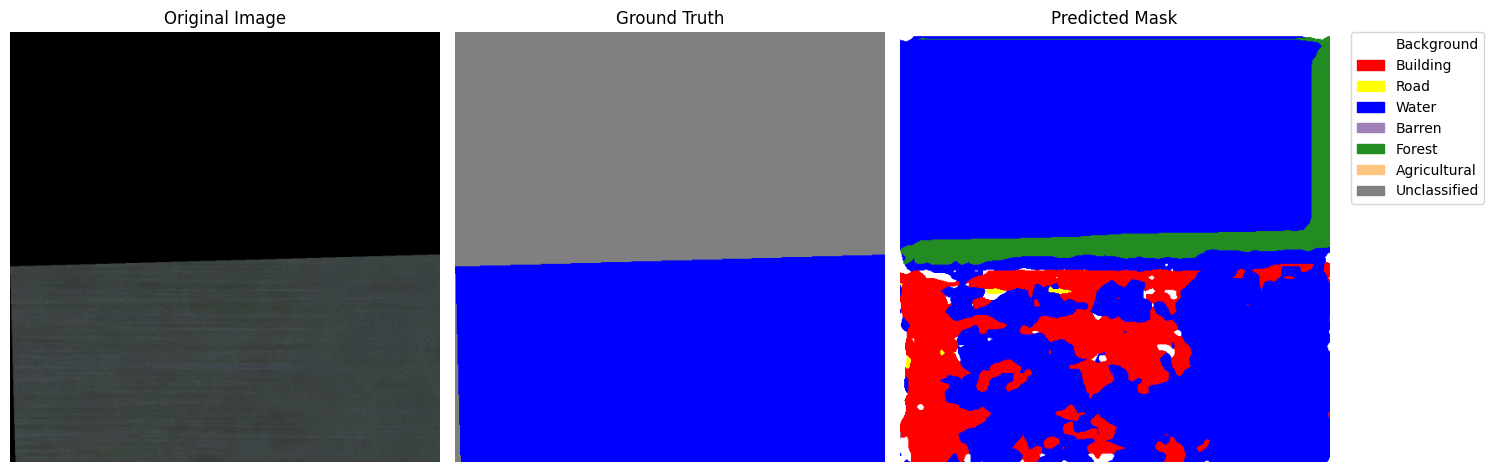

Starting epoch 5/20, LR = 0.00020451303651271462, DISC_LR = 0.0001
len of source_loader is 57, len of target_loader is 68. WARNING: make sure source is shorter than target, or modify code to fix early stopping


  0%|          | 0/57 [00:00<?, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.9357171058654785 --- loss_adv at batch 0: 21.856369018554688 --- 

  2%|▏         | 1/57 [00:03<03:40,  3.94s/it]

loss_disc at batch 0: 22.030319213867188


  9%|▉         | 5/57 [00:11<01:51,  2.15s/it]


[losses are unscaled] loss_pidnet at batch 5: 3.4323277473449707 --- loss_adv at batch 5: 25.387725830078125 --- 

 11%|█         | 6/57 [00:12<01:33,  1.83s/it]

loss_disc at batch 5: 22.086538314819336


 18%|█▊        | 10/57 [00:21<01:30,  1.92s/it]


[losses are unscaled] loss_pidnet at batch 10: 3.376561403274536 --- loss_adv at batch 10: 21.06817626953125 --- 

 19%|█▉        | 11/57 [00:23<01:33,  2.04s/it]

loss_disc at batch 10: 21.07138442993164


 26%|██▋       | 15/57 [00:31<01:33,  2.23s/it]


[losses are unscaled] loss_pidnet at batch 15: 3.5606887340545654 --- loss_adv at batch 15: 20.305809020996094 --- 

 28%|██▊       | 16/57 [00:32<01:19,  1.93s/it]

loss_disc at batch 15: 20.793399810791016


 35%|███▌      | 20/57 [00:41<01:06,  1.79s/it]


[losses are unscaled] loss_pidnet at batch 20: 2.973997116088867 --- loss_adv at batch 20: 19.83241844177246 --- 

 37%|███▋      | 21/57 [00:43<01:06,  1.86s/it]

loss_disc at batch 20: 21.036502838134766


 44%|████▍     | 25/57 [00:50<01:05,  2.06s/it]


[losses are unscaled] loss_pidnet at batch 25: 3.2649333477020264 --- loss_adv at batch 25: 20.568307876586914 --- 

 46%|████▌     | 26/57 [00:51<00:56,  1.81s/it]

loss_disc at batch 25: 21.883825302124023


 53%|█████▎    | 30/57 [00:59<00:47,  1.75s/it]


[losses are unscaled] loss_pidnet at batch 30: 3.02976655960083 --- loss_adv at batch 30: 21.576690673828125 --- 

 54%|█████▍    | 31/57 [01:02<00:48,  1.85s/it]

loss_disc at batch 30: 22.254716873168945


 61%|██████▏   | 35/57 [01:09<00:48,  2.18s/it]


[losses are unscaled] loss_pidnet at batch 35: 3.103861093521118 --- loss_adv at batch 35: 24.306243896484375 --- 

 63%|██████▎   | 36/57 [01:11<00:39,  1.89s/it]

loss_disc at batch 35: 21.97878074645996


 70%|███████   | 40/57 [01:18<00:29,  1.73s/it]


[losses are unscaled] loss_pidnet at batch 40: 3.3966193199157715 --- loss_adv at batch 40: 22.66098976135254 --- 

 72%|███████▏  | 41/57 [01:20<00:26,  1.64s/it]

loss_disc at batch 40: 20.875919342041016


 79%|███████▉  | 45/57 [01:27<00:24,  2.03s/it]


[losses are unscaled] loss_pidnet at batch 45: 2.9625296592712402 --- loss_adv at batch 45: 21.871654510498047 --- 

 81%|████████  | 46/57 [01:29<00:19,  1.79s/it]

loss_disc at batch 45: 19.80930519104004


 88%|████████▊ | 50/57 [01:37<00:12,  1.73s/it]


[losses are unscaled] loss_pidnet at batch 50: 3.1709601879119873 --- loss_adv at batch 50: 22.77975082397461 --- 

 89%|████████▉ | 51/57 [01:39<00:10,  1.82s/it]

loss_disc at batch 50: 23.21764373779297


 96%|█████████▋| 55/57 [01:47<00:04,  2.14s/it]


[losses are unscaled] loss_pidnet at batch 55: 2.7375144958496094 --- loss_adv at batch 55: 19.013916015625 --- 

 98%|█████████▊| 56/57 [01:48<00:01,  1.85s/it]

loss_disc at batch 55: 24.55794334411621


100%|██████████| 57/57 [01:51<00:00,  1.96s/it]
0it [00:00, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.1355552673339844 --- loss_adv at batch 0: 28.718643188476562 --- 

1it [00:03,  3.46s/it]

loss_disc at batch 0: 24.434465408325195


5it [00:08,  1.62s/it]


[losses are unscaled] loss_pidnet at batch 5: 1.9425222873687744 --- loss_adv at batch 5: 18.87051773071289 --- 

6it [00:09,  1.21s/it]

loss_disc at batch 5: 24.434473037719727


10it [00:18,  1.82s/it]


[losses are unscaled] loss_pidnet at batch 10: 2.59621524810791 --- loss_adv at batch 10: 21.41155433654785 --- 

11it [00:20,  2.04s/it]

loss_disc at batch 10: 24.434412002563477


14it [00:23,  1.71s/it]


Epoch 5, Loss 715.4533958435059
[EPOCH 05] Avg. Losses:
loss_complete        0.715079
loss_pidnet          0.204934
loss_adv             1.341983
loss_disc            1.386488
loss_pidnet_wtd      0.020493
loss_adv_wtd         0.001342
loss_disc_wtd        0.693244
Validation
[EPOCH 05] Avg. Losses:
loss_complete        0.782207
loss_pidnet          0.171239
loss_adv             1.495575
loss_disc            1.527174
loss_pidnet_wtd      0.017124
loss_adv_wtd         0.001496
loss_disc_wtd        0.763587


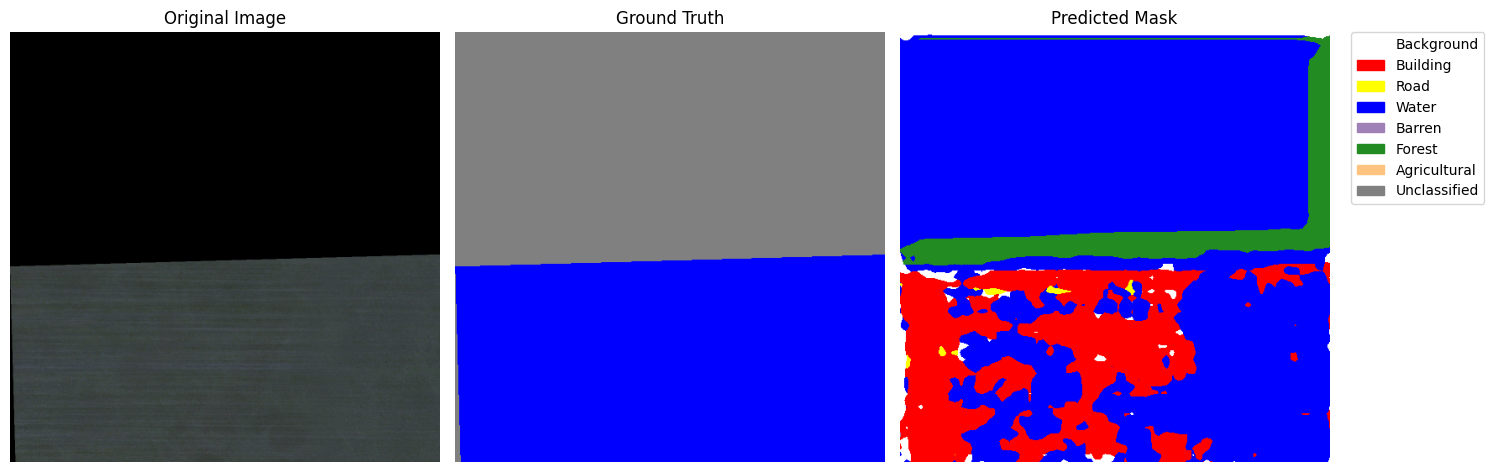

Starting epoch 6/20, LR = 0.00019297237668089264, DISC_LR = 0.0001
len of source_loader is 57, len of target_loader is 68. WARNING: make sure source is shorter than target, or modify code to fix early stopping


  0%|          | 0/57 [00:00<?, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.402768850326538 --- loss_adv at batch 0: 22.862998962402344 --- 

  2%|▏         | 1/57 [00:05<04:54,  5.25s/it]

loss_disc at batch 0: 24.756750106811523


  9%|▉         | 5/57 [00:14<02:05,  2.41s/it]


[losses are unscaled] loss_pidnet at batch 5: 3.0779495239257812 --- loss_adv at batch 5: 22.849994659423828 --- 

 11%|█         | 6/57 [00:15<01:40,  1.97s/it]

loss_disc at batch 5: 22.00942611694336


 18%|█▊        | 10/57 [00:21<01:16,  1.62s/it]


[losses are unscaled] loss_pidnet at batch 10: 4.35160493850708 --- loss_adv at batch 10: 20.85348129272461 --- 

 19%|█▉        | 11/57 [00:25<01:51,  2.42s/it]

loss_disc at batch 10: 22.12775230407715


 26%|██▋       | 15/57 [00:33<01:28,  2.11s/it]


[losses are unscaled] loss_pidnet at batch 15: 4.549819469451904 --- loss_adv at batch 15: 22.07126808166504 --- 

 28%|██▊       | 16/57 [00:34<01:14,  1.82s/it]

loss_disc at batch 15: 21.67195701599121


 35%|███▌      | 20/57 [00:41<01:00,  1.62s/it]


[losses are unscaled] loss_pidnet at batch 20: 3.189964532852173 --- loss_adv at batch 20: 26.88311767578125 --- 

 37%|███▋      | 21/57 [00:45<01:21,  2.27s/it]

loss_disc at batch 20: 24.363819122314453


 44%|████▍     | 25/57 [00:52<01:03,  1.99s/it]


[losses are unscaled] loss_pidnet at batch 25: 3.1408987045288086 --- loss_adv at batch 25: 21.124317169189453 --- 

 46%|████▌     | 26/57 [00:54<00:53,  1.73s/it]

loss_disc at batch 25: 22.653404235839844


 53%|█████▎    | 30/57 [01:00<00:42,  1.57s/it]


[losses are unscaled] loss_pidnet at batch 30: 3.327882766723633 --- loss_adv at batch 30: 21.074291229248047 --- 

 54%|█████▍    | 31/57 [01:04<00:59,  2.31s/it]

loss_disc at batch 30: 21.79949188232422


 61%|██████▏   | 35/57 [01:12<00:43,  1.97s/it]


[losses are unscaled] loss_pidnet at batch 35: 3.4801828861236572 --- loss_adv at batch 35: 21.240501403808594 --- 

 63%|██████▎   | 36/57 [01:13<00:36,  1.72s/it]

loss_disc at batch 35: 23.281593322753906


 70%|███████   | 40/57 [01:19<00:27,  1.60s/it]


[losses are unscaled] loss_pidnet at batch 40: 3.3552284240722656 --- loss_adv at batch 40: 22.813255310058594 --- 

 72%|███████▏  | 41/57 [01:23<00:36,  2.30s/it]

loss_disc at batch 40: 25.285526275634766


 79%|███████▉  | 45/57 [01:31<00:22,  1.91s/it]


[losses are unscaled] loss_pidnet at batch 45: 2.9882020950317383 --- loss_adv at batch 45: 20.53566551208496 --- 

 81%|████████  | 46/57 [01:32<00:18,  1.67s/it]

loss_disc at batch 45: 22.85019874572754


 88%|████████▊ | 50/57 [01:38<00:11,  1.64s/it]


[losses are unscaled] loss_pidnet at batch 50: 3.689138174057007 --- loss_adv at batch 50: 20.989089965820312 --- 

 89%|████████▉ | 51/57 [01:42<00:13,  2.31s/it]

loss_disc at batch 50: 20.980770111083984


 96%|█████████▋| 55/57 [01:50<00:03,  1.85s/it]


[losses are unscaled] loss_pidnet at batch 55: 3.204496383666992 --- loss_adv at batch 55: 20.94061851501465 --- 

 98%|█████████▊| 56/57 [01:51<00:01,  1.62s/it]

loss_disc at batch 55: 23.115306854248047


100%|██████████| 57/57 [01:52<00:00,  1.97s/it]
0it [00:00, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 2.9997639656066895 --- loss_adv at batch 0: 14.85588264465332 --- 

1it [00:03,  3.53s/it]

loss_disc at batch 0: 15.466792106628418


5it [00:12,  2.46s/it]


[losses are unscaled] loss_pidnet at batch 5: 1.866611361503601 --- loss_adv at batch 5: 12.701520919799805 --- 

6it [00:12,  1.75s/it]

loss_disc at batch 5: 15.475554466247559


10it [00:18,  1.32s/it]


[losses are unscaled] loss_pidnet at batch 10: 2.456667423248291 --- loss_adv at batch 10: 12.701225280761719 --- 

11it [00:20,  1.72s/it]

loss_disc at batch 10: 15.468055725097656


14it [00:25,  1.84s/it]


Epoch 6, Loss 445.88584899902344
[EPOCH 06] Avg. Losses:
loss_complete        0.748161
loss_pidnet          0.208008
loss_adv             1.382384
loss_disc            1.451956
loss_pidnet_wtd      0.020801
loss_adv_wtd         0.001382
loss_disc_wtd        0.725978
Validation
[EPOCH 06] Avg. Losses:
loss_complete        0.500902
loss_pidnet          0.162781
loss_adv             0.860253
loss_disc            0.967528
loss_pidnet_wtd      0.016278
loss_adv_wtd         0.000860
loss_disc_wtd        0.483764


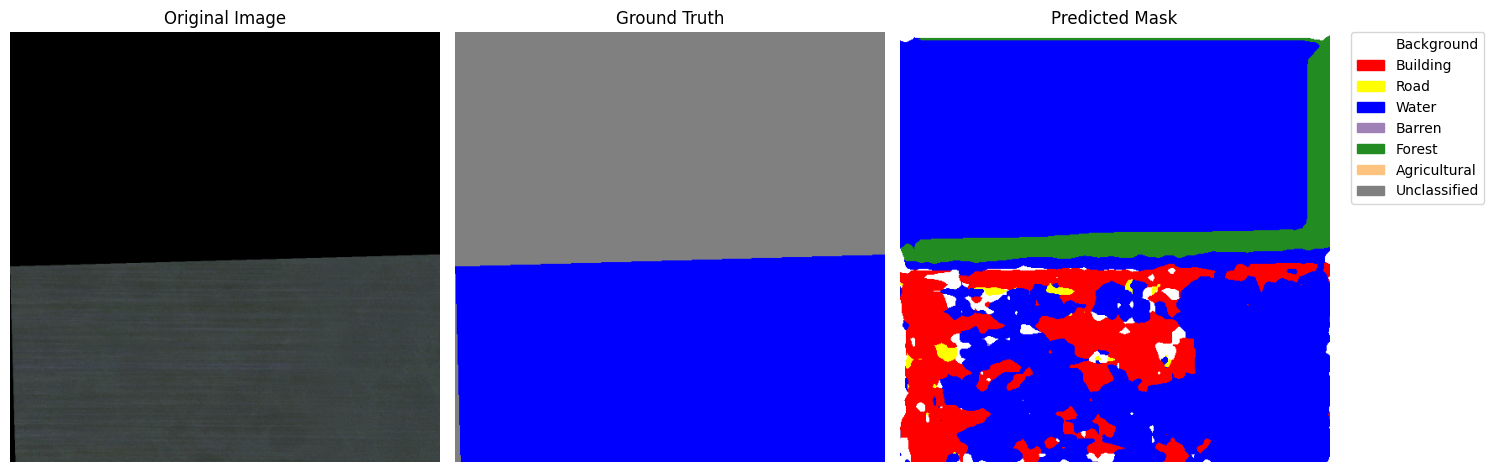

Starting epoch 7/20, LR = 0.00018135446173430498, DISC_LR = 0.0001
len of source_loader is 57, len of target_loader is 68. WARNING: make sure source is shorter than target, or modify code to fix early stopping


  0%|          | 0/57 [00:00<?, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.2737298011779785 --- loss_adv at batch 0: 15.402738571166992 --- 

  2%|▏         | 1/57 [00:04<03:44,  4.01s/it]

loss_disc at batch 0: 14.038223266601562


  9%|▉         | 5/57 [00:11<01:55,  2.22s/it]


[losses are unscaled] loss_pidnet at batch 5: 3.38523268699646 --- loss_adv at batch 5: 14.758696556091309 --- 

 11%|█         | 6/57 [00:12<01:36,  1.89s/it]

loss_disc at batch 5: 14.275589942932129


 18%|█▊        | 10/57 [00:21<01:26,  1.85s/it]


[losses are unscaled] loss_pidnet at batch 10: 3.3398070335388184 --- loss_adv at batch 10: 13.360855102539062 --- 

 19%|█▉        | 11/57 [00:23<01:26,  1.89s/it]

loss_disc at batch 10: 15.61307430267334


 26%|██▋       | 15/57 [00:30<01:24,  2.02s/it]


[losses are unscaled] loss_pidnet at batch 15: 3.145972490310669 --- loss_adv at batch 15: 13.768497467041016 --- 

 28%|██▊       | 16/57 [00:31<01:12,  1.78s/it]

loss_disc at batch 15: 14.399201393127441


 35%|███▌      | 20/57 [00:40<01:08,  1.84s/it]


[losses are unscaled] loss_pidnet at batch 20: 3.014112710952759 --- loss_adv at batch 20: 14.140188217163086 --- 

 37%|███▋      | 21/57 [00:42<01:07,  1.87s/it]

loss_disc at batch 20: 15.089984893798828


 44%|████▍     | 25/57 [00:50<01:09,  2.19s/it]


[losses are unscaled] loss_pidnet at batch 25: 3.4017577171325684 --- loss_adv at batch 25: 13.809881210327148 --- 

 46%|████▌     | 26/57 [00:51<00:58,  1.90s/it]

loss_disc at batch 25: 14.959874153137207


 53%|█████▎    | 30/57 [00:59<00:47,  1.76s/it]


[losses are unscaled] loss_pidnet at batch 30: 2.934641122817993 --- loss_adv at batch 30: 14.350873947143555 --- 

 54%|█████▍    | 31/57 [01:01<00:47,  1.83s/it]

loss_disc at batch 30: 14.338887214660645


 61%|██████▏   | 35/57 [01:09<00:46,  2.11s/it]


[losses are unscaled] loss_pidnet at batch 35: 2.9255616664886475 --- loss_adv at batch 35: 13.470930099487305 --- 

 63%|██████▎   | 36/57 [01:10<00:38,  1.83s/it]

loss_disc at batch 35: 14.391647338867188


 70%|███████   | 40/57 [01:19<00:31,  1.83s/it]


[losses are unscaled] loss_pidnet at batch 40: 3.3674569129943848 --- loss_adv at batch 40: 15.484644889831543 --- 

 72%|███████▏  | 41/57 [01:20<00:29,  1.82s/it]

loss_disc at batch 40: 15.550766944885254


 79%|███████▉  | 45/57 [01:29<00:26,  2.24s/it]


[losses are unscaled] loss_pidnet at batch 45: 3.198641777038574 --- loss_adv at batch 45: 14.604022026062012 --- 

 81%|████████  | 46/57 [01:30<00:21,  1.92s/it]

loss_disc at batch 45: 14.666749000549316


 88%|████████▊ | 50/57 [01:37<00:11,  1.70s/it]


[losses are unscaled] loss_pidnet at batch 50: 4.1822004318237305 --- loss_adv at batch 50: 14.295159339904785 --- 

 89%|████████▉ | 51/57 [01:39<00:10,  1.78s/it]

loss_disc at batch 50: 15.588854789733887


 96%|█████████▋| 55/57 [01:46<00:03,  1.85s/it]


[losses are unscaled] loss_pidnet at batch 55: 2.88061785697937 --- loss_adv at batch 55: 14.496541023254395 --- 

 98%|█████████▊| 56/57 [01:47<00:01,  1.66s/it]

loss_disc at batch 55: 14.423235893249512


100%|██████████| 57/57 [01:51<00:00,  1.95s/it]
0it [00:00, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.040087938308716 --- loss_adv at batch 0: 4.248086452484131 --- 

1it [00:03,  3.45s/it]

loss_disc at batch 0: 6.465959548950195


5it [00:08,  1.56s/it]


[losses are unscaled] loss_pidnet at batch 5: 1.8912739753723145 --- loss_adv at batch 5: 4.227086067199707 --- 

6it [00:09,  1.25s/it]

loss_disc at batch 5: 4.713426113128662


10it [00:17,  1.77s/it]


[losses are unscaled] loss_pidnet at batch 10: 2.4871699810028076 --- loss_adv at batch 10: 3.529437303543091 --- 

11it [00:20,  2.11s/it]

loss_disc at batch 10: 5.838347434997559


14it [00:23,  1.67s/it]


Epoch 7, Loss 172.2629804611206
BEST MODEL ON VALIDATION SET, SAVING
best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth model succesfully saved on drive. loss went down to 172.2629804611206
[EPOCH 07] Avg. Losses:
loss_complete        0.480042
loss_pidnet          0.204536
loss_adv             0.893967
loss_disc            0.917390
loss_pidnet_wtd      0.020454
loss_adv_wtd         0.000894
loss_disc_wtd        0.458695
Validation
[EPOCH 07] Avg. Losses:
loss_complete        0.198880
loss_pidnet          0.167061
loss_adv             0.238099
loss_disc            0.363871
loss_pidnet_wtd      0.016706
loss_adv_wtd         0.000238
loss_disc_wtd        0.181936


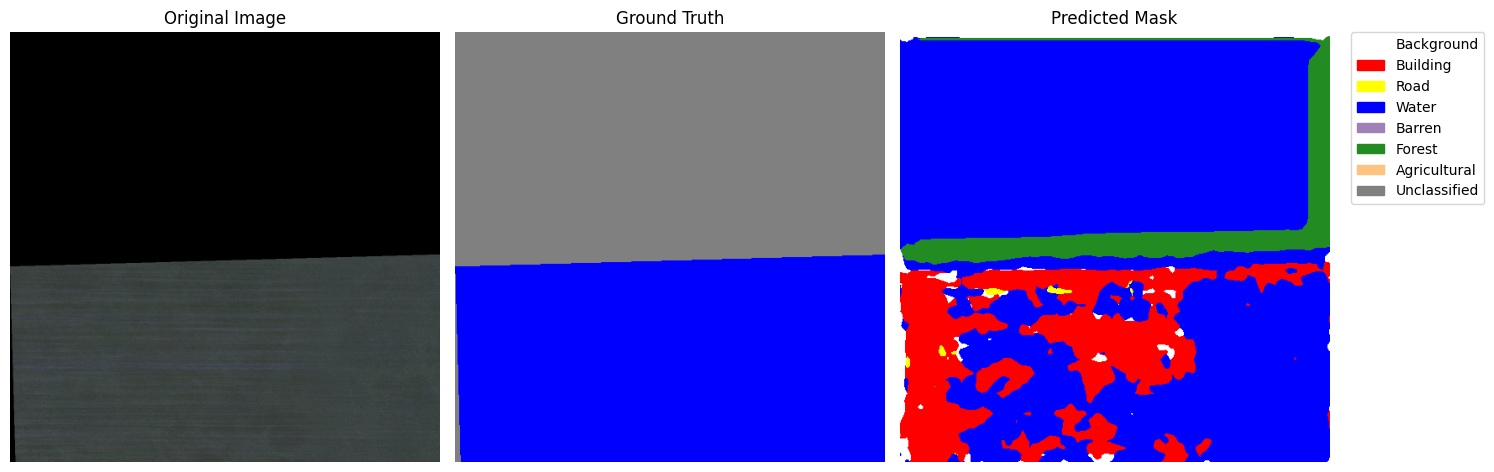

Starting epoch 8/20, LR = 0.00016965318981453125, DISC_LR = 0.0001
len of source_loader is 57, len of target_loader is 68. WARNING: make sure source is shorter than target, or modify code to fix early stopping


  0%|          | 0/57 [00:00<?, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.328834056854248 --- loss_adv at batch 0: 4.2872419357299805 --- 

  2%|▏         | 1/57 [00:05<05:03,  5.42s/it]

loss_disc at batch 0: 5.595986366271973


  9%|▉         | 5/57 [00:14<02:08,  2.48s/it]


[losses are unscaled] loss_pidnet at batch 5: 3.4530293941497803 --- loss_adv at batch 5: 3.864818572998047 --- 

 11%|█         | 6/57 [00:15<01:43,  2.02s/it]

loss_disc at batch 5: 5.372732162475586


 18%|█▊        | 10/57 [00:21<01:17,  1.65s/it]


[losses are unscaled] loss_pidnet at batch 10: 3.491957902908325 --- loss_adv at batch 10: 3.9038448333740234 --- 

 19%|█▉        | 11/57 [00:25<01:41,  2.20s/it]

loss_disc at batch 10: 5.108455657958984


 26%|██▋       | 15/57 [00:33<01:26,  2.05s/it]


[losses are unscaled] loss_pidnet at batch 15: 3.4419074058532715 --- loss_adv at batch 15: 3.901942729949951 --- 

 28%|██▊       | 16/57 [00:34<01:13,  1.80s/it]

loss_disc at batch 15: 5.298951148986816


 35%|███▌      | 20/57 [00:41<00:59,  1.62s/it]


[losses are unscaled] loss_pidnet at batch 20: 3.199151039123535 --- loss_adv at batch 20: 4.151291370391846 --- 

 37%|███▋      | 21/57 [00:45<01:19,  2.22s/it]

loss_disc at batch 20: 5.439243316650391


 44%|████▍     | 25/57 [00:52<01:01,  1.92s/it]


[losses are unscaled] loss_pidnet at batch 25: 3.4865167140960693 --- loss_adv at batch 25: 4.198838233947754 --- 

 46%|████▌     | 26/57 [00:53<00:52,  1.68s/it]

loss_disc at batch 25: 5.392037868499756


 53%|█████▎    | 30/57 [01:00<00:42,  1.57s/it]


[losses are unscaled] loss_pidnet at batch 30: 3.3307130336761475 --- loss_adv at batch 30: 3.7299537658691406 --- 

 54%|█████▍    | 31/57 [01:03<00:57,  2.21s/it]

loss_disc at batch 30: 5.068366527557373


 61%|██████▏   | 35/57 [01:11<00:41,  1.90s/it]


[losses are unscaled] loss_pidnet at batch 35: 3.743875741958618 --- loss_adv at batch 35: 4.230432510375977 --- 

 63%|██████▎   | 36/57 [01:12<00:34,  1.66s/it]

loss_disc at batch 35: 5.383180141448975


 70%|███████   | 40/57 [01:18<00:27,  1.62s/it]


[losses are unscaled] loss_pidnet at batch 40: 3.512329578399658 --- loss_adv at batch 40: 3.806208610534668 --- 

 72%|███████▏  | 41/57 [01:22<00:37,  2.33s/it]

loss_disc at batch 40: 4.961606979370117


 79%|███████▉  | 45/57 [01:30<00:22,  1.91s/it]


[losses are unscaled] loss_pidnet at batch 45: 3.036264181137085 --- loss_adv at batch 45: 3.9709830284118652 --- 

 81%|████████  | 46/57 [01:31<00:18,  1.67s/it]

loss_disc at batch 45: 5.233323574066162


 88%|████████▊ | 50/57 [01:37<00:11,  1.64s/it]


[losses are unscaled] loss_pidnet at batch 50: 3.0123181343078613 --- loss_adv at batch 50: 4.785647392272949 --- 

 89%|████████▉ | 51/57 [01:41<00:13,  2.29s/it]

loss_disc at batch 50: 5.205447673797607


 96%|█████████▋| 55/57 [01:48<00:03,  1.78s/it]


[losses are unscaled] loss_pidnet at batch 55: 3.186319351196289 --- loss_adv at batch 55: 4.177863121032715 --- 

 98%|█████████▊| 56/57 [01:49<00:01,  1.58s/it]

loss_disc at batch 55: 5.681614875793457


100%|██████████| 57/57 [01:50<00:00,  1.94s/it]
0it [00:00, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.0393097400665283 --- loss_adv at batch 0: 0.15377065539360046 --- 

1it [00:03,  3.79s/it]

loss_disc at batch 0: 10.24078369140625


5it [00:12,  2.41s/it]


[losses are unscaled] loss_pidnet at batch 5: 1.8625348806381226 --- loss_adv at batch 5: 0.16547279059886932 --- 

6it [00:12,  1.72s/it]

loss_disc at batch 5: 5.986375331878662


10it [00:18,  1.36s/it]


[losses are unscaled] loss_pidnet at batch 10: 2.4928152561187744 --- loss_adv at batch 10: 0.11775544285774231 --- 

11it [00:20,  1.71s/it]

loss_disc at batch 10: 8.634779930114746


14it [00:25,  1.81s/it]


Epoch 8, Loss 166.3020534515381
BEST MODEL ON VALIDATION SET, SAVING
best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth model succesfully saved on drive. loss went down to 166.3020534515381
[EPOCH 08] Avg. Losses:
loss_complete        0.190893
loss_pidnet          0.203185
loss_adv             0.251640
loss_disc            0.340645
loss_pidnet_wtd      0.020318
loss_adv_wtd         0.000252
loss_disc_wtd        0.170323
Validation
[EPOCH 08] Avg. Losses:
loss_complete        0.301388
loss_pidnet          0.165191
loss_adv             0.007506
loss_disc            0.569723
loss_pidnet_wtd      0.016519
loss_adv_wtd         0.000008
loss_disc_wtd        0.284862


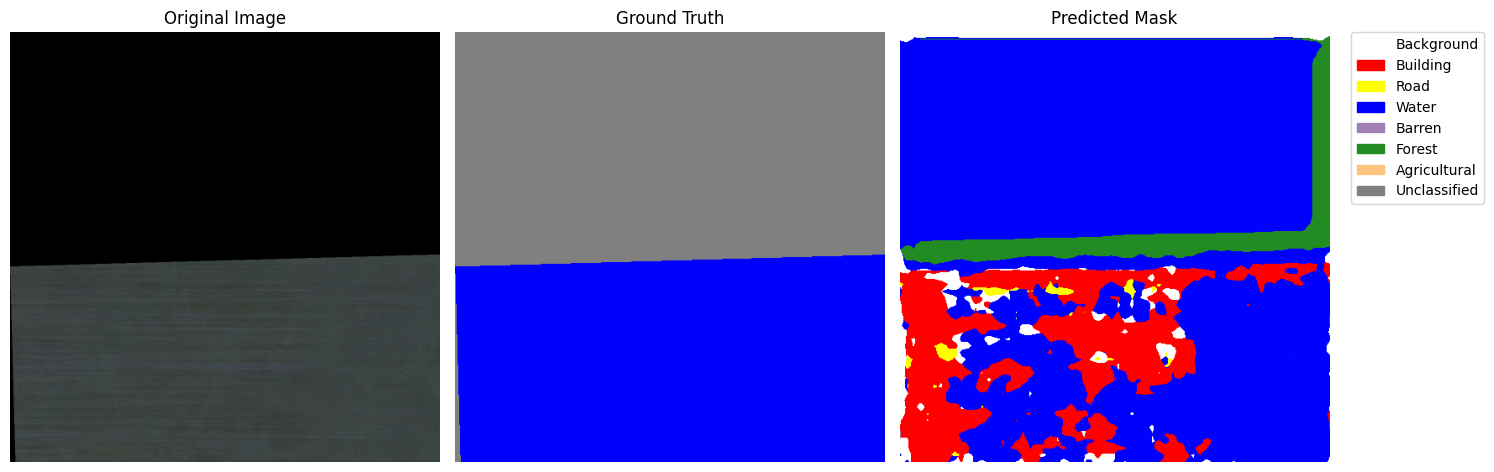

Starting epoch 9/20, LR = 0.00015786146687233883, DISC_LR = 0.0001
len of source_loader is 57, len of target_loader is 68. WARNING: make sure source is shorter than target, or modify code to fix early stopping


  0%|          | 0/57 [00:00<?, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.2928669452667236 --- loss_adv at batch 0: 0.1339888721704483 --- 

  2%|▏         | 1/57 [00:03<03:39,  3.92s/it]

loss_disc at batch 0: 7.591734886169434


  9%|▉         | 5/57 [00:11<02:02,  2.36s/it]


[losses are unscaled] loss_pidnet at batch 5: 3.391497850418091 --- loss_adv at batch 5: 0.0988282561302185 --- 

 11%|█         | 6/57 [00:12<01:40,  1.97s/it]

loss_disc at batch 5: 8.256562232971191


 18%|█▊        | 10/57 [00:21<01:27,  1.87s/it]


[losses are unscaled] loss_pidnet at batch 10: 3.3840746879577637 --- loss_adv at batch 10: 0.12000354379415512 --- 

 19%|█▉        | 11/57 [00:23<01:30,  1.97s/it]

loss_disc at batch 10: 8.149590492248535


 26%|██▋       | 15/57 [00:31<01:24,  2.02s/it]


[losses are unscaled] loss_pidnet at batch 15: 3.304136276245117 --- loss_adv at batch 15: 0.11335525661706924 --- 

 28%|██▊       | 16/57 [00:32<01:13,  1.79s/it]

loss_disc at batch 15: 11.20439338684082


 35%|███▌      | 20/57 [00:41<01:09,  1.87s/it]


[losses are unscaled] loss_pidnet at batch 20: 2.8749160766601562 --- loss_adv at batch 20: 0.12352468818426132 --- 

 37%|███▋      | 21/57 [00:42<01:06,  1.86s/it]

loss_disc at batch 20: 9.102774620056152


 44%|████▍     | 25/57 [00:50<01:05,  2.04s/it]


[losses are unscaled] loss_pidnet at batch 25: 3.07247257232666 --- loss_adv at batch 25: 0.10866372287273407 --- 

 46%|████▌     | 26/57 [00:51<00:55,  1.80s/it]

loss_disc at batch 25: 8.709312438964844


 53%|█████▎    | 30/57 [00:59<00:48,  1.79s/it]


[losses are unscaled] loss_pidnet at batch 30: 2.9386391639709473 --- loss_adv at batch 30: 0.13193322718143463 --- 

 54%|█████▍    | 31/57 [01:01<00:47,  1.83s/it]

loss_disc at batch 30: 7.93781042098999


 61%|██████▏   | 35/57 [01:08<00:42,  1.91s/it]


[losses are unscaled] loss_pidnet at batch 35: 3.525541067123413 --- loss_adv at batch 35: 0.10901470482349396 --- 

 63%|██████▎   | 36/57 [01:10<00:37,  1.80s/it]

loss_disc at batch 35: 9.44666862487793


 70%|███████   | 40/57 [01:18<00:30,  1.82s/it]


[losses are unscaled] loss_pidnet at batch 40: 3.3676400184631348 --- loss_adv at batch 40: 0.12250328063964844 --- 

 72%|███████▏  | 41/57 [01:20<00:29,  1.84s/it]

loss_disc at batch 40: 8.679361343383789


 79%|███████▉  | 45/57 [01:26<00:20,  1.70s/it]


[losses are unscaled] loss_pidnet at batch 45: 3.2104079723358154 --- loss_adv at batch 45: 0.13644257187843323 --- 

 81%|████████  | 46/57 [01:29<00:22,  2.03s/it]

loss_disc at batch 45: 8.993000984191895


 88%|████████▊ | 50/57 [01:37<00:12,  1.78s/it]


[losses are unscaled] loss_pidnet at batch 50: 3.0244476795196533 --- loss_adv at batch 50: 0.12725216150283813 --- 

 89%|████████▉ | 51/57 [01:39<00:10,  1.79s/it]

loss_disc at batch 50: 8.653017044067383


 96%|█████████▋| 55/57 [01:46<00:03,  1.89s/it]


[losses are unscaled] loss_pidnet at batch 55: 2.8514761924743652 --- loss_adv at batch 55: 0.12125550210475922 --- 

 98%|█████████▊| 56/57 [01:47<00:01,  1.69s/it]

loss_disc at batch 55: 9.499692916870117


100%|██████████| 57/57 [01:50<00:00,  1.94s/it]
0it [00:00, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.114326000213623 --- loss_adv at batch 0: 0.025519434362649918 --- 

1it [00:03,  3.14s/it]

loss_disc at batch 0: 16.405912399291992


5it [00:08,  1.76s/it]


[losses are unscaled] loss_pidnet at batch 5: 1.896295189857483 --- loss_adv at batch 5: 0.024636313319206238 --- 

6it [00:09,  1.29s/it]

loss_disc at batch 5: 9.59760570526123


10it [00:18,  1.84s/it]


[losses are unscaled] loss_pidnet at batch 10: 2.538092613220215 --- loss_adv at batch 10: 0.021116606891155243 --- 

11it [00:21,  2.10s/it]

loss_disc at batch 10: 13.254862785339355


14it [00:24,  1.73s/it]


Epoch 9, Loss 237.02910614013672
[EPOCH 09] Avg. Losses:
loss_complete        0.288414
loss_pidnet          0.203271
loss_adv             0.007627
loss_disc            0.536158
loss_pidnet_wtd      0.020327
loss_adv_wtd         0.000008
loss_disc_wtd        0.268079
Validation
[EPOCH 09] Avg. Losses:
loss_complete        0.460684
loss_pidnet          0.169537
loss_adv             0.001170
loss_disc            0.887459
loss_pidnet_wtd      0.016954
loss_adv_wtd         0.000001
loss_disc_wtd        0.443730


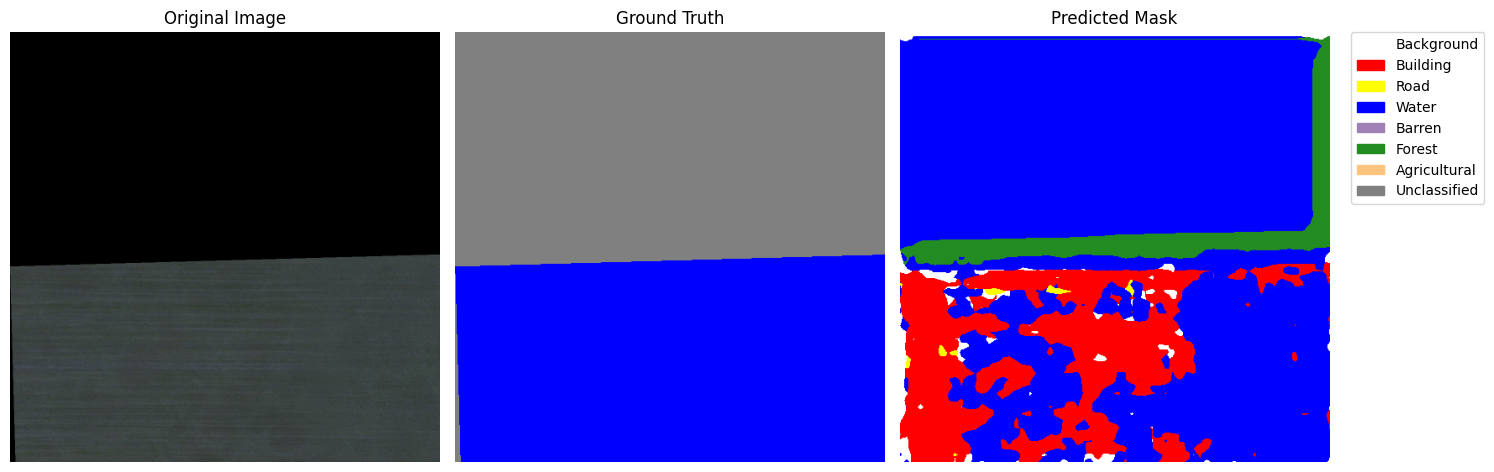

Starting epoch 10/20, LR = 0.00014597094822999508, DISC_LR = 0.0001
len of source_loader is 57, len of target_loader is 68. WARNING: make sure source is shorter than target, or modify code to fix early stopping


  0%|          | 0/57 [00:00<?, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.0749144554138184 --- loss_adv at batch 0: 0.020372165367007256 --- 

  2%|▏         | 1/57 [00:05<04:41,  5.03s/it]

loss_disc at batch 0: 11.926509857177734


  9%|▉         | 5/57 [00:13<02:05,  2.41s/it]


[losses are unscaled] loss_pidnet at batch 5: 2.8096163272857666 --- loss_adv at batch 5: 0.026308858767151833 --- 

 11%|█         | 6/57 [00:14<01:41,  1.98s/it]

loss_disc at batch 5: 11.449934959411621


 18%|█▊        | 10/57 [00:21<01:18,  1.67s/it]


[losses are unscaled] loss_pidnet at batch 10: 3.1235179901123047 --- loss_adv at batch 10: 0.02088937908411026 --- 

 19%|█▉        | 11/57 [00:23<01:25,  1.86s/it]

loss_disc at batch 10: 12.102267265319824


 26%|██▋       | 15/57 [00:32<01:26,  2.05s/it]


[losses are unscaled] loss_pidnet at batch 15: 3.439927577972412 --- loss_adv at batch 15: 0.01973646879196167 --- 

 28%|██▊       | 16/57 [00:33<01:17,  1.88s/it]

loss_disc at batch 15: 11.398233413696289


 35%|███▌      | 20/57 [00:40<01:01,  1.67s/it]


[losses are unscaled] loss_pidnet at batch 20: 3.4269967079162598 --- loss_adv at batch 20: 0.019614795222878456 --- 

 37%|███▋      | 21/57 [00:42<01:04,  1.78s/it]

loss_disc at batch 20: 12.88766098022461


 44%|████▍     | 25/57 [00:52<01:10,  2.19s/it]


[losses are unscaled] loss_pidnet at batch 25: 2.926816463470459 --- loss_adv at batch 25: 0.021217506378889084 --- 

 46%|████▌     | 26/57 [00:53<01:00,  1.96s/it]

loss_disc at batch 25: 11.718401908874512


 53%|█████▎    | 30/57 [00:59<00:43,  1.62s/it]


[losses are unscaled] loss_pidnet at batch 30: 3.3730363845825195 --- loss_adv at batch 30: 0.017648108303546906 --- 

 54%|█████▍    | 31/57 [01:01<00:45,  1.76s/it]

loss_disc at batch 30: 11.404433250427246


 61%|██████▏   | 35/57 [01:11<00:47,  2.16s/it]


[losses are unscaled] loss_pidnet at batch 35: 3.3349392414093018 --- loss_adv at batch 35: 0.021772414445877075 --- 

 63%|██████▎   | 36/57 [01:12<00:39,  1.90s/it]

loss_disc at batch 35: 11.588506698608398


 70%|███████   | 40/57 [01:18<00:27,  1.62s/it]


[losses are unscaled] loss_pidnet at batch 40: 3.905132293701172 --- loss_adv at batch 40: 0.018911397084593773 --- 

 72%|███████▏  | 41/57 [01:20<00:25,  1.62s/it]

loss_disc at batch 40: 12.319671630859375


 79%|███████▉  | 45/57 [01:29<00:24,  2.02s/it]


[losses are unscaled] loss_pidnet at batch 45: 3.178558349609375 --- loss_adv at batch 45: 0.024068109691143036 --- 

 81%|████████  | 46/57 [01:31<00:21,  1.99s/it]

loss_disc at batch 45: 12.393803596496582


 88%|████████▊ | 50/57 [01:37<00:11,  1.70s/it]


[losses are unscaled] loss_pidnet at batch 50: 3.2123374938964844 --- loss_adv at batch 50: 0.02219795063138008 --- 

 89%|████████▉ | 51/57 [01:38<00:09,  1.53s/it]

loss_disc at batch 50: 12.236393928527832


 96%|█████████▋| 55/57 [01:48<00:04,  2.09s/it]


[losses are unscaled] loss_pidnet at batch 55: 3.115673780441284 --- loss_adv at batch 55: 0.015485499054193497 --- 

 98%|█████████▊| 56/57 [01:50<00:02,  2.09s/it]

loss_disc at batch 55: 14.424741744995117


100%|██████████| 57/57 [01:51<00:00,  1.96s/it]
0it [00:00, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.037550926208496 --- 

1it [00:03,  3.74s/it]

loss_adv at batch 0: 0.02592107094824314 --- loss_disc at batch 0: 13.308002471923828


5it [00:12,  2.72s/it]


[losses are unscaled] loss_pidnet at batch 5: 1.8675382137298584 --- loss_adv at batch 5: 0.019501730799674988 --- 

6it [00:13,  1.95s/it]

loss_disc at batch 5: 9.568904876708984


10it [00:18,  1.35s/it]


[losses are unscaled] loss_pidnet at batch 10: 2.482363700866699 --- loss_adv at batch 10: 0.015882983803749084 --- 

11it [00:21,  1.72s/it]

loss_disc at batch 10: 12.164924621582031


14it [00:24,  1.77s/it]


Epoch 10, Loss 215.25299072265625
[EPOCH 10] Avg. Losses:
loss_complete        0.405948
loss_pidnet          0.204461
loss_adv             0.001258
loss_disc            0.771002
loss_pidnet_wtd      0.020446
loss_adv_wtd         0.000001
loss_disc_wtd        0.385501
Validation
[EPOCH 10] Avg. Losses:
loss_complete        0.413822
loss_pidnet          0.165391
loss_adv             0.000997
loss_disc            0.794563
loss_pidnet_wtd      0.016539
loss_adv_wtd         0.000001
loss_disc_wtd        0.397282


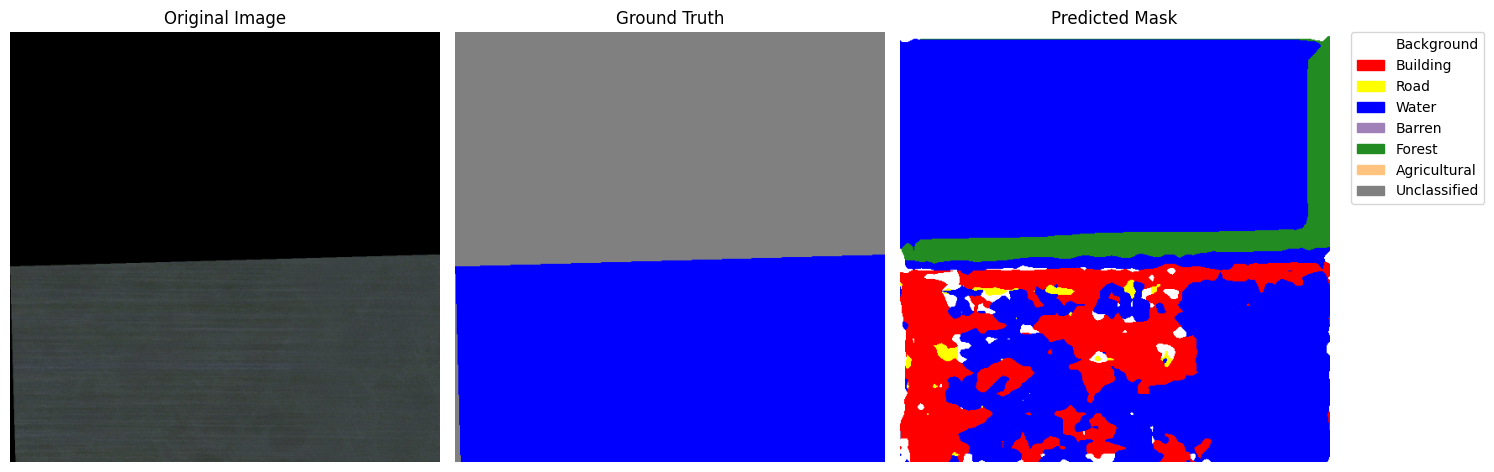

Starting epoch 11/20, LR = 0.00013397168281703665, DISC_LR = 0.0001
len of source_loader is 57, len of target_loader is 68. WARNING: make sure source is shorter than target, or modify code to fix early stopping


  0%|          | 0/57 [00:00<?, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.462407112121582 --- loss_adv at batch 0: 0.02397390827536583 --- 

  2%|▏         | 1/57 [00:03<03:35,  3.85s/it]

loss_disc at batch 0: 10.986747741699219


  9%|▉         | 5/57 [00:10<01:37,  1.88s/it]


[losses are unscaled] loss_pidnet at batch 5: 3.211282968521118 --- loss_adv at batch 5: 0.025550130754709244 --- 

 11%|█         | 6/57 [00:11<01:24,  1.66s/it]

loss_disc at batch 5: 12.528350830078125


 18%|█▊        | 10/57 [00:21<01:36,  2.06s/it]


[losses are unscaled] loss_pidnet at batch 10: 3.7406363487243652 --- loss_adv at batch 10: 0.017841409891843796 --- 

 19%|█▉        | 11/57 [00:23<01:37,  2.11s/it]

loss_disc at batch 10: 12.124189376831055


 26%|██▋       | 15/57 [00:30<01:16,  1.83s/it]


[losses are unscaled] loss_pidnet at batch 15: 3.0674707889556885 --- loss_adv at batch 15: 0.018263351172208786 --- 

 28%|██▊       | 16/57 [00:31<01:07,  1.66s/it]

loss_disc at batch 15: 12.61345100402832


 35%|███▌      | 20/57 [00:40<01:12,  1.95s/it]


[losses are unscaled] loss_pidnet at batch 20: 3.869615316390991 --- loss_adv at batch 20: 0.017243338748812675 --- 

 37%|███▋      | 21/57 [00:42<01:09,  1.94s/it]

loss_disc at batch 20: 11.673476219177246


 44%|████▍     | 25/57 [00:49<01:00,  1.89s/it]


[losses are unscaled] loss_pidnet at batch 25: 3.09724497795105 --- loss_adv at batch 25: 0.019276868551969528 --- 

 46%|████▌     | 26/57 [00:50<00:51,  1.68s/it]

loss_disc at batch 25: 11.966171264648438


 53%|█████▎    | 30/57 [00:59<00:51,  1.92s/it]


[losses are unscaled] loss_pidnet at batch 30: 3.5884203910827637 --- loss_adv at batch 30: 0.023347795009613037 --- 

 54%|█████▍    | 31/57 [01:01<00:48,  1.87s/it]

loss_disc at batch 30: 10.682455062866211


 61%|██████▏   | 35/57 [01:07<00:37,  1.70s/it]


[losses are unscaled] loss_pidnet at batch 35: 3.369436025619507 --- loss_adv at batch 35: 0.01862565614283085 --- 

 63%|██████▎   | 36/57 [01:08<00:32,  1.55s/it]

loss_disc at batch 35: 11.177972793579102


 70%|███████   | 40/57 [01:18<00:33,  1.94s/it]


[losses are unscaled] loss_pidnet at batch 40: 3.16960072517395 --- loss_adv at batch 40: 0.0167497880756855 --- 

 72%|███████▏  | 41/57 [01:20<00:30,  1.91s/it]

loss_disc at batch 40: 13.410505294799805


 79%|███████▉  | 45/57 [01:26<00:21,  1.76s/it]


[losses are unscaled] loss_pidnet at batch 45: 3.2698094844818115 --- loss_adv at batch 45: 0.02007095143198967 --- 

 81%|████████  | 46/57 [01:27<00:17,  1.59s/it]

loss_disc at batch 45: 10.580142974853516


 88%|████████▊ | 50/57 [01:37<00:14,  2.03s/it]


[losses are unscaled] loss_pidnet at batch 50: 2.8649871349334717 --- loss_adv at batch 50: 0.021418705582618713 --- 

 89%|████████▉ | 51/57 [01:39<00:11,  1.96s/it]

loss_disc at batch 50: 11.162759780883789


 96%|█████████▋| 55/57 [01:45<00:03,  1.56s/it]


[losses are unscaled] loss_pidnet at batch 55: 3.161158800125122 --- loss_adv at batch 55: 0.01746705174446106 --- 

 98%|█████████▊| 56/57 [01:46<00:01,  1.46s/it]

loss_disc at batch 55: 13.901994705200195


100%|██████████| 57/57 [01:49<00:00,  1.92s/it]
0it [00:00, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.0642266273498535 --- loss_adv at batch 0: 0.09142854809761047 --- 

1it [00:03,  3.45s/it]

loss_disc at batch 0: 12.558268547058105


5it [00:08,  1.73s/it]


[losses are unscaled] loss_pidnet at batch 5: 1.8859264850616455 --- loss_adv at batch 5: 0.06971583515405655 --- 

6it [00:09,  1.27s/it]

loss_disc at batch 5: 7.579745292663574


10it [00:17,  1.77s/it]


[losses are unscaled] loss_pidnet at batch 10: 2.535581350326538 --- loss_adv at batch 10: 0.04228818416595459 --- 

11it [00:20,  2.15s/it]

loss_disc at batch 10: 10.898477554321289


14it [00:24,  1.72s/it]


Epoch 11, Loss 198.9533634185791
[EPOCH 11] Avg. Losses:
loss_complete        0.390819
loss_pidnet          0.205272
loss_adv             0.001246
loss_disc            0.740581
loss_pidnet_wtd      0.020527
loss_adv_wtd         0.000001
loss_disc_wtd        0.370290
Validation
[EPOCH 11] Avg. Losses:
loss_complete        0.375504
loss_pidnet          0.167631
loss_adv             0.003079
loss_disc            0.717475
loss_pidnet_wtd      0.016763
loss_adv_wtd         0.000003
loss_disc_wtd        0.358737


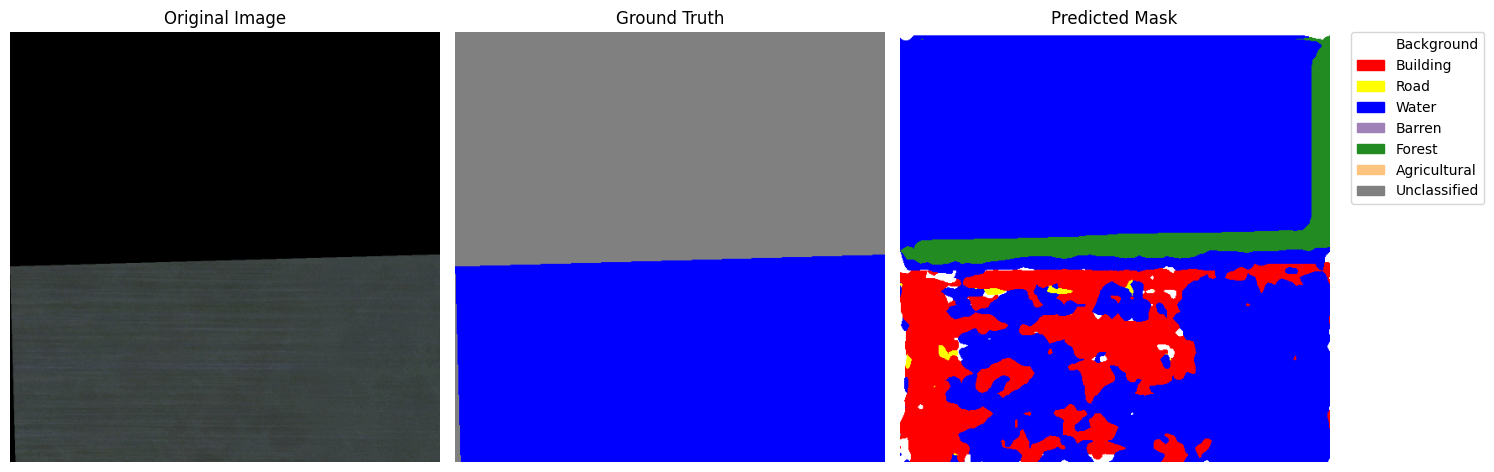

Starting epoch 12/20, LR = 0.00012185160979474886, DISC_LR = 0.0001
len of source_loader is 57, len of target_loader is 68. WARNING: make sure source is shorter than target, or modify code to fix early stopping


  0%|          | 0/57 [00:00<?, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 2.9353206157684326 --- loss_adv at batch 0: 0.07402291893959045 --- 

  2%|▏         | 1/57 [00:04<04:20,  4.65s/it]

loss_disc at batch 0: 8.011887550354004


  9%|▉         | 5/57 [00:14<02:18,  2.66s/it]


[losses are unscaled] loss_pidnet at batch 5: 3.135312795639038 --- loss_adv at batch 5: 0.0780477374792099 --- 

 11%|█         | 6/57 [00:15<01:49,  2.15s/it]

loss_disc at batch 5: 9.017692565917969


 18%|█▊        | 10/57 [00:21<01:17,  1.64s/it]


[losses are unscaled] loss_pidnet at batch 10: 3.2547569274902344 --- loss_adv at batch 10: 0.07647088170051575 --- 

 19%|█▉        | 11/57 [00:24<01:26,  1.88s/it]

loss_disc at batch 10: 7.557519912719727


 26%|██▋       | 15/57 [00:33<01:35,  2.26s/it]


[losses are unscaled] loss_pidnet at batch 15: 2.9269866943359375 --- loss_adv at batch 15: 0.07689447700977325 --- 

 28%|██▊       | 16/57 [00:34<01:19,  1.93s/it]

loss_disc at batch 15: 8.001113891601562


 35%|███▌      | 20/57 [00:41<01:03,  1.71s/it]


[losses are unscaled] loss_pidnet at batch 20: 3.476156711578369 --- loss_adv at batch 20: 0.06921964883804321 --- 

 37%|███▋      | 21/57 [00:42<00:57,  1.60s/it]

loss_disc at batch 20: 8.295114517211914


 44%|████▍     | 25/57 [00:51<01:04,  2.00s/it]


[losses are unscaled] loss_pidnet at batch 25: 3.1650352478027344 --- loss_adv at batch 25: 0.0787980929017067 --- 

 46%|████▌     | 26/57 [00:53<00:56,  1.82s/it]

loss_disc at batch 25: 7.883415222167969


 53%|█████▎    | 30/57 [00:59<00:41,  1.53s/it]


[losses are unscaled] loss_pidnet at batch 30: 3.665776252746582 --- loss_adv at batch 30: 0.07478134334087372 --- 

 54%|█████▍    | 31/57 [01:01<00:44,  1.71s/it]

loss_disc at batch 30: 8.133665084838867


 61%|██████▏   | 35/57 [01:10<00:49,  2.26s/it]


[losses are unscaled] loss_pidnet at batch 35: 3.1869287490844727 --- loss_adv at batch 35: 0.07194194942712784 --- 

 63%|██████▎   | 36/57 [01:11<00:40,  1.95s/it]

loss_disc at batch 35: 7.887539386749268


 70%|███████   | 40/57 [01:18<00:26,  1.58s/it]


[losses are unscaled] loss_pidnet at batch 40: 3.0793356895446777 --- loss_adv at batch 40: 0.059887759387493134 --- 

 72%|███████▏  | 41/57 [01:20<00:31,  1.94s/it]

loss_disc at batch 40: 8.624835968017578


 79%|███████▉  | 45/57 [01:29<00:26,  2.19s/it]


[losses are unscaled] loss_pidnet at batch 45: 4.38493537902832 --- loss_adv at batch 45: 0.08977558463811874 --- 

 81%|████████  | 46/57 [01:30<00:20,  1.88s/it]

loss_disc at batch 45: 7.392068862915039


 88%|████████▊ | 50/57 [01:36<00:10,  1.54s/it]


[losses are unscaled] loss_pidnet at batch 50: 3.1047418117523193 --- loss_adv at batch 50: 0.09121069312095642 --- 

 89%|████████▉ | 51/57 [01:40<00:12,  2.01s/it]

loss_disc at batch 50: 7.801633358001709


 96%|█████████▋| 55/57 [01:49<00:04,  2.20s/it]


[losses are unscaled] loss_pidnet at batch 55: 3.1959657669067383 --- loss_adv at batch 55: 0.07940832525491714 --- 

 98%|█████████▊| 56/57 [01:50<00:01,  1.88s/it]

loss_disc at batch 55: 8.194258689880371


100%|██████████| 57/57 [01:51<00:00,  1.96s/it]
0it [00:00, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.079521894454956 --- loss_adv at batch 0: 0.5116608142852783 --- 

1it [00:03,  3.26s/it]

loss_disc at batch 0: 5.888339996337891


5it [00:11,  2.57s/it]


[losses are unscaled] loss_pidnet at batch 5: 1.8854384422302246 --- loss_adv at batch 5: 0.44050002098083496 --- 

6it [00:12,  1.87s/it]

loss_disc at batch 5: 4.424627304077148


10it [00:18,  1.43s/it]


[losses are unscaled] loss_pidnet at batch 10: 2.47080397605896 --- loss_adv at batch 10: 0.29933473467826843 --- 

11it [00:20,  1.72s/it]

loss_disc at batch 10: 6.367042541503906


14it [00:24,  1.74s/it]


Epoch 12, Loss 132.06741905212402
BEST MODEL ON VALIDATION SET, SAVING
best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth model succesfully saved on drive. loss went down to 132.06741905212402
[EPOCH 12] Avg. Losses:
loss_complete        0.277723
loss_pidnet          0.203840
loss_adv             0.004835
loss_disc            0.514668
loss_pidnet_wtd      0.020384
loss_adv_wtd         0.000005
loss_disc_wtd        0.257334
Validation
[EPOCH 12] Avg. Losses:
loss_complete        0.217486
loss_pidnet          0.166737
loss_adv             0.021268
loss_disc            0.401582
loss_pidnet_wtd      0.016674
loss_adv_wtd         0.000021
loss_disc_wtd        0.200791


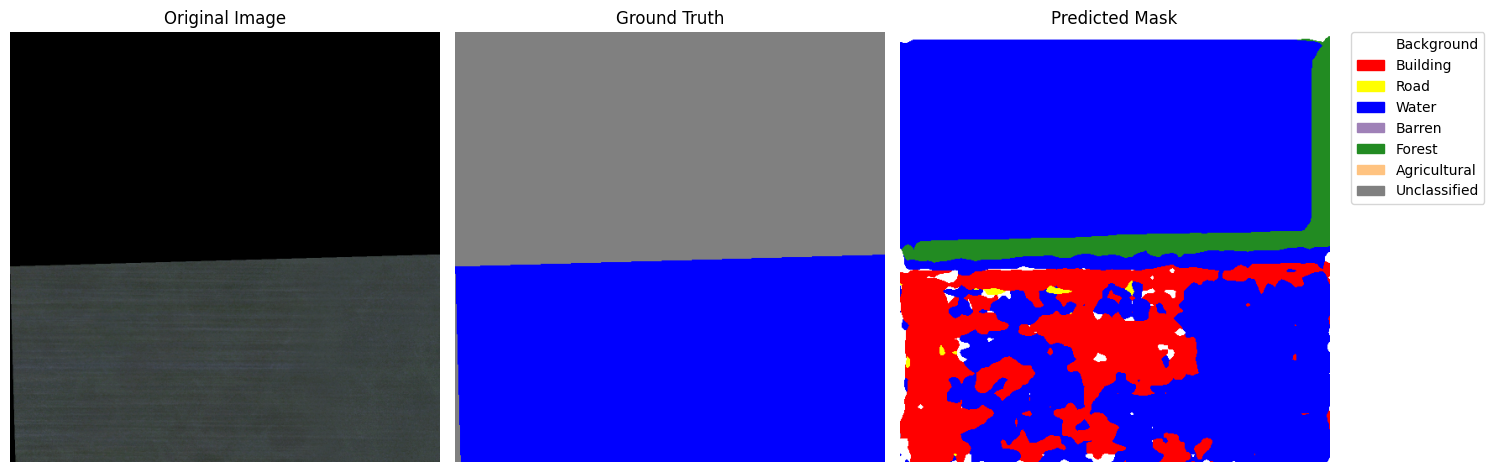

Starting epoch 13/20, LR = 0.00010959582263852174, DISC_LR = 0.0001
len of source_loader is 57, len of target_loader is 68. WARNING: make sure source is shorter than target, or modify code to fix early stopping


  0%|          | 0/57 [00:00<?, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.365746021270752 --- loss_adv at batch 0: 0.6882519125938416 --- 

  2%|▏         | 1/57 [00:03<03:41,  3.95s/it]

loss_disc at batch 0: 4.123445987701416


  9%|▉         | 5/57 [00:11<01:52,  2.17s/it]


[losses are unscaled] loss_pidnet at batch 5: 4.627269744873047 --- loss_adv at batch 5: 0.6764215230941772 --- 

 11%|█         | 6/57 [00:12<01:33,  1.84s/it]

loss_disc at batch 5: 4.7850775718688965


 18%|█▊        | 10/57 [00:21<01:28,  1.88s/it]


[losses are unscaled] loss_pidnet at batch 10: 3.5736327171325684 --- loss_adv at batch 10: 0.8049837946891785 --- 

 19%|█▉        | 11/57 [00:23<01:30,  1.97s/it]

loss_disc at batch 10: 4.596579074859619


 26%|██▋       | 15/57 [00:31<01:33,  2.23s/it]


[losses are unscaled] loss_pidnet at batch 15: 2.993002414703369 --- loss_adv at batch 15: 0.9042856097221375 --- 

 28%|██▊       | 16/57 [00:32<01:19,  1.93s/it]

loss_disc at batch 15: 4.169834613800049


 35%|███▌      | 20/57 [00:41<01:06,  1.81s/it]


[losses are unscaled] loss_pidnet at batch 20: 3.336833953857422 --- loss_adv at batch 20: 0.8170008063316345 --- 

 37%|███▋      | 21/57 [00:42<01:05,  1.82s/it]

loss_disc at batch 20: 4.380987644195557


 44%|████▍     | 25/57 [00:50<01:07,  2.11s/it]


[losses are unscaled] loss_pidnet at batch 25: 3.231667995452881 --- loss_adv at batch 25: 0.7530155181884766 --- 

 46%|████▌     | 26/57 [00:51<00:57,  1.84s/it]

loss_disc at batch 25: 4.121213912963867


 53%|█████▎    | 30/57 [01:00<00:47,  1.78s/it]


[losses are unscaled] loss_pidnet at batch 30: 3.0372838973999023 --- loss_adv at batch 30: 0.7506049871444702 --- 

 54%|█████▍    | 31/57 [01:02<00:47,  1.83s/it]

loss_disc at batch 30: 4.152416229248047


 61%|██████▏   | 35/57 [01:09<00:47,  2.15s/it]


[losses are unscaled] loss_pidnet at batch 35: 2.9623115062713623 --- loss_adv at batch 35: 0.84876549243927 --- 

 63%|██████▎   | 36/57 [01:11<00:39,  1.87s/it]

loss_disc at batch 35: 6.60758113861084


 70%|███████   | 40/57 [01:19<00:30,  1.77s/it]


[losses are unscaled] loss_pidnet at batch 40: 3.1200828552246094 --- loss_adv at batch 40: 0.7854411005973816 --- 

 72%|███████▏  | 41/57 [01:20<00:28,  1.78s/it]

loss_disc at batch 40: 4.1999711990356445


 79%|███████▉  | 45/57 [01:29<00:27,  2.28s/it]


[losses are unscaled] loss_pidnet at batch 45: 2.963129997253418 --- loss_adv at batch 45: 0.6878093481063843 --- 

 81%|████████  | 46/57 [01:30<00:21,  1.97s/it]

loss_disc at batch 45: 5.202134132385254


 88%|████████▊ | 50/57 [01:38<00:12,  1.75s/it]


[losses are unscaled] loss_pidnet at batch 50: 3.7705297470092773 --- loss_adv at batch 50: 0.7301485538482666 --- 

 89%|████████▉ | 51/57 [01:40<00:10,  1.77s/it]

loss_disc at batch 50: 4.780975818634033


 96%|█████████▋| 55/57 [01:47<00:04,  2.15s/it]


[losses are unscaled] loss_pidnet at batch 55: 3.1823058128356934 --- loss_adv at batch 55: 0.7163181304931641 --- 

 98%|█████████▊| 56/57 [01:49<00:01,  1.96s/it]

loss_disc at batch 55: 4.449438095092773


100%|██████████| 57/57 [01:52<00:00,  1.98s/it]
0it [00:00, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.0360629558563232 --- loss_adv at batch 0: 1.997428059577942 --- 

1it [00:03,  3.46s/it]

loss_disc at batch 0: 4.766234874725342


5it [00:09,  2.02s/it]


[losses are unscaled] loss_pidnet at batch 5: 1.8960288763046265 --- loss_adv at batch 5: 1.9192065000534058 --- 

6it [00:10,  1.48s/it]

loss_disc at batch 5: 4.132815361022949


10it [00:19,  1.82s/it]


[losses are unscaled] loss_pidnet at batch 10: 2.495589256286621 --- loss_adv at batch 10: 1.4258606433868408 --- 

11it [00:21,  1.96s/it]

loss_disc at batch 10: 5.403797149658203


14it [00:24,  1.77s/it]


Epoch 13, Loss 134.14767837524414
[EPOCH 13] Avg. Losses:
loss_complete        0.157247
loss_pidnet          0.210072
loss_adv             0.047482
loss_disc            0.272385
loss_pidnet_wtd      0.021007
loss_adv_wtd         0.000047
loss_disc_wtd        0.136193
Validation
[EPOCH 13] Avg. Losses:
loss_complete        0.183440
loss_pidnet          0.166291
loss_adv             0.099159
loss_disc            0.333423
loss_pidnet_wtd      0.016629
loss_adv_wtd         0.000099
loss_disc_wtd        0.166712


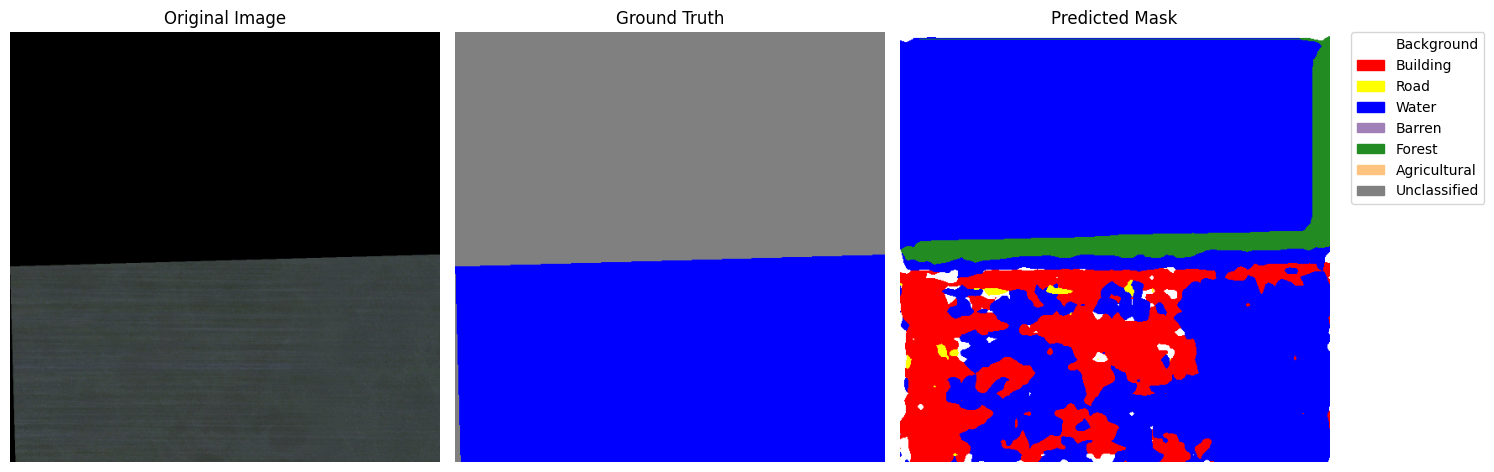

Starting epoch 14/20, LR = 9.718544969969087e-05, DISC_LR = 0.0001
len of source_loader is 57, len of target_loader is 68. WARNING: make sure source is shorter than target, or modify code to fix early stopping


  0%|          | 0/57 [00:00<?, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.533456325531006 --- loss_adv at batch 0: 3.3862075805664062 --- 

  2%|▏         | 1/57 [00:07<06:44,  7.22s/it]

loss_disc at batch 0: 4.359541416168213


  9%|▉         | 5/57 [00:14<02:04,  2.40s/it]


[losses are unscaled] loss_pidnet at batch 5: 3.0312938690185547 --- loss_adv at batch 5: 3.319901704788208 --- 

 11%|█         | 6/57 [00:16<01:40,  1.97s/it]

loss_disc at batch 5: 4.050388336181641


 18%|█▊        | 10/57 [00:23<01:24,  1.79s/it]


[losses are unscaled] loss_pidnet at batch 10: 3.3396549224853516 --- loss_adv at batch 10: 3.2120306491851807 --- 

 19%|█▉        | 11/57 [00:27<01:57,  2.55s/it]

loss_disc at batch 10: 4.110383033752441


 26%|██▋       | 15/57 [00:35<01:26,  2.06s/it]


[losses are unscaled] loss_pidnet at batch 15: 3.3321709632873535 --- loss_adv at batch 15: 3.2783689498901367 --- 

 28%|██▊       | 16/57 [00:36<01:13,  1.80s/it]

loss_disc at batch 15: 4.421541213989258


 35%|███▌      | 20/57 [00:44<01:09,  1.87s/it]


[losses are unscaled] loss_pidnet at batch 20: 2.960419178009033 --- loss_adv at batch 20: 3.409865379333496 --- 

 37%|███▋      | 21/57 [00:47<01:28,  2.47s/it]

loss_disc at batch 20: 4.160498142242432


 44%|████▍     | 25/57 [00:54<00:56,  1.76s/it]


[losses are unscaled] loss_pidnet at batch 25: 3.056206703186035 --- loss_adv at batch 25: 3.107470750808716 --- 

 46%|████▌     | 26/57 [00:55<00:48,  1.57s/it]

loss_disc at batch 25: 3.855095863342285


 53%|█████▎    | 30/57 [01:03<00:49,  1.84s/it]


[losses are unscaled] loss_pidnet at batch 30: 3.3685169219970703 --- loss_adv at batch 30: 3.1714224815368652 --- 

 54%|█████▍    | 31/57 [01:06<01:03,  2.45s/it]

loss_disc at batch 30: 4.0166192054748535


 61%|██████▏   | 35/57 [01:13<00:40,  1.84s/it]


[losses are unscaled] loss_pidnet at batch 35: 3.3405637741088867 --- loss_adv at batch 35: 3.134763479232788 --- 

 63%|██████▎   | 36/57 [01:14<00:34,  1.63s/it]

loss_disc at batch 35: 3.7855751514434814


 70%|███████   | 40/57 [01:22<00:32,  1.94s/it]


[losses are unscaled] loss_pidnet at batch 40: 3.246631622314453 --- loss_adv at batch 40: 3.227653980255127 --- 

 72%|███████▏  | 41/57 [01:25<00:36,  2.31s/it]

loss_disc at batch 40: 3.7980284690856934


 79%|███████▉  | 45/57 [01:32<00:21,  1.79s/it]


[losses are unscaled] loss_pidnet at batch 45: 2.9455552101135254 --- loss_adv at batch 45: 3.390495777130127 --- 

 81%|████████  | 46/57 [01:33<00:17,  1.59s/it]

loss_disc at batch 45: 4.480109214782715


 88%|████████▊ | 50/57 [01:41<00:13,  1.95s/it]


[losses are unscaled] loss_pidnet at batch 50: 3.5355472564697266 --- loss_adv at batch 50: 3.127370834350586 --- 

 89%|████████▉ | 51/57 [01:44<00:13,  2.33s/it]

loss_disc at batch 50: 4.392952919006348


 96%|█████████▋| 55/57 [01:50<00:03,  1.59s/it]


[losses are unscaled] loss_pidnet at batch 55: 3.2455875873565674 --- loss_adv at batch 55: 3.3101518154144287 --- 

 98%|█████████▊| 56/57 [01:51<00:01,  1.45s/it]

loss_disc at batch 55: 4.083563804626465


100%|██████████| 57/57 [01:52<00:00,  1.98s/it]
0it [00:00, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.0634522438049316 --- loss_adv at batch 0: 4.644702911376953 --- 

1it [00:05,  5.74s/it]

loss_disc at batch 0: 5.856843948364258


5it [00:12,  2.14s/it]


[losses are unscaled] loss_pidnet at batch 5: 1.8798840045928955 --- loss_adv at batch 5: 3.4772138595581055 --- 

6it [00:12,  1.56s/it]

loss_disc at batch 5: 5.897332191467285


10it [00:18,  1.29s/it]


[losses are unscaled] loss_pidnet at batch 10: 2.5245065689086914 --- loss_adv at batch 10: 2.9667415618896484 --- 

11it [00:22,  2.16s/it]

loss_disc at batch 10: 6.457834720611572


14it [00:27,  1.95s/it]


Epoch 14, Loss 172.48408126831055
[EPOCH 14] Avg. Losses:
loss_complete        0.148062
loss_pidnet          0.203462
loss_adv             0.201066
loss_disc            0.255030
loss_pidnet_wtd      0.020346
loss_adv_wtd         0.000201
loss_disc_wtd        0.127515
Validation
[EPOCH 14] Avg. Losses:
loss_complete        0.211993
loss_pidnet          0.167086
loss_adv             0.212788
loss_disc            0.390144
loss_pidnet_wtd      0.016709
loss_adv_wtd         0.000213
loss_disc_wtd        0.195072


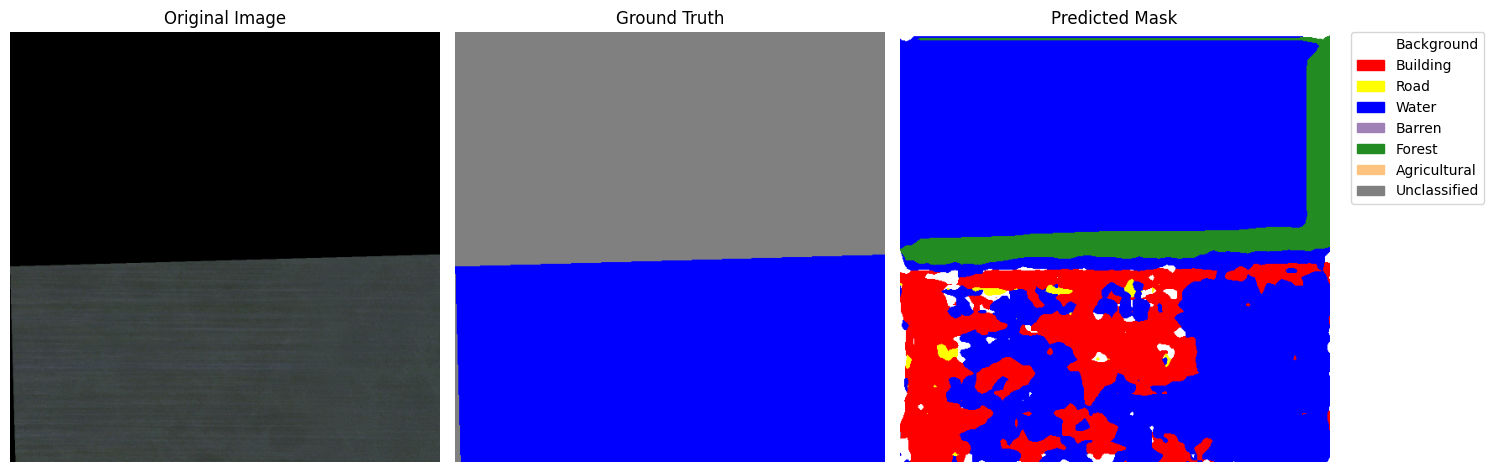

Starting epoch 15/20, LR = 8.459586547541247e-05, DISC_LR = 0.0001
len of source_loader is 57, len of target_loader is 68. WARNING: make sure source is shorter than target, or modify code to fix early stopping


  0%|          | 0/57 [00:00<?, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.5826430320739746 --- loss_adv at batch 0: 5.872090816497803 --- 

  2%|▏         | 1/57 [00:04<03:44,  4.00s/it]

loss_disc at batch 0: 5.723208427429199


  9%|▉         | 5/57 [00:12<02:06,  2.43s/it]


[losses are unscaled] loss_pidnet at batch 5: 3.2695913314819336 --- loss_adv at batch 5: 5.673162937164307 --- 

 11%|█         | 6/57 [00:13<01:43,  2.02s/it]

loss_disc at batch 5: 5.568853378295898


 18%|█▊        | 10/57 [00:21<01:25,  1.83s/it]


[losses are unscaled] loss_pidnet at batch 10: 3.4655895233154297 --- loss_adv at batch 10: 5.919631004333496 --- 

 19%|█▉        | 11/57 [00:23<01:27,  1.90s/it]

loss_disc at batch 10: 5.370495319366455


 26%|██▋       | 15/57 [00:32<01:39,  2.36s/it]


[losses are unscaled] loss_pidnet at batch 15: 3.3396148681640625 --- loss_adv at batch 15: 5.537144660949707 --- 

 28%|██▊       | 16/57 [00:33<01:22,  2.02s/it]

loss_disc at batch 15: 5.87856912612915


 35%|███▌      | 20/57 [00:41<01:06,  1.78s/it]


[losses are unscaled] loss_pidnet at batch 20: 3.301755428314209 --- loss_adv at batch 20: 5.495416641235352 --- 

 37%|███▋      | 21/57 [00:43<01:08,  1.90s/it]

loss_disc at batch 20: 5.341401100158691


 44%|████▍     | 25/57 [00:52<01:14,  2.33s/it]


[losses are unscaled] loss_pidnet at batch 25: 2.953617811203003 --- loss_adv at batch 25: 5.416205406188965 --- 

 46%|████▌     | 26/57 [00:53<01:02,  2.01s/it]

loss_disc at batch 25: 5.585309982299805


 53%|█████▎    | 30/57 [01:00<00:46,  1.72s/it]


[losses are unscaled] loss_pidnet at batch 30: 3.024141550064087 --- loss_adv at batch 30: 5.508928298950195 --- 

 54%|█████▍    | 31/57 [01:02<00:46,  1.80s/it]

loss_disc at batch 30: 5.47650671005249


 61%|██████▏   | 35/57 [01:11<00:52,  2.40s/it]


[losses are unscaled] loss_pidnet at batch 35: 3.1472907066345215 --- loss_adv at batch 35: 5.3544111251831055 --- 

 63%|██████▎   | 36/57 [01:12<00:42,  2.04s/it]

loss_disc at batch 35: 5.926358699798584


 70%|███████   | 40/57 [01:19<00:28,  1.70s/it]


[losses are unscaled] loss_pidnet at batch 40: 3.390343189239502 --- loss_adv at batch 40: 5.368846893310547 --- 

 72%|███████▏  | 41/57 [01:21<00:27,  1.74s/it]

loss_disc at batch 40: 5.5669331550598145


 79%|███████▉  | 45/57 [01:29<00:25,  2.10s/it]


[losses are unscaled] loss_pidnet at batch 45: 4.243913173675537 --- loss_adv at batch 45: 5.529380798339844 --- 

 81%|████████  | 46/57 [01:32<00:24,  2.21s/it]

loss_disc at batch 45: 5.8567891120910645


 88%|████████▊ | 50/57 [01:38<00:11,  1.66s/it]


[losses are unscaled] loss_pidnet at batch 50: 3.256558895111084 --- loss_adv at batch 50: 5.295844078063965 --- 

 89%|████████▉ | 51/57 [01:40<00:11,  1.87s/it]

loss_disc at batch 50: 5.38797664642334


 96%|█████████▋| 55/57 [01:49<00:04,  2.37s/it]


[losses are unscaled] loss_pidnet at batch 55: 3.4827051162719727 --- loss_adv at batch 55: 5.7128586769104 --- 

 98%|█████████▊| 56/57 [01:50<00:02,  2.01s/it]

loss_disc at batch 55: 5.566313743591309


100%|██████████| 57/57 [01:53<00:00,  1.98s/it]
0it [00:00, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.0222599506378174 --- loss_adv at batch 0: 5.917546272277832 --- 

1it [00:03,  3.36s/it]

loss_disc at batch 0: 5.917939186096191


5it [00:10,  2.07s/it]


[losses are unscaled] loss_pidnet at batch 5: 1.847827672958374 --- loss_adv at batch 5: 4.0695600509643555 --- 

6it [00:10,  1.52s/it]

loss_disc at batch 5: 5.937069416046143


10it [00:18,  1.62s/it]


[losses are unscaled] loss_pidnet at batch 10: 2.453786849975586 --- loss_adv at batch 10: 3.831075668334961 --- 

11it [00:20,  1.84s/it]

loss_disc at batch 10: 6.126221179962158


14it [00:24,  1.73s/it]


Epoch 15, Loss 183.67294597625732
[EPOCH 15] Avg. Losses:
loss_complete        0.194947
loss_pidnet          0.202680
loss_adv             0.345022
loss_disc            0.348668
loss_pidnet_wtd      0.020268
loss_adv_wtd         0.000345
loss_disc_wtd        0.174334
Validation
[EPOCH 15] Avg. Losses:
loss_complete        0.204017
loss_pidnet          0.166226
loss_adv             0.279513
loss_disc            0.374229
loss_pidnet_wtd      0.016623
loss_adv_wtd         0.000280
loss_disc_wtd        0.187115


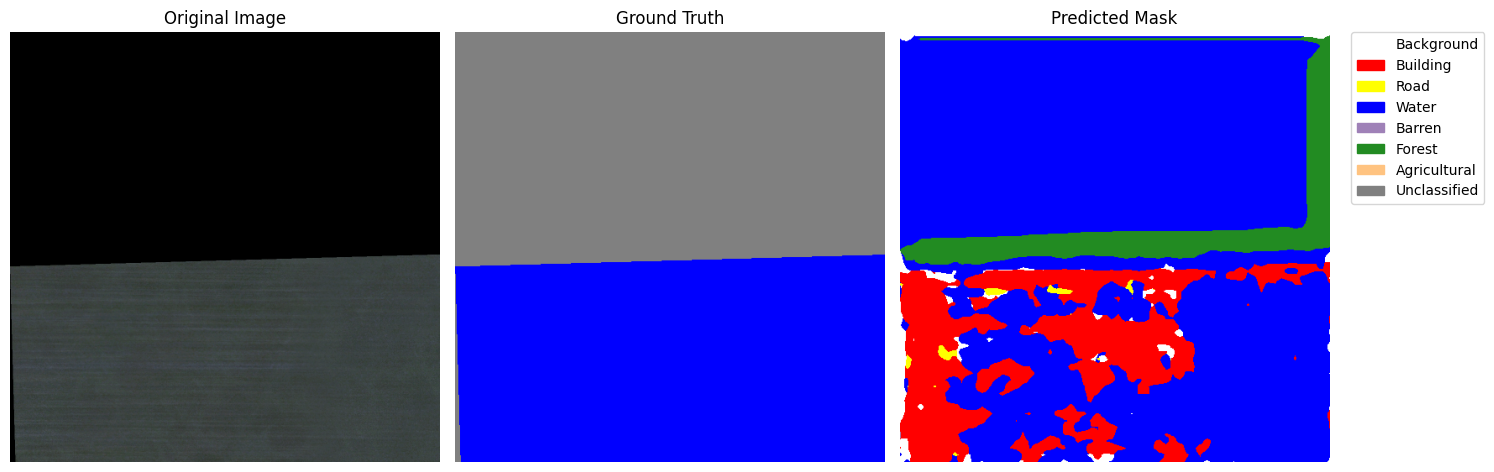

Starting epoch 16/20, LR = 7.179364718731468e-05, DISC_LR = 0.0001
len of source_loader is 57, len of target_loader is 68. WARNING: make sure source is shorter than target, or modify code to fix early stopping


  0%|          | 0/57 [00:00<?, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 2.8890817165374756 --- loss_adv at batch 0: 6.084561347961426 --- 

  2%|▏         | 1/57 [00:06<05:49,  6.24s/it]

loss_disc at batch 0: 6.534399509429932


  9%|▉         | 5/57 [00:13<02:01,  2.33s/it]


[losses are unscaled] loss_pidnet at batch 5: 4.109646320343018 --- loss_adv at batch 5: 6.379352569580078 --- 

 11%|█         | 6/57 [00:15<01:38,  1.93s/it]

loss_disc at batch 5: 6.007579326629639


 18%|█▊        | 10/57 [00:23<01:36,  2.06s/it]


[losses are unscaled] loss_pidnet at batch 10: 3.1436595916748047 --- loss_adv at batch 10: 6.621216773986816 --- 

 19%|█▉        | 11/57 [00:27<02:02,  2.67s/it]

loss_disc at batch 10: 6.514741897583008


 26%|██▋       | 15/57 [00:34<01:20,  1.92s/it]


[losses are unscaled] loss_pidnet at batch 15: 3.0249598026275635 --- loss_adv at batch 15: 6.0827531814575195 --- 

 28%|██▊       | 16/57 [00:35<01:09,  1.68s/it]

loss_disc at batch 15: 6.23921012878418


 35%|███▌      | 20/57 [00:43<01:08,  1.85s/it]


[losses are unscaled] loss_pidnet at batch 20: 3.326061487197876 --- loss_adv at batch 20: 5.733403205871582 --- 

 37%|███▋      | 21/57 [00:47<01:30,  2.52s/it]

loss_disc at batch 20: 5.9996562004089355


 44%|████▍     | 25/57 [00:53<00:59,  1.86s/it]


[losses are unscaled] loss_pidnet at batch 25: 3.4315881729125977 --- loss_adv at batch 25: 6.633187294006348 --- 

 46%|████▌     | 26/57 [00:54<00:51,  1.65s/it]

loss_disc at batch 25: 6.167285442352295


 53%|█████▎    | 30/57 [01:03<00:54,  2.00s/it]


[losses are unscaled] loss_pidnet at batch 30: 3.1399574279785156 --- loss_adv at batch 30: 5.921806335449219 --- 

 54%|█████▍    | 31/57 [01:06<01:01,  2.36s/it]

loss_disc at batch 30: 6.276156902313232


 61%|██████▏   | 35/57 [01:12<00:39,  1.80s/it]


[losses are unscaled] loss_pidnet at batch 35: 3.4212732315063477 --- loss_adv at batch 35: 6.694561958312988 --- 

 63%|██████▎   | 36/57 [01:13<00:33,  1.60s/it]

loss_disc at batch 35: 6.1490349769592285


 70%|███████   | 40/57 [01:22<00:35,  2.11s/it]


[losses are unscaled] loss_pidnet at batch 40: 3.3446850776672363 --- loss_adv at batch 40: 6.43545389175415 --- 

 72%|███████▏  | 41/57 [01:25<00:39,  2.46s/it]

loss_disc at batch 40: 5.904475688934326


 79%|███████▉  | 45/57 [01:32<00:23,  1.92s/it]


[losses are unscaled] loss_pidnet at batch 45: 2.943622350692749 --- loss_adv at batch 45: 7.058963775634766 --- 

 81%|████████  | 46/57 [01:33<00:18,  1.68s/it]

loss_disc at batch 45: 6.465738296508789


 88%|████████▊ | 50/57 [01:41<00:13,  1.90s/it]


[losses are unscaled] loss_pidnet at batch 50: 2.9991273880004883 --- loss_adv at batch 50: 6.062006950378418 --- 

 89%|████████▉ | 51/57 [01:45<00:14,  2.44s/it]

loss_disc at batch 50: 6.045571804046631


 96%|█████████▋| 55/57 [01:51<00:03,  1.78s/it]


[losses are unscaled] loss_pidnet at batch 55: 3.593348264694214 --- loss_adv at batch 55: 6.436108589172363 --- 

 98%|█████████▊| 56/57 [01:52<00:01,  1.58s/it]

loss_disc at batch 55: 5.694371223449707


100%|██████████| 57/57 [01:54<00:00,  2.00s/it]
0it [00:00, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.119715690612793 --- loss_adv at batch 0: 6.377533912658691 --- 

1it [00:05,  5.67s/it]

loss_disc at batch 0: 5.110903739929199


5it [00:12,  2.15s/it]


[losses are unscaled] loss_pidnet at batch 5: 1.9103994369506836 --- loss_adv at batch 5: 4.08737850189209 --- 

6it [00:12,  1.56s/it]

loss_disc at batch 5: 5.146084785461426


10it [00:18,  1.30s/it]


[losses are unscaled] loss_pidnet at batch 10: 2.5646581649780273 --- loss_adv at batch 10: 4.264864444732666 --- 

11it [00:22,  2.16s/it]

loss_disc at batch 10: 5.182161808013916


14it [00:27,  1.98s/it]


Epoch 16, Loss 178.6377649307251
best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth_16.pth succesfully saved on drive. loss went down to 132.06741905212402
[EPOCH 16] Avg. Losses:
loss_complete        0.212443
loss_pidnet          0.204975
loss_adv             0.395040
loss_disc            0.383101
loss_pidnet_wtd      0.020498
loss_adv_wtd         0.000395
loss_disc_wtd        0.191551
Validation
[EPOCH 16] Avg. Losses:
loss_complete        0.177512
loss_pidnet          0.171028
loss_adv             0.306257
loss_disc            0.320205
loss_pidnet_wtd      0.017103
loss_adv_wtd         0.000306
loss_disc_wtd        0.160102


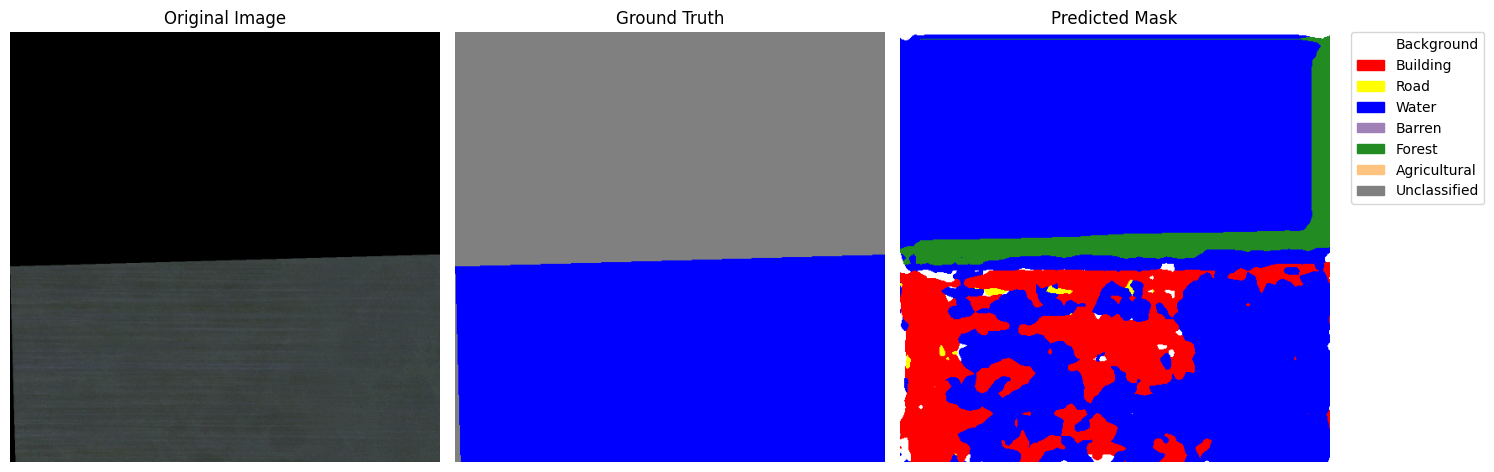

Starting epoch 17/20, LR = 5.873094715440094e-05, DISC_LR = 0.0001
len of source_loader is 57, len of target_loader is 68. WARNING: make sure source is shorter than target, or modify code to fix early stopping


  0%|          | 0/57 [00:00<?, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.1812591552734375 --- loss_adv at batch 0: 5.044952869415283 --- 

  2%|▏         | 1/57 [00:04<04:16,  4.58s/it]

loss_disc at batch 0: 4.571260452270508


  9%|▉         | 5/57 [00:13<02:21,  2.73s/it]


[losses are unscaled] loss_pidnet at batch 5: 3.5440187454223633 --- loss_adv at batch 5: 5.153116226196289 --- 

 11%|█         | 6/57 [00:14<01:53,  2.22s/it]

loss_disc at batch 5: 5.234035491943359


 18%|█▊        | 10/57 [00:21<01:23,  1.78s/it]


[losses are unscaled] loss_pidnet at batch 10: 3.184511184692383 --- loss_adv at batch 10: 5.252598762512207 --- 

 19%|█▉        | 11/57 [00:23<01:25,  1.86s/it]

loss_disc at batch 10: 5.025517463684082


 26%|██▋       | 15/57 [00:32<01:34,  2.24s/it]


[losses are unscaled] loss_pidnet at batch 15: 3.0678393840789795 --- loss_adv at batch 15: 5.366976737976074 --- 

 28%|██▊       | 16/57 [00:33<01:21,  1.98s/it]

loss_disc at batch 15: 4.936188220977783


 35%|███▌      | 20/57 [00:40<01:04,  1.74s/it]


[losses are unscaled] loss_pidnet at batch 20: 3.2173054218292236 --- loss_adv at batch 20: 5.405923843383789 --- 

 37%|███▋      | 21/57 [00:43<01:14,  2.08s/it]

loss_disc at batch 20: 5.397631645202637


 44%|████▍     | 25/57 [00:53<01:21,  2.54s/it]


[losses are unscaled] loss_pidnet at batch 25: 3.2289416790008545 --- loss_adv at batch 25: 5.174602031707764 --- 

 46%|████▌     | 26/57 [00:55<01:10,  2.28s/it]

loss_disc at batch 25: 5.129930019378662


 53%|█████▎    | 30/57 [01:01<00:49,  1.83s/it]


[losses are unscaled] loss_pidnet at batch 30: 2.812169075012207 --- loss_adv at batch 30: 5.072005748748779 --- 

 54%|█████▍    | 31/57 [01:03<00:44,  1.72s/it]

loss_disc at batch 30: 4.7866926193237305


 61%|██████▏   | 35/57 [01:12<00:49,  2.26s/it]


[losses are unscaled] loss_pidnet at batch 35: 4.628009796142578 --- loss_adv at batch 35: 5.790351867675781 --- 

 63%|██████▎   | 36/57 [01:14<00:42,  2.01s/it]

loss_disc at batch 35: 4.768466472625732


 70%|███████   | 40/57 [01:20<00:28,  1.66s/it]


[losses are unscaled] loss_pidnet at batch 40: 3.0901217460632324 --- loss_adv at batch 40: 5.398014068603516 --- 

 72%|███████▏  | 41/57 [01:23<00:29,  1.84s/it]

loss_disc at batch 40: 5.356054782867432


 79%|███████▉  | 45/57 [01:32<00:27,  2.26s/it]


[losses are unscaled] loss_pidnet at batch 45: 3.4191231727600098 --- loss_adv at batch 45: 5.043902397155762 --- 

 81%|████████  | 46/57 [01:33<00:21,  1.92s/it]

loss_disc at batch 45: 5.624510288238525


 88%|████████▊ | 50/57 [01:39<00:11,  1.60s/it]


[losses are unscaled] loss_pidnet at batch 50: 3.2492780685424805 --- loss_adv at batch 50: 5.0334978103637695 --- 

 89%|████████▉ | 51/57 [01:41<00:10,  1.71s/it]

loss_disc at batch 50: 5.083548545837402


 96%|█████████▋| 55/57 [01:51<00:04,  2.23s/it]


[losses are unscaled] loss_pidnet at batch 55: 3.1285977363586426 --- loss_adv at batch 55: 5.213724136352539 --- 

 98%|█████████▊| 56/57 [01:53<00:02,  2.09s/it]

loss_disc at batch 55: 5.238582611083984


100%|██████████| 57/57 [01:54<00:00,  2.02s/it]
0it [00:00, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.0044262409210205 --- loss_adv at batch 0: 4.058295726776123 --- 

1it [00:03,  3.62s/it]

loss_disc at batch 0: 3.5533504486083984


5it [00:12,  2.70s/it]


[losses are unscaled] loss_pidnet at batch 5: 1.8669447898864746 --- loss_adv at batch 5: 2.902944326400757 --- 

6it [00:12,  1.91s/it]

loss_disc at batch 5: 3.550764560699463


10it [00:19,  1.46s/it]


[losses are unscaled] loss_pidnet at batch 10: 2.4629464149475098 --- loss_adv at batch 10: 3.054975748062134 --- 

11it [00:21,  1.69s/it]

loss_disc at batch 10: 3.58528733253479


14it [00:24,  1.78s/it]


Epoch 17, Loss 134.16059684753418
best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth_17.pth succesfully saved on drive. loss went down to 132.06741905212402
[EPOCH 17] Avg. Losses:
loss_complete        0.181748
loss_pidnet          0.211465
loss_adv             0.328600
loss_disc            0.320546
loss_pidnet_wtd      0.021147
loss_adv_wtd         0.000329
loss_disc_wtd        0.160273
Validation
[EPOCH 17] Avg. Losses:
loss_complete        0.126490
loss_pidnet          0.164290
loss_adv             0.214948
loss_disc            0.219693
loss_pidnet_wtd      0.016429
loss_adv_wtd         0.000215
loss_disc_wtd        0.109847


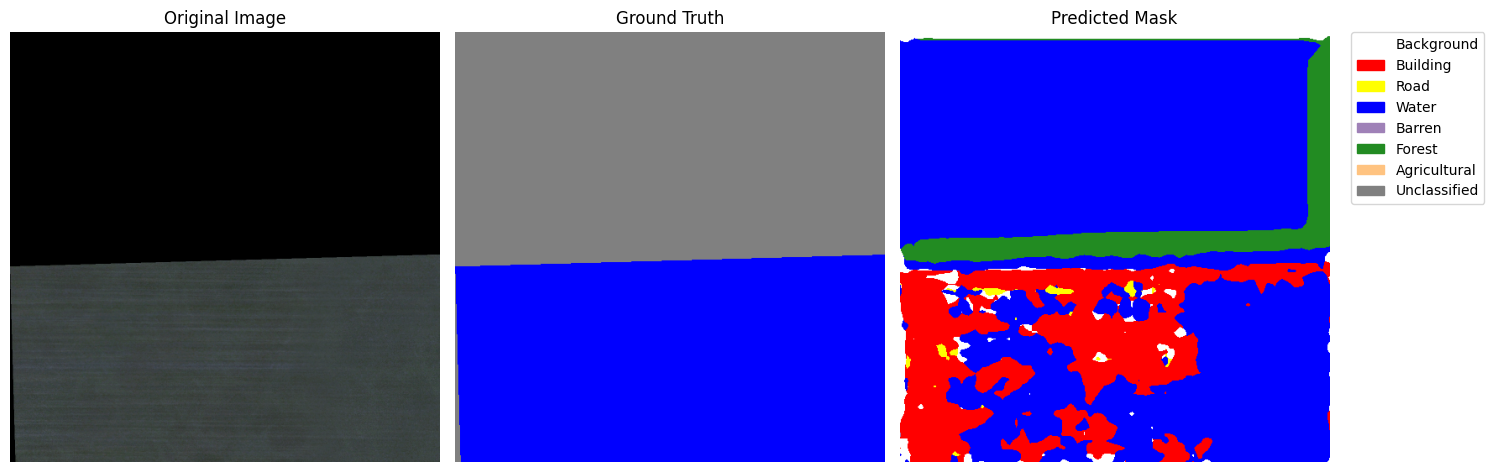

Starting epoch 18/20, LR = 4.533380182841864e-05, DISC_LR = 0.0001
len of source_loader is 57, len of target_loader is 68. WARNING: make sure source is shorter than target, or modify code to fix early stopping


  0%|          | 0/57 [00:00<?, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.628314971923828 --- loss_adv at batch 0: 3.672456741333008 --- 

  2%|▏         | 1/57 [00:04<03:50,  4.11s/it]

loss_disc at batch 0: 3.3057005405426025


  9%|▉         | 5/57 [00:12<02:14,  2.59s/it]


[losses are unscaled] loss_pidnet at batch 5: 4.064599990844727 --- loss_adv at batch 5: 3.0325980186462402 --- 

 11%|█         | 6/57 [00:13<01:47,  2.11s/it]

loss_disc at batch 5: 3.466609477996826


 18%|█▊        | 10/57 [00:21<01:21,  1.73s/it]


[losses are unscaled] loss_pidnet at batch 10: 2.9318039417266846 --- loss_adv at batch 10: 3.1186752319335938 --- 

 19%|█▉        | 11/57 [00:23<01:24,  1.85s/it]

loss_disc at batch 10: 3.2885820865631104


 26%|██▋       | 15/57 [00:31<01:35,  2.26s/it]


[losses are unscaled] loss_pidnet at batch 15: 3.2943263053894043 --- loss_adv at batch 15: 3.142643451690674 --- 

 28%|██▊       | 16/57 [00:33<01:32,  2.25s/it]

loss_disc at batch 15: 3.3489861488342285


 35%|███▌      | 20/57 [00:40<01:05,  1.76s/it]


[losses are unscaled] loss_pidnet at batch 20: 3.3755505084991455 --- loss_adv at batch 20: 3.2275075912475586 --- 

 37%|███▋      | 21/57 [00:41<00:59,  1.65s/it]

loss_disc at batch 20: 3.455919027328491


 44%|████▍     | 25/57 [00:51<01:11,  2.23s/it]


[losses are unscaled] loss_pidnet at batch 25: 2.9414029121398926 --- loss_adv at batch 25: 3.2392611503601074 --- 

 46%|████▌     | 26/57 [00:53<01:11,  2.31s/it]

loss_disc at batch 25: 3.056049346923828


 53%|█████▎    | 30/57 [00:59<00:45,  1.69s/it]


[losses are unscaled] loss_pidnet at batch 30: 3.486647129058838 --- loss_adv at batch 30: 3.409573793411255 --- 

 54%|█████▍    | 31/57 [01:01<00:44,  1.72s/it]

loss_disc at batch 30: 3.547666072845459


 61%|██████▏   | 35/57 [01:11<00:53,  2.44s/it]


[losses are unscaled] loss_pidnet at batch 35: 3.559713363647461 --- loss_adv at batch 35: 2.9472265243530273 --- 

 63%|██████▎   | 36/57 [01:12<00:44,  2.12s/it]

loss_disc at batch 35: 3.7699167728424072


 70%|███████   | 40/57 [01:19<00:28,  1.67s/it]


[losses are unscaled] loss_pidnet at batch 40: 3.1538376808166504 --- loss_adv at batch 40: 3.1571390628814697 --- 

 72%|███████▏  | 41/57 [01:20<00:25,  1.62s/it]

loss_disc at batch 40: 3.7743923664093018


 79%|███████▉  | 45/57 [01:29<00:24,  2.06s/it]


[losses are unscaled] loss_pidnet at batch 45: 3.0976076126098633 --- loss_adv at batch 45: 3.3867220878601074 --- 

 81%|████████  | 46/57 [01:32<00:23,  2.18s/it]

loss_disc at batch 45: 3.4102883338928223


 88%|████████▊ | 50/57 [01:38<00:12,  1.74s/it]


[losses are unscaled] loss_pidnet at batch 50: 2.863304615020752 --- loss_adv at batch 50: 3.3351683616638184 --- 

 89%|████████▉ | 51/57 [01:39<00:09,  1.56s/it]

loss_disc at batch 50: 3.384495258331299


 96%|█████████▋| 55/57 [01:48<00:04,  2.15s/it]


[losses are unscaled] loss_pidnet at batch 55: 2.947329044342041 --- loss_adv at batch 55: 3.446157932281494 --- 

 98%|█████████▊| 56/57 [01:51<00:02,  2.16s/it]

loss_disc at batch 55: 3.3993799686431885


100%|██████████| 57/57 [01:52<00:00,  1.97s/it]
0it [00:00, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.1248559951782227 --- loss_adv at batch 0: 2.4565446376800537 --- 

1it [00:03,  3.26s/it]

loss_disc at batch 0: 2.5508813858032227


5it [00:11,  2.49s/it]


[losses are unscaled] loss_pidnet at batch 5: 1.9022340774536133 --- loss_adv at batch 5: 1.8833327293395996 --- 

6it [00:11,  1.84s/it]

loss_disc at batch 5: 2.4857230186462402


10it [00:18,  1.45s/it]


[losses are unscaled] loss_pidnet at batch 10: 2.5647082328796387 --- loss_adv at batch 10: 2.0901103019714355 --- 

11it [00:20,  1.77s/it]

loss_disc at batch 10: 2.521209716796875


14it [00:24,  1.72s/it]


Epoch 18, Loss 104.67280912399292
BEST MODEL ON VALIDATION SET, SAVING
best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth model succesfully saved on drive. loss went down to 104.67280912399292
best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth_18.pth succesfully saved on drive. loss went down to 104.67280912399292
[EPOCH 18] Avg. Losses:
loss_complete        0.127233
loss_pidnet          0.205449
loss_adv             0.207101
loss_disc            0.212962
loss_pidnet_wtd      0.020545
loss_adv_wtd         0.000207
loss_disc_wtd        0.106481
Validation
[EPOCH 18] Avg. Losses:
loss_complete        0.094025
loss_pidnet          0.169718
loss_adv             0.143754
loss_disc            0.153818
loss_pidnet_wtd      0.016972
loss_adv_wtd         0.000144
loss_disc_wtd        0.076909


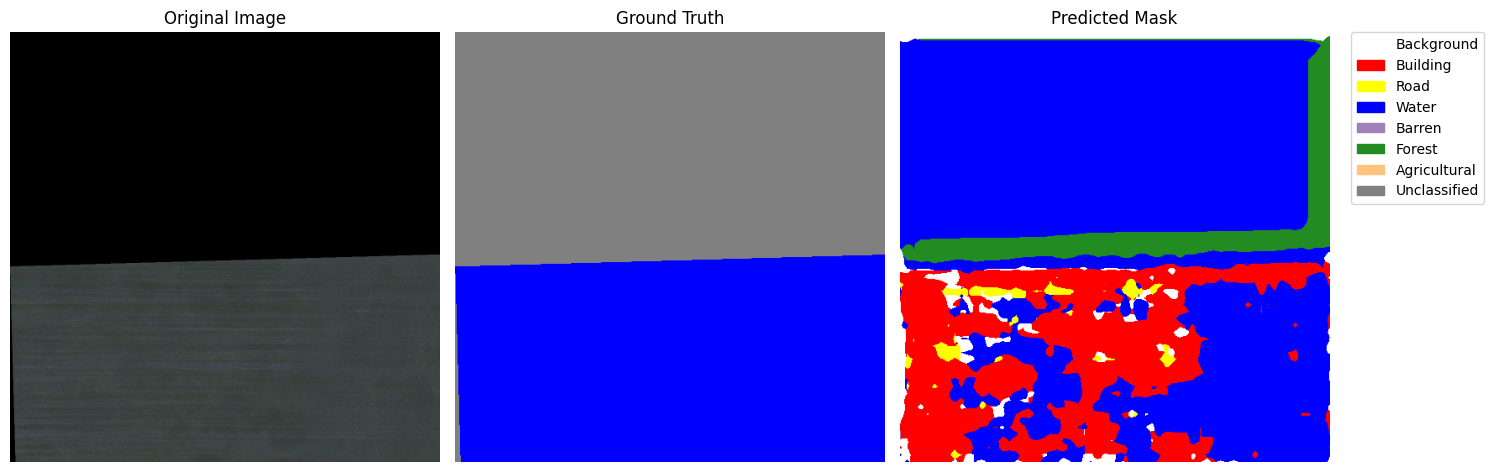

Starting epoch 19/20, LR = 3.147313529485418e-05, DISC_LR = 0.0001
len of source_loader is 57, len of target_loader is 68. WARNING: make sure source is shorter than target, or modify code to fix early stopping


  0%|          | 0/57 [00:00<?, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.0548253059387207 --- loss_adv at batch 0: 1.651816964149475 --- 

  2%|▏         | 1/57 [00:04<03:51,  4.13s/it]

loss_disc at batch 0: 2.883898973464966


  9%|▉         | 5/57 [00:12<02:00,  2.32s/it]


[losses are unscaled] loss_pidnet at batch 5: 3.4563217163085938 --- loss_adv at batch 5: 1.8074803352355957 --- 

 11%|█         | 6/57 [00:13<01:39,  1.96s/it]

loss_disc at batch 5: 2.818019390106201


 18%|█▊        | 10/57 [00:22<01:31,  1.95s/it]


[losses are unscaled] loss_pidnet at batch 10: 3.5737521648406982 --- loss_adv at batch 10: 1.7664167881011963 --- 

 19%|█▉        | 11/57 [00:24<01:32,  2.02s/it]

loss_disc at batch 10: 2.699349880218506


 26%|██▋       | 15/57 [00:32<01:31,  2.17s/it]


[losses are unscaled] loss_pidnet at batch 15: 3.193955421447754 --- loss_adv at batch 15: 1.8063807487487793 --- 

 28%|██▊       | 16/57 [00:33<01:17,  1.89s/it]

loss_disc at batch 15: 2.6987290382385254


 35%|███▌      | 20/57 [00:42<01:08,  1.84s/it]


[losses are unscaled] loss_pidnet at batch 20: 3.7181601524353027 --- loss_adv at batch 20: 1.8005445003509521 --- 

 37%|███▋      | 21/57 [00:44<01:08,  1.90s/it]

loss_disc at batch 20: 2.9679813385009766


 44%|████▍     | 25/57 [00:52<01:15,  2.37s/it]


[losses are unscaled] loss_pidnet at batch 25: 3.328786611557007 --- loss_adv at batch 25: 2.0386390686035156 --- 

 46%|████▌     | 26/57 [00:54<01:02,  2.02s/it]

loss_disc at batch 25: 3.1625313758850098


 53%|█████▎    | 30/57 [01:01<00:45,  1.70s/it]


[losses are unscaled] loss_pidnet at batch 30: 3.6722819805145264 --- loss_adv at batch 30: 1.7760813236236572 --- 

 54%|█████▍    | 31/57 [01:03<00:48,  1.87s/it]

loss_disc at batch 30: 2.744495153427124


 61%|██████▏   | 35/57 [01:12<00:54,  2.46s/it]


[losses are unscaled] loss_pidnet at batch 35: 2.885904550552368 --- loss_adv at batch 35: 1.7567209005355835 --- 

 63%|██████▎   | 36/57 [01:13<00:43,  2.09s/it]

loss_disc at batch 35: 2.9959070682525635


 70%|███████   | 40/57 [01:20<00:29,  1.72s/it]


[losses are unscaled] loss_pidnet at batch 40: 3.0101776123046875 --- loss_adv at batch 40: 1.65950608253479 --- 

 72%|███████▏  | 41/57 [01:22<00:27,  1.73s/it]

loss_disc at batch 40: 2.9334630966186523


 79%|███████▉  | 45/57 [01:31<00:29,  2.45s/it]


[losses are unscaled] loss_pidnet at batch 45: 3.179928779602051 --- loss_adv at batch 45: 1.7557121515274048 --- 

 81%|████████  | 46/57 [01:33<00:23,  2.11s/it]

loss_disc at batch 45: 2.8315932750701904


 88%|████████▊ | 50/57 [01:40<00:12,  1.72s/it]


[losses are unscaled] loss_pidnet at batch 50: 2.812446355819702 --- loss_adv at batch 50: 1.8101142644882202 --- 

 89%|████████▉ | 51/57 [01:42<00:10,  1.78s/it]

loss_disc at batch 50: 3.007748603820801


 96%|█████████▋| 55/57 [01:51<00:04,  2.39s/it]


[losses are unscaled] loss_pidnet at batch 55: 3.2687954902648926 --- loss_adv at batch 55: 1.7000129222869873 --- 

 98%|█████████▊| 56/57 [01:52<00:02,  2.01s/it]

loss_disc at batch 55: 2.926772356033325


100%|██████████| 57/57 [01:54<00:00,  2.01s/it]
0it [00:00, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.0228800773620605 --- loss_adv at batch 0: 1.1542308330535889 --- 

1it [00:03,  3.51s/it]

loss_disc at batch 0: 2.301835060119629


5it [00:10,  2.24s/it]


[losses are unscaled] loss_pidnet at batch 5: 1.8625117540359497 --- loss_adv at batch 5: 1.129692792892456 --- 

6it [00:11,  1.65s/it]

loss_disc at batch 5: 2.2625985145568848


10it [00:19,  1.62s/it]


[losses are unscaled] loss_pidnet at batch 10: 2.4453365802764893 --- loss_adv at batch 10: 1.244443416595459 --- 

11it [00:21,  1.92s/it]

loss_disc at batch 10: 2.239047050476074


14it [00:25,  1.81s/it]


Epoch 19, Loss 85.92646408081055
BEST MODEL ON VALIDATION SET, SAVING
best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth model succesfully saved on drive. loss went down to 85.92646408081055
best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth_19.pth succesfully saved on drive. loss went down to 85.92646408081055
[EPOCH 19] Avg. Losses:
loss_complete        0.111846
loss_pidnet          0.203097
loss_adv             0.109522
loss_disc            0.182855
loss_pidnet_wtd      0.020310
loss_adv_wtd         0.000110
loss_disc_wtd        0.091427
Validation
[EPOCH 19] Avg. Losses:
loss_complete        0.085302
loss_pidnet          0.164189
loss_adv             0.081809
loss_disc            0.137603
loss_pidnet_wtd      0.016419
loss_adv_wtd         0.000082
loss_disc_wtd        0.068801


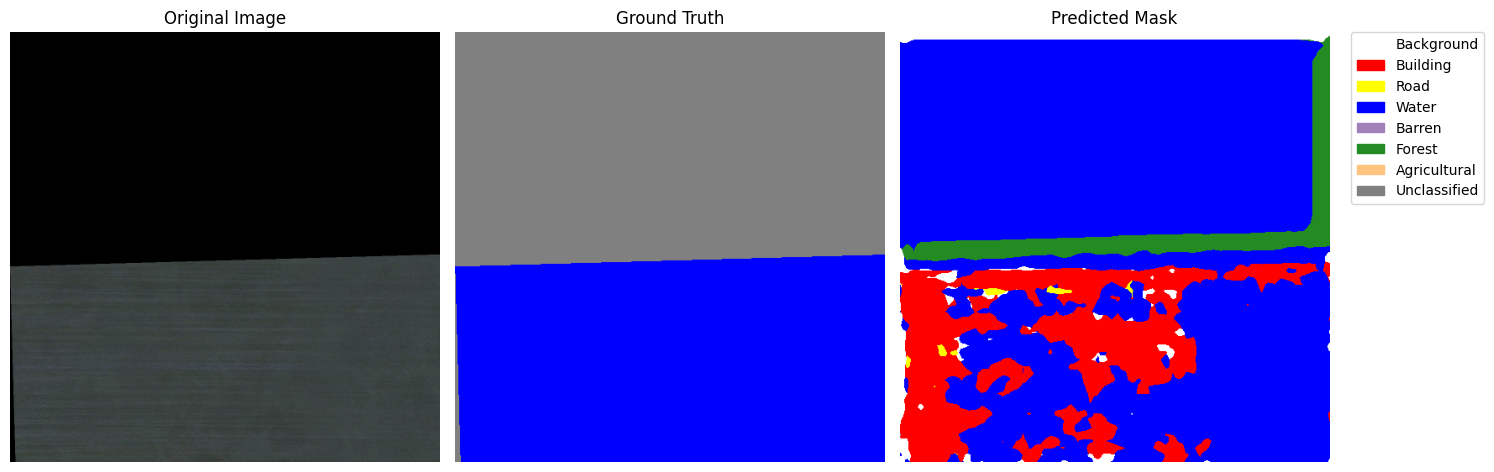

Starting epoch 20/20, LR = 1.6866035595919554e-05, DISC_LR = 0.0001
len of source_loader is 57, len of target_loader is 68. WARNING: make sure source is shorter than target, or modify code to fix early stopping


  0%|          | 0/57 [00:00<?, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.282244920730591 --- loss_adv at batch 0: 0.7954663038253784 --- 

  2%|▏         | 1/57 [00:04<03:47,  4.06s/it]

loss_disc at batch 0: 3.584677219390869


  9%|▉         | 5/57 [00:10<01:36,  1.85s/it]


[losses are unscaled] loss_pidnet at batch 5: 2.999901056289673 --- loss_adv at batch 5: 0.9088387489318848 --- 

 11%|█         | 6/57 [00:11<01:23,  1.63s/it]

loss_disc at batch 5: 3.4058938026428223


 18%|█▊        | 10/57 [00:21<01:39,  2.13s/it]


[losses are unscaled] loss_pidnet at batch 10: 3.1277222633361816 --- loss_adv at batch 10: 0.8409450054168701 --- 

 19%|█▉        | 11/57 [00:23<01:37,  2.12s/it]

loss_disc at batch 10: 3.0245556831359863


 26%|██▋       | 15/57 [00:30<01:15,  1.80s/it]


[losses are unscaled] loss_pidnet at batch 15: 3.047757625579834 --- loss_adv at batch 15: 0.837329089641571 --- 

 28%|██▊       | 16/57 [00:31<01:07,  1.64s/it]

loss_disc at batch 15: 3.4443562030792236


 35%|███▌      | 20/57 [00:41<01:15,  2.05s/it]


[losses are unscaled] loss_pidnet at batch 20: 2.964797258377075 --- loss_adv at batch 20: 0.8453519344329834 --- 

 37%|███▋      | 21/57 [00:43<01:12,  2.01s/it]

loss_disc at batch 20: 3.25984525680542


 44%|████▍     | 25/57 [00:49<00:51,  1.62s/it]


[losses are unscaled] loss_pidnet at batch 25: 2.842639684677124 --- loss_adv at batch 25: 0.8572385311126709 --- 

 46%|████▌     | 26/57 [00:51<00:57,  1.85s/it]

loss_disc at batch 25: 3.455392599105835


 53%|█████▎    | 30/57 [01:01<00:57,  2.13s/it]


[losses are unscaled] loss_pidnet at batch 30: 3.9583234786987305 --- loss_adv at batch 30: 0.8605794906616211 --- 

 54%|█████▍    | 31/57 [01:02<00:50,  1.92s/it]

loss_disc at batch 30: 3.269951343536377


 61%|██████▏   | 35/57 [01:08<00:37,  1.71s/it]


[losses are unscaled] loss_pidnet at batch 35: 2.7918362617492676 --- loss_adv at batch 35: 0.860291063785553 --- 

 63%|██████▎   | 36/57 [01:10<00:33,  1.59s/it]

loss_disc at batch 35: 3.3694040775299072


 70%|███████   | 40/57 [01:19<00:34,  2.06s/it]


[losses are unscaled] loss_pidnet at batch 40: 3.179567337036133 --- loss_adv at batch 40: 0.9331258535385132 --- 

 72%|███████▏  | 41/57 [01:21<00:30,  1.91s/it]

loss_disc at batch 40: 3.1750669479370117


 79%|███████▉  | 45/57 [01:28<00:20,  1.75s/it]


[losses are unscaled] loss_pidnet at batch 45: 3.1559603214263916 --- loss_adv at batch 45: 0.8652445077896118 --- 

 81%|████████  | 46/57 [01:29<00:17,  1.57s/it]

loss_disc at batch 45: 3.31473970413208


 88%|████████▊ | 50/57 [01:39<00:14,  2.11s/it]


[losses are unscaled] loss_pidnet at batch 50: 3.149402141571045 --- loss_adv at batch 50: 0.9125683307647705 --- 

 89%|████████▉ | 51/57 [01:41<00:12,  2.07s/it]

loss_disc at batch 50: 3.4458680152893066


 96%|█████████▋| 55/57 [01:47<00:03,  1.76s/it]


[losses are unscaled] loss_pidnet at batch 55: 3.2604410648345947 --- loss_adv at batch 55: 0.8132292032241821 --- 

 98%|█████████▊| 56/57 [01:49<00:01,  1.59s/it]

loss_disc at batch 55: 3.4427812099456787


100%|██████████| 57/57 [01:51<00:00,  1.96s/it]
0it [00:00, ?it/s]


[losses are unscaled] loss_pidnet at batch 0: 3.014774799346924 --- loss_adv at batch 0: 0.5957704782485962 --- 

1it [00:03,  3.28s/it]

loss_disc at batch 0: 2.9295554161071777


5it [00:08,  1.73s/it]


[losses are unscaled] loss_pidnet at batch 5: 1.8493595123291016 --- loss_adv at batch 5: 0.8135753870010376 --- 

6it [00:09,  1.33s/it]

loss_disc at batch 5: 2.338473320007324


10it [00:18,  1.81s/it]


[losses are unscaled] loss_pidnet at batch 10: 2.4869563579559326 --- loss_adv at batch 10: 0.8242532014846802 --- 

11it [00:21,  2.21s/it]

loss_disc at batch 10: 2.424962043762207


14it [00:24,  1.78s/it]


Epoch 20, Loss 83.42267942428589
BEST MODEL ON VALIDATION SET, SAVING
best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth model succesfully saved on drive. loss went down to 83.42267942428589
best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth_20.pth succesfully saved on drive. loss went down to 83.42267942428589
[EPOCH 20] Avg. Losses:
loss_complete        0.123962
loss_pidnet          0.207106
loss_adv             0.053127
loss_disc            0.206397
loss_pidnet_wtd      0.020711
loss_adv_wtd         0.000053
loss_disc_wtd        0.103198
Validation
[EPOCH 20] Avg. Losses:
loss_complete        0.094709
loss_pidnet          0.163639
loss_adv             0.052198
loss_disc            0.156586
loss_pidnet_wtd      0.016364
loss_adv_wtd         0.000052
loss_disc_wtd        0.078293


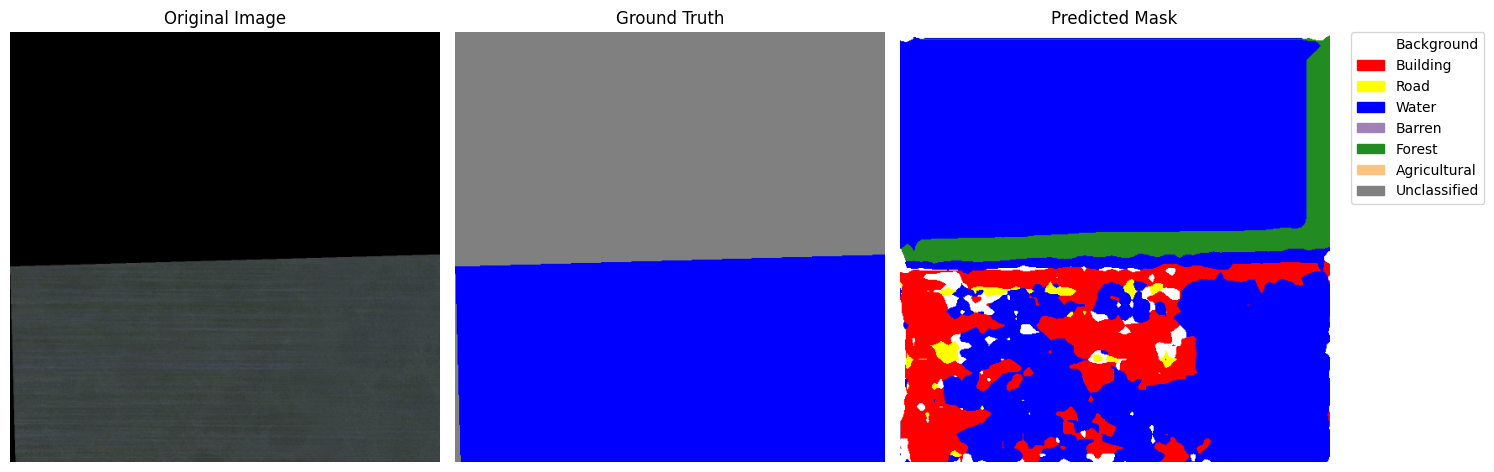

In [106]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import numpy as np

# For easier debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

# STEP_SIZEs = [21, 14]
# DISC_STEP_SIZEs = [14, 21]

for LAMBDA_ADV in LAMBDA_ADVs:
    ## If you want to UPLOAD an existing model for re-training
    if LOAD_BASE_MODEL:
        #model_path = os.path.join(drive_path, model_name)
        #best_model = torch.load(model_path, map_location=DEVICE)
        best_model = torch.load(f'/content/{model_name}', weights_only=True)
        model.load_state_dict(best_model)

    ## Optimizier and Scheduler
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
    optimizer.zero_grad()

    disc_optimizer = optim.Adam(disc_model.parameters(), lr=DISC_LR, betas=(0.9, 0.99))
    disc_optimizer.zero_grad()

    ## Models Names
    SAVE_MODEL_AS =        f'best_DA_model_{CHOOSE_TRANSFORM}__PRETRN={LOAD_BASE_MODEL}__optepch__LS={LAMBDA_SEG}_LA={LAMBDA_ADV}_LD={LAMBDA_DISC}__polyLRstep={do_step_lr}_polydscLRstep={disc_do_step_lr}.pth'
    SAVE_DISC_MODEL_AS = f'best_disc_model_{CHOOSE_TRANSFORM}__PRETRN={LOAD_BASE_MODEL}__optepch__LS={LAMBDA_SEG}_LA={LAMBDA_ADV}_LD={LAMBDA_DISC}__polyLRstep={do_step_lr}_polydscLRstep={disc_do_step_lr}.pth'
    MODEL_NAME = SAVE_MODEL_AS

    current_step = 0

    ## Prepare to save model and params which proves to be best
    best_loss = float('inf')
    best_model = model.state_dict()
    disc_best_model = disc_model.state_dict()

    model = model.to(DEVICE)
    disc_model = disc_model.to(DEVICE)
    print(f"DEVICE is {DEVICE}. Model name is {SAVE_MODEL_AS}")

    ## Start the training
    if TYPE == 'Train':
        for epoch in range(NUM_EPOCHS):
            model.train()
            disc_model.train()
            adjust_learning_rate(optimizer, epoch, dont=do_step_lr) # like scheduler.step()

            optimizer.zero_grad()
            disc_optimizer.zero_grad()
            adjust_learning_rate_D(disc_optimizer, epoch, dont=disc_do_step_lr) # like disc_scheduler.step()

            epoch_losses = {
                'loss_complete': 0.0,
                'amount': 0, # amt of images I think?
                'loss_pidnet': 0.0,
                'loss_adv': 0.0,
                'loss_disc': 0.0,
                'loss_pidnet_wtd': 0.0,
                'loss_adv_wtd': 0.0,
                'loss_disc_wtd': 0.0,
            }

            print('Starting epoch {}/{}, LR = {}, DISC_LR = {}'.format(epoch+1, NUM_EPOCHS, optimizer.param_groups[0]['lr'], disc_optimizer.param_groups[0]['lr']))
            srcldr_len = len(source_loader)
            tgtldr_len = len(target_loader)
            print(f"len of source_loader is {srcldr_len}, len of target_loader is {tgtldr_len}. WARNING: make sure source is shorter than target, or modify code to fix early stopping")

            # ================================== Train Epoch X ==================================
            for batch_i, (batch_s, batch_t) in tqdm(enumerate(zip(source_loader, target_loader)), total=len(source_loader)):
                ### Extract input
                image_list_source, masks_list_source, img_path_source, bd_gts_list_source = batch_s
                image_list_target, _, _, _ = batch_t

                index = 0
                for images, masks, bd_gts, images_t in zip(image_list_source, masks_list_source, bd_gts_list_source, image_list_target):
                    ### Extract Images, Masks, Boundaries
                    # Source
                    images = images.to(DEVICE)
                    masks = masks.to(DEVICE)
                    bd_gts = bd_gts.float().to(DEVICE)
                    # print(f"DEBUG: source_image batch shape: {images.shape}")
                    # print(f"DEBUG: source_mask batch shape: {masks.shape}")

                    # Target
                    images_t = images_t.to(DEVICE)
                    # print(f"DEBUG: target_image batch shape: {images.shape}")

                    ### ReEnable optimization on backbone (***PIDNet***)
                    for params in model.parameters():
                        params.requires_grad = True

                    ### Disable ***Discriminator*** optimization for the first part
                    for param in disc_model.parameters():
                        param.requires_grad = False


                    ### ===> Train Segmentation --- on Source
                    ## Forward
                    outputs = model(images) # in model.train() mode batch size must be > 1 I think
                                            # NOTE: we have 3 heads (i.e. 3 outputs) but 4 losses: 2nd head is used for both S and BAS

                    ## Upscale (bilinear interpolation - not learned)
                    h, w = masks.size(1), masks.size(2)
                    ph, pw = outputs[0].size(2), outputs[0].size(3)
                    if ph != h or pw != w:
                        for i in range(len(outputs)):
                            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

                    ## Losses
                    # Semantic Losses (l_0 and l_2)
                    loss_s = sem_loss(outputs[:-1], masks) # output #1 and #2 are segmentation predictions (i.e. low level (P) and high+low level (PI) respectively)

                    # Boundary Loss (l_1)
                    loss_b = bd_loss(outputs[-1], bd_gts) # output #3 is the boundary prediction

                    # Boundary AwareneSS (BAS) Loss (l_3)
                    filler = torch.ones_like(masks) * -1
                    bd_label = torch.where(F.sigmoid(outputs[-1][:,0,:,:]) > 0.8, masks, filler)
                                        # REMEMBER to wrap in list, as the checks in ce use that to know what to do
                    loss_sb = sem_loss([outputs[-2]], bd_label) # output #2 is the PI segmentation prediction, done here in BAS mode (see `filler` variable)

                    # Segmentation Loss w/o DA (on source domain, which has labels)
                    loss_pidnet = loss_s + loss_b + loss_sb  # The coefficients of the sum of the four losses (0.4, 20, 1, 1) are taken into account in the various `sem_loss` and `bd_loss`
                    if batch_i % LOG_FREQUENCY == 0:
                        print(f'\n[losses are unscaled] loss_pidnet at batch {batch_i}: {loss_pidnet.item()}', end=" --- ")
                    epoch_losses['loss_pidnet'] += loss_pidnet.item()

                    ## Backprop
                    loss = loss_pidnet * LAMBDA_SEG #/ srcldr_len
                    epoch_losses['loss_complete'] += loss.item()
                    epoch_losses['loss_pidnet_wtd'] += loss.item()
                    loss.backward()
                    ### <=== Train Segmentation --- on Source


                    ### ===> Train Segmentation --- on Target
                    # note that we don't want to be optimizing the Discriminator yet
                    ## Forward
                    outputs_t = model(images_t)
                    # print(f"DEBUG: there are {len(outputs_t)} outputs for output_t")
                    # for output in outputs_t:
                    #     print(f"DEBUG: output shape is {output.shape}")

                    ## Upscale
                    h, w = images_t.size(2), images_t.size(3)
                    ph, pw = outputs_t[0].size(2), outputs_t[0].size(3)
                    output_t = F.interpolate(outputs_t[-2], size=(h, w), mode='bilinear', align_corners=True)
                    # print(f"DEBUG: shape of interpolated main Head output_t is {output_t.shape}, as h={h}, w={w}, ph={ph}, pw={pw}")

                    ## Discriminate
                    disc_output_t = disc_model(output_t)

                    ## Adversarial Loss (bce between disc_output_t and source_label (which is z=0)) # TODO: check this z=0 thing, as in the paper it states to opposite than in the repo
                    loss_adv = bce_loss(disc_output_t, torch.zeros_like(disc_output_t)).to(DEVICE)
                    if batch_i % LOG_FREQUENCY == 0:
                        print(f'loss_adv at batch {batch_i}: {loss_adv.item()}', end=" --- ")
                    epoch_losses['loss_adv'] += loss_adv.item()

                    ## Backprop
                    loss = loss_adv * LAMBDA_ADV #/ srcldr_len
                    epoch_losses['loss_complete'] += loss.item()
                    epoch_losses['loss_adv_wtd'] += loss.item()
                    loss.backward()
                    ### <=== Train Segmentation --- on Target


                    ### ===> Train Discriminator
                    ## Enable Optimization for ***Discriminator***
                    for param in disc_model.parameters():
                        param.requires_grad = True

                    ## Disable Optimization on backbone (***PIDNet***)
                    output = outputs[1].detach()
                    output_t = output_t.detach()

                    ## Discriminate
                    disc_output = disc_model(output)
                    disc_output_t = disc_model(output_t)

                    ## Discriminative Loss (z=0 for source domain z=1 for target domain) # TODO: check this z=0 and z=1 thing, as in the paper it states to opposite than in the repo
                    loss_disc =  bce_loss(disc_output, torch.zeros_like(disc_output)).to(DEVICE)
                    loss_disc += bce_loss(disc_output_t, torch.ones_like(disc_output_t)).to(DEVICE)

                    if batch_i % LOG_FREQUENCY == 0:
                        print(f'loss_disc at batch {batch_i}: {loss_disc.item()}')
                    epoch_losses['loss_disc'] += loss_disc.item()

                    ## Backprop
                    loss = loss_disc * LAMBDA_DISC #/ srcldr_len
                    epoch_losses['loss_complete'] += loss.item()
                    epoch_losses['loss_disc_wtd'] += loss.item()
                    loss.backward()
                    ### <=== Train Discriminator

                    epoch_losses['amount'] += images.size(0)

            optimizer.step()
            disc_optimizer.step()

            # ================================== Evaluate Main Model ==================================
            # Evaluate model on the evaluation set and save the parameters if is better than best model
            model.eval()
            disc_model.eval()
            total_loss = 0.0
            epoch_losses_eval = {
            'loss_complete': 0.0,
            'amount': 0, # amt of images I think?
            'loss_pidnet': 0.0,
            'loss_adv': 0.0,
            'loss_disc': 0.0,
            'loss_pidnet_wtd': 0.0,
            'loss_adv_wtd': 0.0,
            'loss_disc_wtd': 0.0,
            }

            outputs = []
            with torch.no_grad():
                for batch_i, (batch_s, batch_t) in tqdm(enumerate(zip(source_validation_loader, target_validation_loader))):
                    ### Extract input
                    images, masks, _, bd_gts = batch_s
                    images_t, _, _, _ = batch_t

                    ### Extract Images, Masks, Boundaries
                    # Source
                    images = images.to(DEVICE)
                    masks = masks.to(DEVICE)
                    bd_gts = bd_gts.float().to(DEVICE)
                    # print(f"DEBUG: source_image batch shape: {images.shape}")
                    # print(f"DEBUG: source_mask batch shape: {masks.shape}")

                    # Target
                    images_t = images_t.to(DEVICE)
                    # print(f"DEBUG: target_image batch shape: {images.shape}")

                    ### ===> Train Segmentation --- on Source
                    ## Forward
                    outputs = model(images) # in model.train() mode batch size must be > 1 I think
                                            # NOTE: we have 3 heads (i.e. 3 outputs) but 4 losses: 2nd head is used for both S and BAS

                    ## Upscale (bilinear interpolation - not learned)
                    h, w = masks.size(1), masks.size(2)
                    ph, pw = outputs[0].size(2), outputs[0].size(3)
                    if ph != h or pw != w:
                        for i in range(len(outputs)):
                            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

                    ## Losses
                    # Semantic Losses (l_0 and l_2)
                    loss_s = sem_loss(outputs[:-1], masks) # output #1 and #2 are segmentation predictions (i.e. low level (P) and high+low level (PI) respectively)

                    # Boundary Loss (l_1)
                    loss_b = bd_loss(outputs[-1], bd_gts) # output #3 is the boundary prediction

                    # Boundary AwareneSS (BAS) Loss (l_3)
                    filler = torch.ones_like(masks) * -1
                    bd_label = torch.where(F.sigmoid(outputs[-1][:,0,:,:]) > 0.8, masks, filler)
                                        # REMEMBER to wrap in list, as the checks in ce use that to know what to do
                    loss_sb = sem_loss([outputs[-2]], bd_label) # output #2 is the PI segmentation prediction, done here in BAS mode (see `filler` variable)

                    # Segmentation Loss w/o DA (on source domain, which has labels)
                    loss_pidnet = loss_s + loss_b + loss_sb  # The coefficients of the sum of the four losses (0.4, 20, 1, 1) are taken into account in the various `sem_loss` and `bd_loss`
                    if batch_i % LOG_FREQUENCY == 0:
                        print(f'\n[losses are unscaled] loss_pidnet at batch {batch_i}: {loss_pidnet.item()}', end=" --- ")
                    epoch_losses_eval['loss_pidnet'] += loss_pidnet.item()

                    ## Log losses
                    loss = loss_pidnet * LAMBDA_SEG
                    epoch_losses_eval['loss_complete'] += loss.item()
                    epoch_losses_eval['loss_pidnet_wtd'] += loss.item()

                    ### <=== Train Segmentation --- on Source


                    ### ===> Train Segmentation --- on Target
                    # note that we don't want to be optimizing the Discriminator yet
                    ## Forward
                    outputs_t = model(images_t)
                    # print(f"DEBUG: there are {len(outputs_t)} outputs for output_t")
                    # for output in outputs_t:
                    #     print(f"DEBUG: output shape is {output.shape}")

                    ## Upscale
                    h, w = images_t.size(2), images_t.size(3)
                    ph, pw = outputs_t[0].size(2), outputs_t[0].size(3)
                    output_t = F.interpolate(outputs_t[-2], size=(h, w), mode='bilinear', align_corners=True)
                    # print(f"DEBUG: shape of interpolated main Head output_t is {output_t.shape}, as h={h}, w={w}, ph={ph}, pw={pw}")

                    ## Discriminate
                    disc_output_t = disc_model(output_t)

                    ## Adversarial Loss (bce between disc_output_t and source_label (which is z=0)) # TODO: check this z=0 thing, as in the paper it states to opposite than in the repo
                    loss_adv = bce_loss(disc_output_t, torch.zeros_like(disc_output_t)).to(DEVICE)
                    if batch_i % LOG_FREQUENCY == 0:
                        print(f'loss_adv at batch {batch_i}: {loss_adv.item()}', end=" --- ")
                    epoch_losses_eval['loss_adv'] += loss_adv.item()

                    ## Log losses
                    loss = loss_adv * LAMBDA_ADV
                    epoch_losses_eval['loss_complete'] += loss.item()
                    epoch_losses_eval['loss_adv_wtd'] += loss.item()

                    ### <=== Train Segmentation --- on Target


                    ### ===> Train Discriminator
                    ## Discriminate
                    disc_output = disc_model(output)
                    disc_output_t = disc_model(output_t)

                    ## Discriminative Loss (z=0 for source domain z=1 for target domain) # TODO: check this z=0 and z=1 thing, as in the paper it states to opposite than in the repo
                    loss_disc =  bce_loss(disc_output, torch.zeros_like(disc_output)).to(DEVICE)
                    loss_disc += bce_loss(disc_output_t, torch.ones_like(disc_output_t)).to(DEVICE)
                    if batch_i % LOG_FREQUENCY == 0:
                        print(f'loss_disc at batch {batch_i}: {loss_disc.item()}')
                    epoch_losses_eval['loss_disc'] += loss_disc.item()

                    ## Log losses
                    loss = loss_disc * LAMBDA_DISC
                    epoch_losses_eval['loss_complete'] += loss.item()
                    epoch_losses_eval['loss_disc_wtd'] += loss.item()

                    ### <=== Train Discriminator

                    epoch_losses_eval['amount'] += images.size(0)
                    # Complete loss (loss_domain contains Loss adv and Loss discrimnation)
                    loss_complete = loss_pidnet + loss_adv + loss_disc

                    total_loss += loss_complete.item()

            print('Epoch {}, Loss {}'.format(epoch+1, total_loss))
            if total_loss < best_loss:
                best_loss = total_loss
                best_model = model.state_dict()
                #Save in Drive and local
                torch.save(best_model, SAVE_MODEL_AS)
                print("===========================================")
                print("BEST MODEL ON VALIDATION SET, SAVING")
                if SAVE_ON_DRIVE:
                    !cp {SAVE_MODEL_AS} /content/drive/MyDrive/LoveDA/{SAVE_MODEL_AS}
                    print(f"{SAVE_MODEL_AS} model succesfully saved on drive. loss went down to {best_loss}")

            if epoch >= SAVE_AFTER_EPOCH:
                torch.save(best_model, f'{MODEL_NAME}_{epoch+1}.pth')# Save model
                if SAVE_ON_DRIVE:
                    EPOCH_MODEL_PATH = f'{SAVE_MODEL_AS}_{epoch+1}.pth'
                    !cp {EPOCH_MODEL_PATH} /content/drive/MyDrive/LoveDA/{EPOCH_MODEL_PATH}
                    print(f"{EPOCH_MODEL_PATH} succesfully saved on drive. loss went down to {best_loss}")

            current_step += 1

            amt = epoch_losses['amount']
            print(f'[EPOCH {epoch+1:02}] Avg. Losses:')
            print(f'{"loss_complete":<20} {epoch_losses["loss_complete"] / amt:.6f}')
            print(f'{"loss_pidnet":<20} {epoch_losses["loss_pidnet"] / amt:.6f}')
            print(f'{"loss_adv":<20} {epoch_losses["loss_adv"] / amt:.6f}')
            print(f'{"loss_disc":<20} {epoch_losses["loss_disc"] / amt:.6f}')
            print(f'{"loss_pidnet_wtd":<20} {epoch_losses["loss_pidnet_wtd"] / amt:.6f}')
            print(f'{"loss_adv_wtd":<20} {epoch_losses["loss_adv_wtd"] / amt:.6f}')
            print(f'{"loss_disc_wtd":<20} {epoch_losses["loss_disc_wtd"] / amt:.6f}')
            print("========================================================================")
            print("Validation")
            amt = epoch_losses_eval['amount']
            print(f'[EPOCH {epoch+1:02}] Avg. Losses:')
            print(f'{"loss_complete":<20} {epoch_losses_eval["loss_complete"] / amt:.6f}')
            print(f'{"loss_pidnet":<20} {epoch_losses_eval["loss_pidnet"] / amt:.6f}')
            print(f'{"loss_adv":<20} {epoch_losses_eval["loss_adv"] / amt:.6f}')
            print(f'{"loss_disc":<20} {epoch_losses_eval["loss_disc"] / amt:.6f}')
            print(f'{"loss_pidnet_wtd":<20} {epoch_losses_eval["loss_pidnet_wtd"] / amt:.6f}')
            print(f'{"loss_adv_wtd":<20} {epoch_losses_eval["loss_adv_wtd"] / amt:.6f}')
            print(f'{"loss_disc_wtd":<20} {epoch_losses_eval["loss_disc_wtd"] / amt:.6f}')
            print("========================================================================")

            # Create a figure with 1 row and 3 columns
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            # Plot the original image
            axes[0].imshow(images[0].permute(1, 2, 0).cpu().numpy())
            axes[0].set_title("Original Image")
            axes[0].axis('off')

            # Plot the ground truth mask
            # axes[1].imshow(masks[0].cpu().numpy())
            # axes[1].set_title("Ground Truth")
            # axes[1].axis('off')

            # # Show mask
            adapted_mask = new_colors_mask(masks[0].cpu().numpy())
            plt.legend(handles=getLegendHandles(), loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
            axes[1].imshow(adapted_mask)
            axes[1].set_title("Ground Truth")
            axes[1].axis('off')

            # Plot the predicted mask
            # axes[2].imshow(torch.argmax(outputs[0][0], dim=0).cpu().numpy())
            # axes[2].set_title("Predicted Mask")
            # axes[2].axis('off')

            adapted_mask_2 = new_colors_mask(torch.argmax(outputs[0][0], dim=0).cpu().numpy())
            plt.legend(handles=getLegendHandles(), loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
            axes[2].imshow(adapted_mask_2)
            axes[2].set_title("Predicted Mask")
            axes[2].axis('off')

            # Display the figure
            plt.tight_layout()
            plt.show()

            # ================================== Evaluate Discriminator Model ==================================
            # TODO !!!!!!!!!!!!
            # just run the discriminator on couples of source/target images and evaluate the prediction being closer to 0/1 (0=source, 1=target)



In [107]:
# # Save model
# epoch = 19

# LAMBDA_SEGs = [1]

# for LAMBDA_SEG in LAMBDA_SEGs:
#     SAVE_MODEL_AS = f'best_DA_model_{CHOOSE_TRANSFORM}_LS={LAMBDA_SEG}_LA={LAMBDA_ADV}_LD={LAMBDA_DISC}.pth'
#     EPOCH_MODEL_PATH = f'{SAVE_MODEL_AS}_{epoch+1}.pth'

#     !cp {EPOCH_MODEL_PATH} /content/drive/MyDrive/LoveDA/{EPOCH_MODEL_PATH}
#     print(f"{EPOCH_MODEL_PATH} succesfully saved on drive. loss went down to {best_loss}")

# TEST

### Copy Some Models From MyDrive/LoveDA

In [108]:
# # Run the first cell pls
# import os

# BASE_PATH = "/content/drive/MyDrive/LoveDA/"
# INTEREST = "poly"

# all_mydrive = os.listdir(BASE_PATH)
# all_models = [f for f in all_mydrive if f.endswith('.pth')]
# models_of_interest = [f for f in all_models if INTEREST in f]
# for model_name in models_of_interest:
#     if not os.path.exists(model_name):
#       print(f"Copying {model_name} locally from MyDrive")
#       # !cp {BASE_PATH+model_name} .

### Test All Local Models

In [109]:
!pip install torchmetrics ptflops

In [110]:
from torchmetrics import Accuracy
from tqdm import tqdm
import time
import ptflops
import os

DEVICE = 'cuda'
TYPE = 'Test'
# WARNING: YOU MAY DECIDE TO OVVERIDE THE CHOOSE_TRANSFORM, BUT BE CAREFUL. BE SURE THE MODEL YOU'RE USING IS THE CORRECT ONE
CHOOSE_TRANSFORM = 'Resize'

# Create unweighted models
model = get_seg_model(cfg, imgnet_pretrained=False)
# disc_model = Discriminator(len(LABEL_MAP))

# Load weights
model_name_pattern = 'best_DA_model' # for starters, use 'best_DA_model' for this step, and just 'best_model' for non DA models
disc_model_name_pattern = 'best_disc_model'

# find filenames that start with model_name_pattern using os
model_files_paths = [f for f in os.listdir('.') if f.startswith(model_name_pattern)]
# disc_model_files_paths = [f for f in os.listdir('.') if f.startswith(disc_model_name_pattern)]
print(model_files_paths)

for model_file_path in model_files_paths:
    best_model = torch.load(model_file_path, weights_only=True)
    # best_disc_model = torch.load(disc_model_file_path, weights_only=True)

    model.load_state_dict(best_model)
    model = model.to(DEVICE)
    # disc_model.load_state_dict(best_disc_model)
    # disc_model = disc_model.to(DEVICE)

    accuracy, mIoU = True, True

    TARGETs = ['Urban', 'Rural']

    for TARGET in TARGETs:
        if TARGET == 'Urban': # Here we just validate on less images if URBAN, as it's not the focus of step 3b. Use Train instead of Validation for a 0.8 split instead of 0.2
            target_type = 'Validation'
        elif TARGET == 'Rural': # While we take the entirety of the Rural folder in case of Rural
            #target_type = 'ActualTest'
            target_type = 'Validation'
        else:
            raise ValueError("TARGET must be 'Urban' or 'Rural'")



        if CHOOSE_TRANSFORM == 'RandomCropOrResize':
            test_augmentation = AUGMENTATIONS['RandomCrop512']
        elif CHOOSE_TRANSFORM == 'RandomCropXXX':
            test_augmentation = AUGMENTATIONS['None']
        elif CHOOSE_TRANSFORM == 'Jitter':
            test_augmentation = AUGMENTATIONS['None']
        elif CHOOSE_TRANSFORM == 'GaussianBlur':
            test_augmentation = AUGMENTATIONS['None']
        else:
            test_augmentation = AUGMENTATIONS[CHOOSE_TRANSFORM]

        test_dataset = LoveDADataset(baseTransform=test_augmentation, augTransforms=None, split=TARGET, type=target_type, useBoundaries=False)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True, pin_memory=True)

        #### TEST LOOP
        model.eval()
        print(f"Testing model={model_file_path} on domain={TARGET} on a {target_type} split")

        # Latency
        with torch.no_grad():
            start_time = time.time()
            for _ in range(100):
                _ = model(torch.randn(1, 3, RESIZE, RESIZE).to(DEVICE))
            end_time = time.time()
        latency = (end_time - start_time) / 100
        print(f"Latency: {latency:.4f} seconds")

        # FLOPs
        macs, _ = ptflops.get_model_complexity_info(model,
            (3, RESIZE, RESIZE), as_strings=False,
            print_per_layer_stat=False, verbose=False)
        flops = macs * 2  # MACs perform two FLOPs
        print("FLOPs:", flops)

        # Number of parameters
        total_params = sum(p.numel() for p in model.parameters())
        print(f"Total number of parameters: {total_params}")

        if TYPE == 'Test':
            with torch.no_grad():
                total_union = torch.zeros(NUM_CLASSES).to(DEVICE)
                total_intersection = torch.zeros(NUM_CLASSES).to(DEVICE)
                meter = Accuracy(task='multiclass', num_classes=NUM_CLASSES).to(DEVICE)
                for (batch) in tqdm(test_loader):
                    ### Extract input
                    images, masks, img_path, bd_gts = batch
                    images = images.float().to(DEVICE)
                    masks = masks.to(DEVICE)

                    ### ===> Forward, Upscale, Compute Losses
                    ## Forward
                    outputs = model(images)

                    ## Upscale (bilinear interpolation - not learned)
                    h, w = masks.size(1), masks.size(2)
                    ph, pw = outputs[0].size(2), outputs[0].size(3)
                    if ph != h or pw != w:
                        for i in range(len(outputs)):
                            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

                    # Output 1 is the prediction

                    # Shape: NBATCHES x classes x h x w
                    class_indices = torch.argmax(outputs[1], dim=1)  # Shape: NBATCHES x h x w

                    if accuracy:
                    # Create a mask for valid targets (where target is not -1)
                        valid_mask = (masks != -1)  # Mask of shape: NBATCHES x h x w
                        # Apply the mask to ignore -1 targets when updating the accuracy metric
                        meter.update(class_indices[valid_mask], masks[valid_mask])

                    if mIoU:
                        for predicted, target in zip(class_indices, masks):
                            for i in range(NUM_CLASSES):
                                total_intersection[i] += torch.sum(torch.logical_and(predicted == i, target == i))
                                total_union[i] += torch.sum(torch.logical_or(predicted == i, target == i))

        if accuracy:
            accuracy = meter.compute()
            print(f'\nAccuracy on the target domain: {100 * accuracy:.2f}%')

        if mIoU:
            intersection_over_union = total_intersection / total_union

            # Per class IoU
            for i, iou in enumerate(intersection_over_union):
                class_name = list(LABEL_MAP.keys())[list(LABEL_MAP.values()).index(i)]  # Get the class name from LABEL_MAP
                print(f'{class_name} IoU: {iou:.4f}')

            mIoU = torch.mean(intersection_over_union)
            print(f'\nmIoU on the {TARGET} domain: {mIoU}')

        print("========================================================================")

    if TEST_ONLY_ON_BEST:
        break


<ipython-input-98-c45f6e9ccf7a>:204: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')


['best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth_19.pth', 'best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth_16.pth', 'best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth', 'best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth_20.pth', 'best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth_17.pth', 'best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth_18.pth']
Dataset size: 232
Testing model=best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth_19.pth on domain=Urban on a Validation split
Latency: 0.0157 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]



Accuracy on the target domain: 70.21%
Background IoU: 0.5672
Building IoU: 0.5133
Road IoU: 0.4994
Water IoU: 0.5226
Barren IoU: 0.5338
Forest IoU: 0.3136
Agricultural IoU: 0.2543

mIoU on the Urban domain: 0.4577372968196869
Dataset size: 274
Testing model=best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth_19.pth on domain=Rural on a Validation split
Latency: 0.0200 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


100%|██████████| 17/17 [00:13<00:00,  1.22it/s]



Accuracy on the target domain: 43.12%
Background IoU: 0.3009
Building IoU: 0.2011
Road IoU: 0.1662
Water IoU: 0.2952
Barren IoU: 0.0879
Forest IoU: 0.4013
Agricultural IoU: 0.1801

mIoU on the Rural domain: 0.23325128853321075
Dataset size: 232
Testing model=best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth_16.pth on domain=Urban on a Validation split
Latency: 0.0163 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


100%|██████████| 14/14 [00:10<00:00,  1.31it/s]



Accuracy on the target domain: 69.05%
Background IoU: 0.5543
Building IoU: 0.5097
Road IoU: 0.4871
Water IoU: 0.5096
Barren IoU: 0.5286
Forest IoU: 0.2657
Agricultural IoU: 0.1983

mIoU on the Urban domain: 0.43617066740989685
Dataset size: 274
Testing model=best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth_16.pth on domain=Rural on a Validation split
Latency: 0.0275 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


100%|██████████| 17/17 [00:13<00:00,  1.26it/s]



Accuracy on the target domain: 40.22%
Background IoU: 0.2906
Building IoU: 0.1837
Road IoU: 0.1572
Water IoU: 0.2843
Barren IoU: 0.0828
Forest IoU: 0.3549
Agricultural IoU: 0.1503

mIoU on the Rural domain: 0.21483242511749268
Dataset size: 232
Testing model=best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth on domain=Urban on a Validation split
Latency: 0.0166 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


100%|██████████| 14/14 [00:10<00:00,  1.31it/s]



Accuracy on the target domain: 70.26%
Background IoU: 0.5673
Building IoU: 0.5114
Road IoU: 0.5040
Water IoU: 0.5187
Barren IoU: 0.5285
Forest IoU: 0.3278
Agricultural IoU: 0.2668

mIoU on the Urban domain: 0.4606672525405884
Dataset size: 274
Testing model=best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth on domain=Rural on a Validation split
Latency: 0.0223 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


100%|██████████| 17/17 [00:13<00:00,  1.24it/s]



Accuracy on the target domain: 42.77%
Background IoU: 0.2872
Building IoU: 0.2049
Road IoU: 0.1814
Water IoU: 0.2797
Barren IoU: 0.0912
Forest IoU: 0.4123
Agricultural IoU: 0.1736

mIoU on the Rural domain: 0.23290802538394928
Dataset size: 232
Testing model=best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth_20.pth on domain=Urban on a Validation split
Latency: 0.0169 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


100%|██████████| 14/14 [00:10<00:00,  1.29it/s]



Accuracy on the target domain: 70.26%
Background IoU: 0.5673
Building IoU: 0.5114
Road IoU: 0.5040
Water IoU: 0.5187
Barren IoU: 0.5285
Forest IoU: 0.3278
Agricultural IoU: 0.2668

mIoU on the Urban domain: 0.4606672525405884
Dataset size: 274
Testing model=best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth_20.pth on domain=Rural on a Validation split
Latency: 0.0233 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


100%|██████████| 17/17 [00:13<00:00,  1.23it/s]



Accuracy on the target domain: 42.77%
Background IoU: 0.2872
Building IoU: 0.2049
Road IoU: 0.1814
Water IoU: 0.2797
Barren IoU: 0.0912
Forest IoU: 0.4123
Agricultural IoU: 0.1736

mIoU on the Rural domain: 0.23290802538394928
Dataset size: 232
Testing model=best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth_17.pth on domain=Urban on a Validation split
Latency: 0.0165 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


100%|██████████| 14/14 [00:11<00:00,  1.27it/s]



Accuracy on the target domain: 70.41%
Background IoU: 0.5707
Building IoU: 0.5134
Road IoU: 0.4907
Water IoU: 0.5248
Barren IoU: 0.5370
Forest IoU: 0.3331
Agricultural IoU: 0.2440

mIoU on the Urban domain: 0.45908820629119873
Dataset size: 274
Testing model=best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth_17.pth on domain=Rural on a Validation split
Latency: 0.0236 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


100%|██████████| 17/17 [00:13<00:00,  1.24it/s]



Accuracy on the target domain: 43.55%
Background IoU: 0.2953
Building IoU: 0.1984
Road IoU: 0.1641
Water IoU: 0.2881
Barren IoU: 0.0953
Forest IoU: 0.4223
Agricultural IoU: 0.1795

mIoU on the Rural domain: 0.23473362624645233
Dataset size: 232
Testing model=best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth_18.pth on domain=Urban on a Validation split
Latency: 0.0170 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


100%|██████████| 14/14 [00:10<00:00,  1.29it/s]



Accuracy on the target domain: 69.01%
Background IoU: 0.5544
Building IoU: 0.5083
Road IoU: 0.4900
Water IoU: 0.5095
Barren IoU: 0.5121
Forest IoU: 0.2757
Agricultural IoU: 0.1940

mIoU on the Urban domain: 0.4348575174808502
Dataset size: 274
Testing model=best_DA_model_Resize__PRETRN=True__optepch__LS=0.1_LA=0.001_LD=0.5__polyLRstep=False_polydscLRstep=True.pth_18.pth on domain=Rural on a Validation split
Latency: 0.0237 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Accuracy on the target domain: 40.76%
Background IoU: 0.2949
Building IoU: 0.1844
Road IoU: 0.1499
Water IoU: 0.2711
Barren IoU: 0.0788
Forest IoU: 0.3718
Agricultural IoU: 0.1536

mIoU on the Rural domain: 0.21491016447544098
